In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

#Torch-related imports
import torch
import torch.distributions as D
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Function

#Model-specific imports
from SBM_SDE import *
from obs_and_flow import *
from training import calc_log_lik

In [2]:
torch.manual_seed(0)
devi = torch.device("".join(["cuda:",f'{cuda_id}']) if torch.cuda.is_available() else "cpu")

dt_flow = 0.1 #SDE discretization timestep.
t = 250 #Simulation run for T hours.
n = int(t / dt_flow) + 1
t_span = np.linspace(0, t, n)
t_span_tensor = torch.reshape(torch.Tensor(t_span), [1, n, 1]) #T_span needs to be converted to tensor object. Additionally, facilitates conversion of I_S and I_D to tensor objects.
niter = 11200
piter = 200
state_dim_SCON = 3 #Not including CO2 in STATE_DIM, because CO2 is an observation.
state_dim_SAWB = 4 #Not including CO2 in STATE_DIM, because CO2 is an observation.
pretrain_lr = 1e-2
train_lr = 1e-3
batch_size = 1 #Number of sets of observation outputs to sample per set of parameters.

In [3]:
temp_ref = 283
temp_rise = 5 #High estimate of 5 celsius temperature rise by 2100. 

#System parameters from deterministic CON model
u_M = 0.002
a_SD = 0.33
a_DS = 0.33
a_M = 0.33
a_MSC = 0.5
k_S_ref = 0.000025
k_D_ref = 0.005
k_M_ref = 0.0002
Ea_S = 75
Ea_D = 50
Ea_M = 50

#SCON diffusion matrix parameters
c_SOC = 1.
c_DOC = 0.01
c_MBC = 0.05

SCON_C_params_dict = {'u_M': u_M, 'a_SD': a_SD, 'a_DS': a_DS, 'a_M': a_M, 'a_MSC': a_MSC, 'k_S_ref': k_S_ref, 'k_D_ref': k_D_ref, 'k_M_ref': k_M_ref, 'Ea_S': Ea_S, 'Ea_D': Ea_D, 'Ea_M': Ea_M, 'c_SOC': c_SOC, 'c_DOC': c_DOC, 'c_MBC': c_MBC}

In [4]:
obs_error_scale = 0.1

x0_SCON = [37, 0.1, 0.9]
x0_SCON_tensor = torch.tensor(x0_SCON)
x0_prior_SCON = D.multivariate_normal.MultivariateNormal(x0_SCON_tensor,
                                                         scale_tril=torch.eye(state_dim_SCON) * obs_error_scale * x0_SCON_tensor)

In [5]:
obs_times, obs_means_CON, obs_error_CON = csv_to_obs_df('y_from_x_t_250_dt_0-01.csv', state_dim_SCON, t, obs_error_scale)

In [6]:
#Obtain temperature forcing function.
temp_tensor = temp_gen(t_span_tensor, temp_ref, temp_rise)

#Obtain SOC and DOC pool litter input vectors for use in flow SDE functions.
i_s_tensor = i_s(t_span_tensor) #Exogenous SOC input function
i_d_tensor = i_d(t_span_tensor) #Exogenous DOC input function

In [7]:
obs_model_CON_noCO2 = ObsModel(DEVICE = devi, TIMES = obs_times, DT = dt_flow, MU = obs_means_CON, SCALE = obs_error_CON)

In [8]:
def calc_log_lik(C_PATH, T_SPAN_TENSOR, DT, I_S_TENSOR, I_D_TENSOR, TEMP_TENSOR, TEMP_REF, DRIFT_DIFFUSION, X0_PRIOR, PARAMS_DICT):
    drift, diffusion_sqrt = DRIFT_DIFFUSION(C_PATH[:, :-1, :], T_SPAN_TENSOR[:, :-1, :], I_S_TENSOR[:, :-1, :], I_D_TENSOR[:, :-1, :], TEMP_TENSOR[:, :-1, :], TEMP_REF, PARAMS_DICT)
    euler_maruyama_state_sample_object = D.multivariate_normal.MultivariateNormal(loc = C_PATH[:, :-1, :] + drift * DT, scale_tril = diffusion_sqrt * math.sqrt(DT))
    
    # Compute log p(x|theta) = log p(x|x0, theta) + log p(x0|theta)
    ll = euler_maruyama_state_sample_object.log_prob(C_PATH[:, 1:, :]).sum(-1) # log p(x|x0, theta)
    ll += X0_PRIOR.log_prob(C_PATH[:, 0, :]) # log p(x0|theta)
    
    return ll # (batch_size, )

In [1]:
def train(DEVICE, PRETRAIN_LR, TRAIN_LR, NITER, PRETRAIN_ITER, BATCH_SIZE, OBS_MODEL,
          STATE_DIM, T, DT, N, T_SPAN_TENSOR, I_S_TENSOR, I_D_TENSOR, TEMP_TENSOR, TEMP_REF,
          DRIFT_DIFFUSION, X0_PRIOR, PARAMS_DICT,
          LEARN_PARAMS = False, LR_DECAY = 0.1, DECAY_STEP_SIZE = 1000, PRINT_EVERY = 500):
    net = SDEFlow(DEVICE, OBS_MODEL, STATE_DIM, T, DT, N, num_layers = 7).to(DEVICE)
    optimizer = optim.Adam(net.parameters(), lr = PRETRAIN_LR)
    
    if LEARN_PARAMS:
        theta_post = MeanField(PARAMS_DICT)
        theta_prior = D.normal.Normal(torch.zeros_like(theta_post.means),
                                      torch.ones_like(theta_post.std))
    if PRETRAIN_ITER >= NITER:
        raise Exception("PRETRAIN_ITER must be < NITER.")
    best_loss_norm = 1e10
    best_loss_ELBO = 1e10
    norm_losses = [] #[best_loss_norm] * 10 
    ELBO_losses = [] #[best_loss_ELBO] * 10
    #C0 = ANALYTICAL_STEADY_STATE_INIT(I_S_TENSOR[0, 0, 0].item(), I_D_TENSOR[0, 0, 0].item(), PARAMS_DICT) #Calculate deterministic initial conditions.
    #C0 = C0[(None,) * 2].repeat(BATCH_SIZE, 1, 1).to(DEVICE) #Assign initial conditions to C_PATH.
    
    with tqdm(total = NITER, desc = f'Train Diffusion', position = -1) as tq:
        for it in range(NITER):
            net.train()
            optimizer.zero_grad()
            C_PATH, log_prob = net(BATCH_SIZE) #Obtain paths with solutions at times after t0.
            #C_PATH = torch.cat([C0, C_PATH], 1) #Append deterministic CON initial conditions conditional on parameter values to C path. 
            
            if it < PRETRAIN_ITER:
                l1_norm_element = C_PATH - torch.mean(OBS_MODEL.mu[:3], -1)
                l1_norm = torch.sum(torch.abs(l1_norm_element)).mean()
                best_loss_norm = l1_norm if l1_norm < best_loss_norm else best_loss_norm
                norm_losses.append(l1_norm.item())
                #l2_norm_element = C_PATH - torch.mean(OBS_MODEL.mu, -1)
                #l2_norm = torch.sqrt(torch.sum(torch.square(l2_norm_element))).mean()
                #best_loss_norm = l2_norm if l2_norm < best_loss_norm else best_loss_norm
                #norm_losses.append(l2_norm.item())
                
                if (it + 1) % PRINT_EVERY == 0:
                    print(f"Moving average norm loss at {it + 1} iterations is: {sum(norm_losses[-10:]) / len(norm_losses[-10:])}. Best norm loss value is: {best_loss_norm}.")
                    print('\nC_PATH mean =', C_PATH.mean(-2))
                    print('\nC_PATH =', C_PATH)
                l1_norm.backward()
                #l2_norm.backward()
                
            else:
                if LEARN_PARAMS:
                    theta_dict, theta, log_q_theta = theta_post()
                    log_p_theta = theta_prior.log_prob(theta).sum(-1)
                else:
                    theta_dict = PARAMS_DICT
                    log_q_theta, log_p_theta = torch.zeros(2)
                log_lik = calc_log_lik(C_PATH, T_SPAN_TENSOR.to(DEVICE), DT, I_S_TENSOR.to(DEVICE), I_D_TENSOR.to(DEVICE),
                                       TEMP_TENSOR, TEMP_REF, DRIFT_DIFFUSION, X0_PRIOR, theta_dict)
                
                # - log p(theta) + log q(theta) + log q(x|theta) - log p(x|theta) - log p(y|x, theta)
                ELBO = -log_p_theta.mean() + log_q_theta.mean() - log_lik.mean() - OBS_MODEL(C_PATH, theta_dict) + log_prob.mean()
                best_loss_ELBO = ELBO if ELBO < best_loss_ELBO else best_loss_ELBO
                ELBO_losses.append(ELBO.item())

                if (it + 1) % PRINT_EVERY == 0:
                    print(f"Moving average ELBO loss at {it + 1} iterations is: {sum(ELBO_losses[-10:]) / len(ELBO_losses[-10:])}. Best ELBO loss value is: {best_loss_ELBO}.")
                    print('\nC_PATH mean =', C_PATH.mean(-2))
                    print('\n C_PATH =', C_PATH)
                    print(theta_dict)
                ELBO.backward()
                
            torch.nn.utils.clip_grad_norm_(net.parameters(), 3.0)
            if it == PRETRAIN_ITER:
                optimizer.param_groups[0]['lr'] = TRAIN_LR
            elif it % DECAY_STEP_SIZE == 0 and it > PRETRAIN_ITER:
                optimizer.param_groups[0]['lr'] *= LR_DECAY
            optimizer.step()
            tq.update()
            
    return net, ELBO_losses

In [10]:
net_batch_1_dt_flow_0_1, elbo_hist_batch_1_dt_flow_0_1 = train(devi, pretrain_lr, train_lr, niter, piter, batch_size, obs_model_CON_noCO2,
                       state_dim_SCON, t, dt_flow, n, t_span_tensor, i_s_tensor, i_d_tensor, temp_tensor, temp_ref,
                       drift_diffusion_SCON_C, x0_prior_SCON, SCON_C_params_dict,
                       LR_DECAY = 0.1, DECAY_STEP_SIZE = 5000, PRINT_EVERY = 20)


Train Diffusion:   0%|          | 19/11200 [00:24<3:57:47,  1.28s/it]

Moving average norm loss at 20 iterations is: 72584.90234375. Best norm loss value is: 65007.9453125.

C_PATH mean = tensor([[7.0195, 1.1837, 2.0976]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[ 1.6505,  2.3510,  1.4818],
         [ 2.1197,  1.5955,  3.9611],
         [ 4.5251,  3.5658,  7.7939],
         ...,
         [ 2.3195,  0.8099,  0.6228],
         [ 2.3826,  4.9316,  0.6284],
         [21.4928,  0.6658,  0.2041]]], grad_fn=<AddBackward0>)



Train Diffusion:   0%|          | 39/11200 [00:49<3:55:49,  1.27s/it]

Moving average norm loss at 40 iterations is: 21926.33330078125. Best norm loss value is: 13536.3544921875.

C_PATH mean = tensor([[28.6121,  0.5816,  2.1536]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[3.7733e+00, 1.6987e+01, 1.1865e+00],
         [1.3966e+01, 2.3329e-01, 1.1449e+00],
         [3.2593e+01, 2.7072e-02, 1.6689e+00],
         ...,
         [3.0889e+01, 4.1983e-02, 1.2251e+00],
         [3.5192e+01, 1.7896e-01, 2.3683e+00],
         [2.9677e+01, 2.5517e-01, 1.4943e+00]]], grad_fn=<AddBackward0>)



Train Diffusion:   1%|          | 59/11200 [01:15<3:56:13,  1.27s/it]

Moving average norm loss at 60 iterations is: 4371.8990234375. Best norm loss value is: 3518.841552734375.

C_PATH mean = tensor([[30.6273,  0.4019,  1.5358]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[ 4.7860, 19.2314,  1.4785],
         [28.3851,  0.0457,  1.3809],
         [31.3663,  0.6091,  1.3183],
         ...,
         [30.5340,  0.9281,  1.3884],
         [30.9928,  2.3203,  1.6422],
         [30.7486,  1.1078,  1.8189]]], grad_fn=<AddBackward0>)



Train Diffusion:   1%|          | 79/11200 [01:41<4:02:02,  1.31s/it]

Moving average norm loss at 80 iterations is: 2006.2268798828125. Best norm loss value is: 1745.677978515625.

C_PATH mean = tensor([[30.5172,  0.3660,  1.9062]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[ 6.3866, 19.7305,  1.6543],
         [30.0406,  0.1389,  1.9904],
         [30.6307,  0.6452,  1.8643],
         ...,
         [30.3081,  0.7733,  1.8479],
         [30.8468,  0.4785,  1.9493],
         [30.6184,  0.7316,  1.8704]]], grad_fn=<AddBackward0>)



Train Diffusion:   1%|          | 99/11200 [02:07<3:57:12,  1.28s/it]

Moving average norm loss at 100 iterations is: 2903.989453125. Best norm loss value is: 1284.1287841796875.

C_PATH mean = tensor([[29.6593,  0.5855,  1.7242]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[ 5.7655, 20.1093,  1.7799],
         [29.7403,  0.5185,  1.6885],
         [29.7892,  0.7873,  1.6448],
         ...,
         [29.1019,  0.8993,  1.6671],
         [29.8295,  0.7797,  1.7668],
         [29.9603,  0.7096,  1.7001]]], grad_fn=<AddBackward0>)



Train Diffusion:   1%|          | 119/11200 [02:33<3:56:16,  1.28s/it]

Moving average norm loss at 120 iterations is: 1582.4953918457031. Best norm loss value is: 884.0496215820312.

C_PATH mean = tensor([[30.2741,  0.6061,  1.8310]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[ 6.0724, 20.8742,  1.7984],
         [30.4960,  0.6229,  1.8086],
         [30.1552,  0.6134,  1.7809],
         ...,
         [29.9558,  0.7608,  1.7797],
         [30.4350,  0.6113,  1.8464],
         [30.9456,  0.5418,  1.8087]]], grad_fn=<AddBackward0>)



Train Diffusion:   1%|          | 139/11200 [02:59<3:57:18,  1.29s/it]

Moving average norm loss at 140 iterations is: 957.9987731933594. Best norm loss value is: 668.87646484375.

C_PATH mean = tensor([[30.5881,  0.5602,  1.8054]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[ 6.2836, 21.3085,  1.6991],
         [30.3931,  0.5248,  1.8082],
         [30.7800,  0.5445,  1.7741],
         ...,
         [30.6036,  0.7021,  1.7666],
         [30.5998,  0.5444,  1.8173],
         [30.6675,  0.4926,  1.7788]]], grad_fn=<AddBackward0>)



Train Diffusion:   1%|▏         | 159/11200 [03:24<3:53:47,  1.27s/it]

Moving average norm loss at 160 iterations is: 1080.0420166015624. Best norm loss value is: 522.5521240234375.

C_PATH mean = tensor([[30.8931,  0.5580,  1.8308]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[ 6.7008, 21.7463,  1.5992],
         [30.3747,  0.5228,  1.8429],
         [30.9943,  0.5387,  1.8407],
         ...,
         [31.0585,  0.6625,  1.8167],
         [31.0042,  0.5669,  1.8180],
         [30.8127,  0.5231,  1.8045]]], grad_fn=<AddBackward0>)



Train Diffusion:   2%|▏         | 179/11200 [03:50<3:49:16,  1.25s/it]

Moving average norm loss at 180 iterations is: 2171.8975341796877. Best norm loss value is: 522.5521240234375.

C_PATH mean = tensor([[30.4393,  0.5086,  1.1974]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[ 6.5170, 21.4578,  1.0278],
         [29.7086,  0.4660,  1.0910],
         [30.6238,  0.4859,  1.1270],
         ...,
         [30.6541,  0.5662,  1.2014],
         [30.4734,  0.5630,  1.2389],
         [30.2099,  0.4879,  1.2272]]], grad_fn=<AddBackward0>)



Train Diffusion:   2%|▏         | 199/11200 [04:15<3:47:53,  1.24s/it]

Moving average norm loss at 200 iterations is: 1075.4924926757812. Best norm loss value is: 522.5521240234375.

C_PATH mean = tensor([[30.8016,  0.5670,  1.5151]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[ 7.0415, 21.0238,  1.4344],
         [30.7352,  0.5224,  1.4290],
         [30.8337,  0.5645,  1.4211],
         ...,
         [30.6882,  0.6244,  1.5073],
         [30.9638,  0.5846,  1.5683],
         [31.0058,  0.5398,  1.5329]]], grad_fn=<AddBackward0>)



Train Diffusion:   2%|▏         | 219/11200 [04:40<3:47:14,  1.24s/it]

Moving average ELBO loss at 220 iterations is: 1015285.0875. Best ELBO loss value is: 197576.25.

C_PATH mean = tensor([[30.7480,  0.5101,  2.0486]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[ 8.5340,  9.0877,  2.4215],
         [30.3443,  0.3954,  2.0046],
         [30.0844,  0.6817,  1.8736],
         ...,
         [29.3964,  0.7219,  1.9823],
         [30.6619,  0.6351,  2.1880],
         [30.9523,  0.5922,  2.0593]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   2%|▏         | 239/11200 [05:05<3:50:04,  1.26s/it]

Moving average ELBO loss at 240 iterations is: -307803.334375. Best ELBO loss value is: -332374.0625.

C_PATH mean = tensor([[30.6030,  0.1364,  1.8093]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[ 8.4425,  0.2193,  1.7521],
         [29.6267,  0.1127,  1.8679],
         [32.3765,  0.1282,  1.9338],
         ...,
         [30.9787,  0.1731,  1.8576],
         [31.2925,  0.1839,  1.7798],
         [30.4601,  0.1872,  1.7475]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   2%|▏         | 259/11200 [05:29<3:46:25,  1.24s/it]

Moving average ELBO loss at 260 iterations is: -381916.490625. Best ELBO loss value is: -392867.0625.

C_PATH mean = tensor([[30.9311,  0.1630,  1.7546]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[13.9953,  0.1214,  1.1602],
         [26.4768,  0.1038,  1.6806],
         [30.3373,  0.1365,  1.6845],
         ...,
         [31.3888,  0.2454,  1.8979],
         [31.7814,  0.3145,  1.9207],
         [31.6116,  0.2868,  1.8925]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   2%|▏         | 279/11200 [05:54<3:45:30,  1.24s/it]

Moving average ELBO loss at 280 iterations is: -421001.190625. Best ELBO loss value is: -427655.75.

C_PATH mean = tensor([[31.0549,  0.4106,  1.7653]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[19.8704,  0.1455,  1.1022],
         [25.2365,  0.3057,  1.7478],
         [30.5570,  0.3494,  1.7171],
         ...,
         [31.1119,  0.5648,  1.9168],
         [31.3633,  0.5979,  1.9379],
         [30.8276,  0.6237,  1.9871]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   3%|▎         | 299/11200 [06:19<3:44:30,  1.24s/it]

Moving average ELBO loss at 300 iterations is: -445866.690625. Best ELBO loss value is: -450303.4375.

C_PATH mean = tensor([[31.5803,  0.5215,  1.7990]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[23.8478,  0.1441,  1.3909],
         [25.6239,  0.4396,  1.8630],
         [28.9014,  0.4563,  1.7952],
         ...,
         [31.5002,  0.6339,  1.9455],
         [31.6999,  0.6863,  1.9565],
         [31.4894,  0.7139,  1.9801]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   3%|▎         | 319/11200 [06:44<3:45:01,  1.24s/it]

Moving average ELBO loss at 320 iterations is: -463149.990625. Best ELBO loss value is: -466384.46875.

C_PATH mean = tensor([[32.3150,  0.5538,  1.8116]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[26.1591,  0.1340,  1.4189],
         [27.0545,  0.4440,  1.7699],
         [29.2923,  0.4664,  1.7225],
         ...,
         [32.2895,  0.6582,  2.0262],
         [32.5605,  0.7070,  2.0232],
         [32.4836,  0.7357,  1.9620]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   3%|▎         | 339/11200 [07:09<3:49:20,  1.27s/it]

Moving average ELBO loss at 340 iterations is: -476736.4625. Best ELBO loss value is: -479497.0.

C_PATH mean = tensor([[33.2132,  0.5666,  1.8201]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[27.9335,  0.1294,  1.3669],
         [28.4752,  0.4105,  1.6641],
         [30.0155,  0.4449,  1.6423],
         ...,
         [33.2585,  0.6841,  2.1212],
         [33.4498,  0.7198,  2.1165],
         [33.4815,  0.7510,  2.0199]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   3%|▎         | 359/11200 [07:34<3:48:20,  1.26s/it]

Moving average ELBO loss at 360 iterations is: -488196.0875. Best ELBO loss value is: -490501.84375.

C_PATH mean = tensor([[34.1418,  0.5798,  1.8338]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[29.6238,  0.1255,  1.3175],
         [30.0577,  0.3720,  1.5607],
         [31.2110,  0.4172,  1.5489],
         ...,
         [34.1897,  0.6978,  2.2112],
         [34.2847,  0.7240,  2.2168],
         [34.4063,  0.7566,  2.1156]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   3%|▎         | 379/11200 [07:59<3:42:30,  1.23s/it]

Moving average ELBO loss at 380 iterations is: -497304.9875. Best ELBO loss value is: -498943.96875.

C_PATH mean = tensor([[34.8975,  0.6031,  1.8465]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[31.1480,  0.1219,  1.2731],
         [31.4770,  0.3362,  1.4285],
         [32.6308,  0.3992,  1.4807],
         ...,
         [34.8325,  0.7136,  2.2757],
         [35.0108,  0.7141,  2.2732],
         [35.1791,  0.7442,  2.1857]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   4%|▎         | 399/11200 [08:24<3:41:25,  1.23s/it]

Moving average ELBO loss at 400 iterations is: -503171.75625. Best ELBO loss value is: -503989.90625.

C_PATH mean = tensor([[35.3424,  0.6178,  1.8709]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[31.9778,  0.1187,  1.2795],
         [32.3609,  0.3228,  1.3724],
         [33.4087,  0.3975,  1.4547],
         ...,
         [35.2650,  0.7206,  2.3344],
         [35.4716,  0.6904,  2.3154],
         [35.5297,  0.7220,  2.2616]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   4%|▎         | 419/11200 [08:48<3:41:17,  1.23s/it]

Moving average ELBO loss at 420 iterations is: -507107.609375. Best ELBO loss value is: -508253.78125.

C_PATH mean = tensor([[35.5639,  0.6463,  1.8760]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[32.5608,  0.1168,  1.2387],
         [32.9880,  0.2939,  1.3063],
         [33.9204,  0.4120,  1.3865],
         ...,
         [35.4028,  0.7293,  2.3645],
         [35.5554,  0.7156,  2.3482],
         [35.5693,  0.7244,  2.2965]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   4%|▍         | 439/11200 [09:13<3:41:10,  1.23s/it]

Moving average ELBO loss at 440 iterations is: -511363.159375. Best ELBO loss value is: -512426.6875.

C_PATH mean = tensor([[35.7706,  0.6866,  1.8907]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[33.0434,  0.1167,  1.2033],
         [33.5566,  0.2517,  1.2336],
         [34.4563,  0.3846,  1.3229],
         ...,
         [35.5737,  0.7268,  2.3845],
         [35.7137,  0.7152,  2.3668],
         [35.6150,  0.7156,  2.3202]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   4%|▍         | 459/11200 [09:38<3:41:55,  1.24s/it]

Moving average ELBO loss at 460 iterations is: -515832.3125. Best ELBO loss value is: -516634.3125.

C_PATH mean = tensor([[35.9356,  0.7142,  1.9088]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[33.5545,  0.1130,  1.1870],
         [33.9707,  0.1940,  1.2026],
         [34.9302,  0.3337,  1.2489],
         ...,
         [35.7471,  0.7164,  2.4056],
         [35.8209,  0.7078,  2.3838],
         [35.6890,  0.7036,  2.3323]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   4%|▍         | 479/11200 [10:03<3:42:19,  1.24s/it]

Moving average ELBO loss at 480 iterations is: -519026.140625. Best ELBO loss value is: -519720.6875.

C_PATH mean = tensor([[36.0126,  0.7541,  1.9235]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[34.0697,  0.1043,  1.1501],
         [34.3686,  0.1727,  1.1593],
         [35.1163,  0.3006,  1.1814],
         ...,
         [35.7525,  0.7401,  2.4403],
         [35.8680,  0.7139,  2.3901],
         [35.6995,  0.7169,  2.3456]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   4%|▍         | 499/11200 [10:27<3:40:31,  1.24s/it]

Moving average ELBO loss at 500 iterations is: -521680.809375. Best ELBO loss value is: -522372.5.

C_PATH mean = tensor([[36.0949,  0.7599,  1.9345]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[34.4873,  0.1062,  1.1195],
         [34.6663,  0.1487,  1.1218],
         [35.3714,  0.2557,  1.1364],
         ...,
         [35.7781,  0.7348,  2.4669],
         [35.8879,  0.7324,  2.3996],
         [35.7119,  0.7221,  2.3593]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   5%|▍         | 519/11200 [10:52<3:39:26,  1.23s/it]

Moving average ELBO loss at 520 iterations is: -523779.584375. Best ELBO loss value is: -524504.125.

C_PATH mean = tensor([[36.1978,  0.7666,  1.9427]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[34.7518,  0.1059,  1.0912],
         [34.9646,  0.1329,  1.0866],
         [35.6230,  0.2307,  1.0959],
         ...,
         [35.8445,  0.7341,  2.4758],
         [35.9084,  0.7320,  2.4121],
         [35.7537,  0.7241,  2.3706]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   5%|▍         | 539/11200 [11:17<3:38:52,  1.23s/it]

Moving average ELBO loss at 540 iterations is: -525368.9125. Best ELBO loss value is: -526079.5.

C_PATH mean = tensor([[36.3333,  0.7333,  1.9693]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[34.8386,  0.1044,  1.1112],
         [35.2494,  0.1141,  1.0913],
         [35.8366,  0.2026,  1.0868],
         ...,
         [35.9830,  0.6797,  2.4931],
         [35.9990,  0.6804,  2.4340],
         [35.8678,  0.6770,  2.3996]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   5%|▍         | 559/11200 [11:41<3:38:38,  1.23s/it]

Moving average ELBO loss at 560 iterations is: -526935.5125. Best ELBO loss value is: -527511.625.

C_PATH mean = tensor([[36.3678,  0.7711,  1.9511]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[34.9984,  0.1089,  1.0693],
         [35.3218,  0.1138,  1.0473],
         [35.9148,  0.2033,  1.0469],
         ...,
         [35.9523,  0.7333,  2.4896],
         [36.0179,  0.7340,  2.4171],
         [35.8318,  0.7265,  2.3769]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   5%|▌         | 579/11200 [12:06<3:39:05,  1.24s/it]

Moving average ELBO loss at 580 iterations is: -528411.6875. Best ELBO loss value is: -528931.0625.

C_PATH mean = tensor([[36.4027,  0.7921,  1.9643]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[35.4003,  0.1017,  1.0448],
         [35.3745,  0.1166,  1.0337],
         [35.9182,  0.2048,  1.0266],
         ...,
         [35.9191,  0.7486,  2.5093],
         [35.9793,  0.7493,  2.4365],
         [35.8340,  0.7271,  2.3909]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   5%|▌         | 599/11200 [12:31<3:37:52,  1.23s/it]

Moving average ELBO loss at 600 iterations is: -530010.325. Best ELBO loss value is: -530613.5625.

C_PATH mean = tensor([[36.5431,  0.7675,  1.9796]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[35.5885,  0.1021,  1.0342],
         [35.6316,  0.1001,  1.0504],
         [36.1226,  0.1788,  1.0252],
         ...,
         [36.0203,  0.7053,  2.5232],
         [36.0796,  0.7179,  2.4382],
         [35.9395,  0.6989,  2.3971]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   6%|▌         | 619/11200 [12:56<3:37:01,  1.23s/it]

Moving average ELBO loss at 620 iterations is: -531308.55625. Best ELBO loss value is: -531680.0.

C_PATH mean = tensor([[36.6392,  0.7528,  1.9788]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[35.5718,  0.1018,  1.0496],
         [35.8161,  0.0916,  1.0146],
         [36.3073,  0.1639,  1.0000],
         ...,
         [36.0878,  0.7005,  2.5372],
         [36.1242,  0.7227,  2.4608],
         [35.9708,  0.6985,  2.4117]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   6%|▌         | 639/11200 [13:20<3:37:38,  1.24s/it]

Moving average ELBO loss at 640 iterations is: -532249.075. Best ELBO loss value is: -532785.0.

C_PATH mean = tensor([[36.6860,  0.7593,  1.9743]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[35.6847,  0.0959,  1.0536],
         [35.8981,  0.0955,  1.0225],
         [36.3371,  0.1674,  0.9963],
         ...,
         [36.0956,  0.7261,  2.5251],
         [36.1717,  0.7001,  2.4398],
         [35.9889,  0.7093,  2.3977]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   6%|▌         | 659/11200 [13:45<3:37:44,  1.24s/it]

Moving average ELBO loss at 660 iterations is: -532873.55625. Best ELBO loss value is: -533289.75.

C_PATH mean = tensor([[36.7429,  0.7178,  1.9837]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[35.8050,  0.0858,  1.0363],
         [35.9953,  0.0874,  1.0257],
         [36.3459,  0.1620,  0.9874],
         ...,
         [36.1164,  0.6914,  2.5530],
         [36.1813,  0.6703,  2.4676],
         [36.0248,  0.6757,  2.4137]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   6%|▌         | 679/11200 [14:10<3:35:01,  1.23s/it]

Moving average ELBO loss at 680 iterations is: -534172.8. Best ELBO loss value is: -534667.625.

C_PATH mean = tensor([[36.7452,  0.7796,  1.9694]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[35.9535,  0.1013,  1.0277],
         [36.0303,  0.0938,  0.9863],
         [36.4329,  0.1736,  0.9587],
         ...,
         [36.0808,  0.7469,  2.5373],
         [36.1522,  0.7270,  2.4541],
         [35.9904,  0.7213,  2.3987]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   6%|▌         | 699/11200 [14:34<3:33:51,  1.22s/it]

Moving average ELBO loss at 700 iterations is: -534974.05. Best ELBO loss value is: -535767.9375.

C_PATH mean = tensor([[36.8096,  0.7966,  1.9872]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[36.2758,  0.0881,  1.0302],
         [36.1145,  0.0991,  0.9821],
         [36.5067,  0.1672,  0.9503],
         ...,
         [36.1588,  0.7470,  2.5593],
         [36.2184,  0.7326,  2.4690],
         [36.0539,  0.7361,  2.4119]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   6%|▋         | 719/11200 [14:59<3:35:55,  1.24s/it]

Moving average ELBO loss at 720 iterations is: -535543.0. Best ELBO loss value is: -536145.0.

C_PATH mean = tensor([[36.9892,  0.6606,  2.0012]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[35.8283,  0.0910,  1.0257],
         [36.3723,  0.0618,  1.0100],
         [36.7271,  0.1231,  0.9655],
         ...,
         [36.4182,  0.6231,  2.5708],
         [36.4150,  0.6520,  2.4965],
         [36.2299,  0.6510,  2.4396]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   7%|▋         | 739/11200 [15:23<3:33:20,  1.22s/it]

Moving average ELBO loss at 740 iterations is: -537083.775. Best ELBO loss value is: -537514.25.

C_PATH mean = tensor([[36.9252,  0.7625,  1.9633]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[36.1255,  0.1091,  1.0112],
         [36.3565,  0.0781,  0.9528],
         [36.7237,  0.1551,  0.9271],
         ...,
         [36.2153,  0.7543,  2.5329],
         [36.2908,  0.7285,  2.4492],
         [36.1012,  0.7266,  2.3953]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   7%|▋         | 759/11200 [15:48<3:33:53,  1.23s/it]

Moving average ELBO loss at 760 iterations is: -538906.9625. Best ELBO loss value is: -539419.9375.

C_PATH mean = tensor([[36.9916,  0.8043,  1.9897]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[36.5258,  0.0985,  0.9932],
         [36.4333,  0.0786,  0.9601],
         [36.8211,  0.1518,  0.9155],
         ...,
         [36.3428,  0.7404,  2.5463],
         [36.3727,  0.7434,  2.4612],
         [36.2319,  0.7298,  2.4019]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   7%|▋         | 779/11200 [16:13<3:34:24,  1.23s/it]

Moving average ELBO loss at 780 iterations is: -540574.1. Best ELBO loss value is: -540962.3125.

C_PATH mean = tensor([[37.1604,  0.7839,  2.0118]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[36.6210,  0.1001,  1.0057],
         [36.7344,  0.0657,  0.9646],
         [37.1045,  0.1338,  0.9116],
         ...,
         [36.4932,  0.7077,  2.5573],
         [36.5136,  0.7244,  2.4826],
         [36.3680,  0.7034,  2.4235]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   7%|▋         | 799/11200 [16:37<3:32:56,  1.23s/it]

Moving average ELBO loss at 800 iterations is: -540454.9625. Best ELBO loss value is: -541344.5625.

C_PATH mean = tensor([[37.2679,  0.6909,  2.0263]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[36.6518,  0.0783,  1.0326],
         [36.9113,  0.0637,  0.9768],
         [37.1796,  0.1243,  0.9145],
         ...,
         [36.5911,  0.6440,  2.5922],
         [36.5760,  0.6245,  2.5227],
         [36.4176,  0.6497,  2.4657]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   7%|▋         | 819/11200 [17:02<3:32:51,  1.23s/it]

Moving average ELBO loss at 820 iterations is: -541067.35. Best ELBO loss value is: -541793.0625.

C_PATH mean = tensor([[37.3200,  0.6544,  2.0131]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[36.7334,  0.0910,  0.9880],
         [36.9513,  0.0559,  0.9759],
         [37.3615,  0.1050,  0.9182],
         ...,
         [36.5267,  0.6291,  2.5926],
         [36.5161,  0.6661,  2.5274],
         [36.3585,  0.6595,  2.4602]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   7%|▋         | 839/11200 [17:27<3:33:01,  1.23s/it]

Moving average ELBO loss at 840 iterations is: -542574.925. Best ELBO loss value is: -543122.875.

C_PATH mean = tensor([[37.2688,  0.7257,  1.9879]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[36.9017,  0.1045,  0.9592],
         [36.9361,  0.0633,  0.9434],
         [37.3012,  0.1270,  0.8927],
         ...,
         [36.3928,  0.7066,  2.5636],
         [36.4097,  0.7279,  2.4953],
         [36.2709,  0.7040,  2.4242]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   8%|▊         | 859/11200 [17:51<3:31:33,  1.23s/it]

Moving average ELBO loss at 860 iterations is: -543356.35625. Best ELBO loss value is: -543566.125.

C_PATH mean = tensor([[37.3403,  0.7056,  2.0006]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[36.8448,  0.0982,  0.9745],
         [37.0080,  0.0592,  0.9470],
         [37.3448,  0.1177,  0.8976],
         ...,
         [36.5605,  0.6830,  2.5670],
         [36.5518,  0.7086,  2.4924],
         [36.3729,  0.6966,  2.4335]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   8%|▊         | 879/11200 [18:16<3:30:54,  1.23s/it]

Moving average ELBO loss at 880 iterations is: -544419.13125. Best ELBO loss value is: -544799.875.

C_PATH mean = tensor([[37.3380,  0.7658,  1.9965]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[37.0513,  0.1007,  0.9827],
         [37.0656,  0.0692,  0.9219],
         [37.3896,  0.1329,  0.8812],
         ...,
         [36.5371,  0.7308,  2.5513],
         [36.5370,  0.7241,  2.4668],
         [36.3591,  0.7230,  2.4140]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   8%|▊         | 899/11200 [18:40<3:31:16,  1.23s/it]

Moving average ELBO loss at 900 iterations is: -545499.9125. Best ELBO loss value is: -545793.0625.

C_PATH mean = tensor([[37.4165,  0.7850,  1.9992]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[37.1143,  0.0995,  0.9586],
         [37.2355,  0.0632,  0.9105],
         [37.5026,  0.1300,  0.8643],
         ...,
         [36.6668,  0.7367,  2.5465],
         [36.6411,  0.7351,  2.4599],
         [36.4639,  0.7256,  2.3996]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   8%|▊         | 919/11200 [19:05<3:29:18,  1.22s/it]

Moving average ELBO loss at 920 iterations is: -546717.35625. Best ELBO loss value is: -546988.125.

C_PATH mean = tensor([[37.4885,  0.7792,  2.0139]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[37.3186,  0.0919,  0.9555],
         [37.3499,  0.0642,  0.9124],
         [37.6180,  0.1253,  0.8594],
         ...,
         [36.6736,  0.7354,  2.5632],
         [36.6590,  0.7222,  2.4751],
         [36.4847,  0.7184,  2.4152]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   8%|▊         | 939/11200 [19:29<3:29:41,  1.23s/it]

Moving average ELBO loss at 940 iterations is: -548014.40625. Best ELBO loss value is: -548404.25.

C_PATH mean = tensor([[37.5741,  0.8004,  2.0146]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[37.4192,  0.0926,  0.9659],
         [37.5153,  0.0639,  0.9021],
         [37.7283,  0.1294,  0.8542],
         ...,
         [36.7788,  0.7464,  2.5502],
         [36.7475,  0.7259,  2.4608],
         [36.5673,  0.7258,  2.4057]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   9%|▊         | 959/11200 [19:54<3:28:40,  1.22s/it]

Moving average ELBO loss at 960 iterations is: -549480.3875. Best ELBO loss value is: -549849.0625.

C_PATH mean = tensor([[37.6997,  0.7949,  2.0344]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[37.5714,  0.0918,  0.9812],
         [37.7274,  0.0615,  0.9107],
         [37.9211,  0.1248,  0.8564],
         ...,
         [36.8420,  0.7332,  2.5606],
         [36.8017,  0.7130,  2.4695],
         [36.6290,  0.7173,  2.4178]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   9%|▊         | 979/11200 [20:18<3:28:50,  1.23s/it]

Moving average ELBO loss at 980 iterations is: -550387.2625. Best ELBO loss value is: -550736.0.

C_PATH mean = tensor([[37.8157,  0.7851,  2.0330]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[37.6444,  0.1014,  0.9708],
         [37.9323,  0.0553,  0.9103],
         [38.1422,  0.1211,  0.8516],
         ...,
         [36.9297,  0.6955,  2.5426],
         [36.8529,  0.6993,  2.4626],
         [36.6762,  0.6992,  2.4138]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   9%|▉         | 999/11200 [20:43<3:28:49,  1.23s/it]

Moving average ELBO loss at 1000 iterations is: -551074.55. Best ELBO loss value is: -551511.625.

C_PATH mean = tensor([[37.8862,  0.7447,  2.0407]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[37.7670,  0.0959,  0.9509],
         [37.9891,  0.0508,  0.9213],
         [38.2108,  0.1106,  0.8549],
         ...,
         [36.9346,  0.6898,  2.5692],
         [36.8823,  0.7086,  2.4943],
         [36.7048,  0.6956,  2.4292]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   9%|▉         | 1019/11200 [21:07<3:27:44,  1.22s/it]

Moving average ELBO loss at 1020 iterations is: -551912.29375. Best ELBO loss value is: -552450.0625.

C_PATH mean = tensor([[37.8786,  0.7856,  2.0302]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[38.0104,  0.0967,  0.9377],
         [38.0215,  0.0607,  0.9059],
         [38.2345,  0.1307,  0.8427],
         ...,
         [36.8550,  0.7166,  2.5523],
         [36.7914,  0.6986,  2.4752],
         [36.6256,  0.7021,  2.4148]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   9%|▉         | 1039/11200 [21:32<3:29:29,  1.24s/it]

Moving average ELBO loss at 1040 iterations is: -552548.875. Best ELBO loss value is: -553121.0.

C_PATH mean = tensor([[37.9518,  0.7658,  2.0391]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[38.0334,  0.0952,  0.9323],
         [38.1095,  0.0533,  0.9178],
         [38.2702,  0.1237,  0.8444],
         ...,
         [36.9510,  0.7008,  2.5610],
         [36.8852,  0.7139,  2.4902],
         [36.7215,  0.6990,  2.4195]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:   9%|▉         | 1059/11200 [21:56<3:27:19,  1.23s/it]

Moving average ELBO loss at 1060 iterations is: -553589.09375. Best ELBO loss value is: -554019.25.

C_PATH mean = tensor([[37.9942,  0.7776,  2.0383]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[38.1986,  0.0943,  0.9213],
         [38.1973,  0.0573,  0.9121],
         [38.3785,  0.1292,  0.8403],
         ...,
         [36.9408,  0.7060,  2.5533],
         [36.8579,  0.6908,  2.4750],
         [36.6904,  0.6956,  2.4183]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  10%|▉         | 1079/11200 [22:21<3:26:05,  1.22s/it]

Moving average ELBO loss at 1080 iterations is: -554198.1875. Best ELBO loss value is: -554779.4375.

C_PATH mean = tensor([[38.0747,  0.7541,  2.0376]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[38.1442,  0.1016,  0.9274],
         [38.3048,  0.0508,  0.9078],
         [38.4887,  0.1205,  0.8473],
         ...,
         [37.0224,  0.6853,  2.5472],
         [36.9443,  0.7078,  2.4826],
         [36.7608,  0.6953,  2.4218]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  10%|▉         | 1099/11200 [22:46<3:27:13,  1.23s/it]

Moving average ELBO loss at 1100 iterations is: -554964.5375. Best ELBO loss value is: -555311.875.

C_PATH mean = tensor([[38.0975,  0.7572,  2.0466]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[38.2973,  0.0914,  0.9351],
         [38.3482,  0.0555,  0.9086],
         [38.5064,  0.1247,  0.8484],
         ...,
         [37.0133,  0.7034,  2.5597],
         [36.9492,  0.6897,  2.4847],
         [36.7610,  0.6945,  2.4256]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  10%|▉         | 1119/11200 [23:10<3:26:29,  1.23s/it]

Moving average ELBO loss at 1120 iterations is: -555533.7625. Best ELBO loss value is: -555933.9375.

C_PATH mean = tensor([[38.1305,  0.7631,  2.0430]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[38.3783,  0.0917,  0.9268],
         [38.4243,  0.0562,  0.8982],
         [38.5560,  0.1291,  0.8412],
         ...,
         [37.0261,  0.7068,  2.5539],
         [36.9495,  0.6860,  2.4796],
         [36.7557,  0.6961,  2.4219]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  10%|█         | 1139/11200 [23:35<3:25:58,  1.23s/it]

Moving average ELBO loss at 1140 iterations is: -556140.9375. Best ELBO loss value is: -556482.0.

C_PATH mean = tensor([[38.2015,  0.7471,  2.0432]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[38.3606,  0.1027,  0.9157],
         [38.5012,  0.0494,  0.9046],
         [38.6768,  0.1189,  0.8478],
         ...,
         [37.0901,  0.6797,  2.5371],
         [37.0128,  0.7051,  2.4733],
         [36.8205,  0.6916,  2.4133]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  10%|█         | 1159/11200 [23:59<3:24:57,  1.22s/it]

Moving average ELBO loss at 1160 iterations is: -556908.79375. Best ELBO loss value is: -557136.5625.

C_PATH mean = tensor([[38.2189,  0.7521,  2.0501]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[38.5295,  0.0922,  0.9211],
         [38.5336,  0.0542,  0.9020],
         [38.6911,  0.1232,  0.8453],
         ...,
         [37.0790,  0.7007,  2.5486],
         [37.0125,  0.6889,  2.4737],
         [36.8148,  0.6925,  2.4162]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  11%|█         | 1179/11200 [24:24<3:24:32,  1.22s/it]

Moving average ELBO loss at 1180 iterations is: -557431.58125. Best ELBO loss value is: -557801.5625.

C_PATH mean = tensor([[38.2517,  0.7552,  2.0465]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[38.5876,  0.0913,  0.9166],
         [38.6175,  0.0546,  0.8910],
         [38.7317,  0.1279,  0.8369],
         ...,
         [37.1078,  0.7036,  2.5430],
         [37.0211,  0.6831,  2.4682],
         [36.8148,  0.6946,  2.4122]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  11%|█         | 1199/11200 [24:48<3:24:20,  1.23s/it]

Moving average ELBO loss at 1200 iterations is: -558059.875. Best ELBO loss value is: -558491.125.

C_PATH mean = tensor([[38.3226,  0.7350,  2.0464]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[38.5681,  0.1022,  0.9068],
         [38.6828,  0.0478,  0.8997],
         [38.8559,  0.1162,  0.8457],
         ...,
         [37.1684,  0.6768,  2.5259],
         [37.0870,  0.7046,  2.4607],
         [36.8844,  0.6892,  2.4011]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  11%|█         | 1219/11200 [25:13<3:23:47,  1.23s/it]

Moving average ELBO loss at 1220 iterations is: -558776.45. Best ELBO loss value is: -559171.375.

C_PATH mean = tensor([[38.3374,  0.7369,  2.0527]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[38.7003,  0.0915,  0.9154],
         [38.7104,  0.0526,  0.8963],
         [38.8512,  0.1213,  0.8432],
         ...,
         [37.1624,  0.6973,  2.5372],
         [37.0898,  0.6850,  2.4603],
         [36.8741,  0.6896,  2.4039]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  11%|█         | 1239/11200 [25:38<3:23:34,  1.23s/it]

Moving average ELBO loss at 1240 iterations is: -559949.40625. Best ELBO loss value is: -560125.9375.

C_PATH mean = tensor([[38.3411,  0.7852,  2.0435]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[38.8494,  0.0982,  0.9019],
         [38.7416,  0.0564,  0.8810],
         [38.8948,  0.1335,  0.8318],
         ...,
         [37.1334,  0.7324,  2.5107],
         [37.0527,  0.7164,  2.4330],
         [36.8453,  0.7141,  2.3774]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  11%|█         | 1259/11200 [26:02<3:23:31,  1.23s/it]

Moving average ELBO loss at 1260 iterations is: -561097.7125. Best ELBO loss value is: -561387.625.

C_PATH mean = tensor([[38.4141,  0.8105,  2.0564]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[38.9780,  0.0961,  0.9142],
         [38.8502,  0.0570,  0.8927],
         [39.0018,  0.1362,  0.8355],
         ...,
         [37.2185,  0.7354,  2.4943],
         [37.1217,  0.7192,  2.4206],
         [36.9322,  0.7153,  2.3668]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  11%|█▏        | 1279/11200 [26:27<3:23:24,  1.23s/it]

Moving average ELBO loss at 1280 iterations is: -562042.61875. Best ELBO loss value is: -562473.5625.

C_PATH mean = tensor([[38.5318,  0.8213,  2.0614]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[39.1388,  0.0937,  0.8890],
         [39.0719,  0.0541,  0.8940],
         [39.1946,  0.1358,  0.8309],
         ...,
         [37.2937,  0.7507,  2.5006],
         [37.2004,  0.7227,  2.4058],
         [36.9902,  0.7207,  2.3565]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  12%|█▏        | 1299/11200 [26:51<3:22:02,  1.22s/it]

Moving average ELBO loss at 1300 iterations is: -563561.16875. Best ELBO loss value is: -563838.3125.

C_PATH mean = tensor([[38.6771,  0.7779,  2.0480]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[39.2043,  0.0990,  0.8840],
         [39.2811,  0.0482,  0.9082],
         [39.4056,  0.1251,  0.8362],
         ...,
         [37.3742,  0.7494,  2.4815],
         [37.3007,  0.7351,  2.3967],
         [37.0915,  0.7236,  2.3419]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  12%|█▏        | 1319/11200 [27:17<4:01:34,  1.47s/it]

Moving average ELBO loss at 1320 iterations is: -565232.81875. Best ELBO loss value is: -565615.4375.

C_PATH mean = tensor([[38.7299,  0.8067,  2.0623]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[39.5510,  0.0951,  0.9105],
         [39.4044,  0.0546,  0.8801],
         [39.5739,  0.1360,  0.8280],
         ...,
         [37.3880,  0.7208,  2.4770],
         [37.2327,  0.7121,  2.4250],
         [37.0893,  0.7069,  2.3627]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  12%|█▏        | 1339/11200 [27:42<3:22:23,  1.23s/it]

Moving average ELBO loss at 1340 iterations is: -566163.25625. Best ELBO loss value is: -566519.0.

C_PATH mean = tensor([[38.8662,  0.7595,  2.0627]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[39.5084,  0.0920,  0.9120],
         [39.6490,  0.0475,  0.8881],
         [39.7061,  0.1275,  0.8330],
         ...,
         [37.5206,  0.7121,  2.4811],
         [37.3841,  0.7289,  2.4245],
         [37.2096,  0.6999,  2.3683]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  12%|█▏        | 1359/11200 [28:06<3:22:01,  1.23s/it]

Moving average ELBO loss at 1360 iterations is: -567101.525. Best ELBO loss value is: -567571.3125.

C_PATH mean = tensor([[38.9209,  0.7608,  2.0606]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[39.5912,  0.0956,  0.9109],
         [39.6760,  0.0468,  0.8826],
         [39.8009,  0.1208,  0.8324],
         ...,
         [37.5625,  0.7153,  2.4821],
         [37.4539,  0.6982,  2.4210],
         [37.2217,  0.7386,  2.3734]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  12%|█▏        | 1379/11200 [28:31<3:29:07,  1.28s/it]

Moving average ELBO loss at 1380 iterations is: -568503.175. Best ELBO loss value is: -568730.5.

C_PATH mean = tensor([[38.9334,  0.8132,  2.0564]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[39.7011,  0.1097,  0.9174],
         [39.7831,  0.0534,  0.8740],
         [39.9333,  0.1362,  0.8304],
         ...,
         [37.5156,  0.7260,  2.4326],
         [37.3557,  0.7121,  2.4011],
         [37.2048,  0.7086,  2.3635]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  12%|█▏        | 1399/11200 [29:00<3:47:19,  1.39s/it]

Moving average ELBO loss at 1400 iterations is: -569841.84375. Best ELBO loss value is: -570162.4375.

C_PATH mean = tensor([[39.0401,  0.8194,  2.0775]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[39.9954,  0.0932,  0.8988],
         [39.8861,  0.0520,  0.8850],
         [40.0346,  0.1326,  0.8237],
         ...,
         [37.6384,  0.7665,  2.4817],
         [37.5197,  0.7348,  2.3999],
         [37.3124,  0.7289,  2.3499]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  13%|█▎        | 1419/11200 [29:26<3:28:24,  1.28s/it]

Moving average ELBO loss at 1420 iterations is: -571219.35625. Best ELBO loss value is: -571537.4375.

C_PATH mean = tensor([[39.1780,  0.8223,  2.0762]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[40.0712,  0.1016,  0.9236],
         [40.1598,  0.0515,  0.8934],
         [40.2617,  0.1359,  0.8371],
         ...,
         [37.7569,  0.7325,  2.4229],
         [37.6118,  0.7175,  2.3695],
         [37.4278,  0.7220,  2.3272]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  13%|█▎        | 1439/11200 [29:51<3:25:12,  1.26s/it]

Moving average ELBO loss at 1440 iterations is: -572487.0. Best ELBO loss value is: -572950.25.

C_PATH mean = tensor([[39.2794,  0.8057,  2.0818]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[40.3612,  0.0956,  0.8759],
         [40.2756,  0.0490,  0.8955],
         [40.4118,  0.1294,  0.8301],
         ...,
         [37.7811,  0.7253,  2.4463],
         [37.6083,  0.7415,  2.3905],
         [37.4600,  0.7147,  2.3380]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  13%|█▎        | 1459/11200 [30:17<3:31:50,  1.30s/it]

Moving average ELBO loss at 1460 iterations is: -573749.4125. Best ELBO loss value is: -574037.0.

C_PATH mean = tensor([[39.3716,  0.8103,  2.0749]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[40.4467,  0.1031,  0.9003],
         [40.4517,  0.0488,  0.8835],
         [40.5580,  0.1299,  0.8326],
         ...,
         [37.8722,  0.7445,  2.4175],
         [37.7258,  0.7436,  2.3641],
         [37.5461,  0.7318,  2.3198]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  13%|█▎        | 1479/11200 [30:43<3:38:32,  1.35s/it]

Moving average ELBO loss at 1480 iterations is: -574549.7. Best ELBO loss value is: -574994.75.

C_PATH mean = tensor([[39.4475,  0.8015,  2.0901]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[40.6799,  0.0959,  0.8897],
         [40.5581,  0.0505,  0.8974],
         [40.6690,  0.1301,  0.8410],
         ...,
         [37.9204,  0.7292,  2.4472],
         [37.7271,  0.7477,  2.3926],
         [37.5735,  0.7106,  2.3302]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  13%|█▎        | 1499/11200 [31:09<3:32:48,  1.32s/it]

Moving average ELBO loss at 1500 iterations is: -573086.6375. Best ELBO loss value is: -574994.75.

C_PATH mean = tensor([[39.7074,  0.5822,  2.1222]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[4.0268e+01, 7.2970e-02, 1.0285e+00],
         [4.0900e+01, 4.0586e-02, 9.0621e-01],
         [4.0857e+01, 9.6247e-02, 8.8501e-01],
         ...,
         [3.8287e+01, 5.2579e-01, 2.4752e+00],
         [3.8061e+01, 5.4137e-01, 2.4580e+00],
         [3.7832e+01, 5.6960e-01, 2.4360e+00]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  14%|█▎        | 1519/11200 [31:35<3:25:58,  1.28s/it]

Moving average ELBO loss at 1520 iterations is: -575578.08125. Best ELBO loss value is: -576013.6875.

C_PATH mean = tensor([[39.4450,  0.7836,  2.0057]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[40.6097,  0.1013,  0.8573],
         [40.5978,  0.0552,  0.8302],
         [40.6504,  0.1409,  0.8012],
         ...,
         [37.8376,  0.7470,  2.3540],
         [37.6517,  0.7436,  2.3071],
         [37.5305,  0.7138,  2.2453]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  14%|█▎        | 1539/11200 [32:01<3:26:26,  1.28s/it]

Moving average ELBO loss at 1540 iterations is: -576766.13125. Best ELBO loss value is: -577016.0.

C_PATH mean = tensor([[39.5044,  0.8018,  2.0725]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[40.5737,  0.1081,  0.9343],
         [40.6709,  0.0517,  0.8729],
         [40.8018,  0.1348,  0.8378],
         ...,
         [37.9725,  0.7219,  2.3746],
         [37.7830,  0.7098,  2.3465],
         [37.6340,  0.7185,  2.3116]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  14%|█▍        | 1559/11200 [32:26<3:25:49,  1.28s/it]

Moving average ELBO loss at 1560 iterations is: -577758.6625. Best ELBO loss value is: -578072.6875.

C_PATH mean = tensor([[39.5609,  0.8051,  2.0891]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[40.8204,  0.0894,  0.9010],
         [40.7452,  0.0542,  0.8908],
         [40.8344,  0.1345,  0.8425],
         ...,
         [38.0162,  0.7626,  2.4423],
         [37.8537,  0.7318,  2.3676],
         [37.6752,  0.7284,  2.3283]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  14%|█▍        | 1579/11200 [32:52<3:23:46,  1.27s/it]

Moving average ELBO loss at 1580 iterations is: -578466.175. Best ELBO loss value is: -578863.125.

C_PATH mean = tensor([[39.6373,  0.7973,  2.0861]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[40.7750,  0.0947,  0.9131],
         [40.9251,  0.0501,  0.8796],
         [40.9712,  0.1304,  0.8402],
         ...,
         [38.1098,  0.7508,  2.4052],
         [37.9234,  0.7222,  2.3606],
         [37.7451,  0.7265,  2.3179]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  14%|█▍        | 1599/11200 [33:18<3:24:23,  1.28s/it]

Moving average ELBO loss at 1600 iterations is: -579592.275. Best ELBO loss value is: -579722.625.

C_PATH mean = tensor([[39.6961,  0.7965,  2.0898]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[41.1155,  0.0955,  0.8850],
         [40.9838,  0.0528,  0.9050],
         [41.0792,  0.1335,  0.8544],
         ...,
         [38.1136,  0.7343,  2.4203],
         [37.9187,  0.7400,  2.3569],
         [37.7491,  0.7110,  2.3056]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  14%|█▍        | 1619/11200 [33:43<3:24:05,  1.28s/it]

Moving average ELBO loss at 1620 iterations is: -579729.7875. Best ELBO loss value is: -580455.6875.

C_PATH mean = tensor([[39.7918,  0.7430,  2.0977]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[41.0844,  0.0919,  0.9045],
         [41.1695,  0.0477,  0.9044],
         [41.2278,  0.1228,  0.8618],
         ...,
         [38.1961,  0.7013,  2.4273],
         [37.9988,  0.7072,  2.3703],
         [37.7990,  0.6923,  2.3286]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  15%|█▍        | 1639/11200 [34:09<3:24:21,  1.28s/it]

Moving average ELBO loss at 1640 iterations is: -580601.2125. Best ELBO loss value is: -581032.625.

C_PATH mean = tensor([[39.7920,  0.7444,  2.0900]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[41.1767,  0.0920,  0.9061],
         [41.2198,  0.0519,  0.8970],
         [41.2908,  0.1286,  0.8566],
         ...,
         [38.1210,  0.7127,  2.4219],
         [37.9320,  0.6911,  2.3559],
         [37.7371,  0.6974,  2.3174]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  15%|█▍        | 1659/11200 [34:34<3:18:46,  1.25s/it]

Moving average ELBO loss at 1660 iterations is: -581294.8625. Best ELBO loss value is: -581763.125.

C_PATH mean = tensor([[39.7861,  0.7606,  2.0909]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[41.3115,  0.0927,  0.9091],
         [41.2245,  0.0542,  0.9117],
         [41.3338,  0.1360,  0.8631],
         ...,
         [38.0584,  0.7313,  2.4001],
         [37.8927,  0.7026,  2.3389],
         [37.7209,  0.7140,  2.3026]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  15%|█▍        | 1679/11200 [34:59<3:16:58,  1.24s/it]

Moving average ELBO loss at 1680 iterations is: -581493.50625. Best ELBO loss value is: -581983.1875.

C_PATH mean = tensor([[39.8385,  0.7197,  2.0961]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[41.3001,  0.0894,  0.9052],
         [41.3202,  0.0519,  0.9139],
         [41.3937,  0.1293,  0.8676],
         ...,
         [38.1018,  0.6967,  2.4249],
         [37.9137,  0.6798,  2.3612],
         [37.7233,  0.6876,  2.3244]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  15%|█▌        | 1699/11200 [35:24<3:14:27,  1.23s/it]

Moving average ELBO loss at 1700 iterations is: -581804.56875. Best ELBO loss value is: -582403.125.

C_PATH mean = tensor([[39.8920,  0.6878,  2.0880]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[41.2272,  0.1024,  0.8967],
         [41.3840,  0.0444,  0.9200],
         [41.4850,  0.1173,  0.8747],
         ...,
         [38.1391,  0.6698,  2.3983],
         [37.9670,  0.7025,  2.3486],
         [37.7661,  0.6866,  2.3020]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  15%|█▌        | 1719/11200 [35:48<3:15:04,  1.23s/it]

Moving average ELBO loss at 1720 iterations is: -582553.575. Best ELBO loss value is: -582997.375.

C_PATH mean = tensor([[39.8488,  0.6987,  2.0912]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[41.3777,  0.0915,  0.8970],
         [41.3572,  0.0510,  0.9157],
         [41.4629,  0.1260,  0.8704],
         ...,
         [38.0367,  0.7037,  2.4166],
         [37.8705,  0.6861,  2.3504],
         [37.6908,  0.6940,  2.3094]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  16%|█▌        | 1739/11200 [36:13<3:14:45,  1.24s/it]

Moving average ELBO loss at 1740 iterations is: -583687.2125. Best ELBO loss value is: -584012.3125.

C_PATH mean = tensor([[39.8196,  0.7754,  2.0702]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[41.4480,  0.1021,  0.8816],
         [41.3536,  0.0560,  0.8930],
         [41.4675,  0.1432,  0.8512],
         ...,
         [38.0228,  0.7485,  2.3667],
         [37.8277,  0.7380,  2.3108],
         [37.6804,  0.7278,  2.2617]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  16%|█▌        | 1759/11200 [36:38<3:14:04,  1.23s/it]

Moving average ELBO loss at 1760 iterations is: -584647.575. Best ELBO loss value is: -585107.625.

C_PATH mean = tensor([[39.8600,  0.8085,  2.0915]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[41.5856,  0.0978,  0.8942],
         [41.4309,  0.0582,  0.9041],
         [41.5765,  0.1442,  0.8572],
         ...,
         [38.0674,  0.7619,  2.3633],
         [37.8697,  0.7447,  2.3130],
         [37.7354,  0.7340,  2.2738]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  16%|█▌        | 1779/11200 [37:03<3:15:09,  1.24s/it]

Moving average ELBO loss at 1780 iterations is: -585556.5875. Best ELBO loss value is: -586023.625.

C_PATH mean = tensor([[39.9756,  0.7904,  2.1166]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[41.7439,  0.0920,  0.9148],
         [41.6480,  0.0558,  0.9268],
         [41.7919,  0.1343,  0.8751],
         ...,
         [38.1468,  0.7484,  2.3760],
         [37.9731,  0.7321,  2.3244],
         [37.8076,  0.7269,  2.2929]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  16%|█▌        | 1799/11200 [37:28<3:13:46,  1.24s/it]

Moving average ELBO loss at 1800 iterations is: -586454.2125. Best ELBO loss value is: -586802.0625.

C_PATH mean = tensor([[40.0281,  0.7983,  2.1122]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[41.8974,  0.0946,  0.9084],
         [41.7753,  0.0574,  0.9303],
         [41.9118,  0.1367,  0.8787],
         ...,
         [38.1434,  0.7535,  2.3588],
         [37.9703,  0.7359,  2.3057],
         [37.8117,  0.7283,  2.2711]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  16%|█▌        | 1819/11200 [37:53<3:13:53,  1.24s/it]

Moving average ELBO loss at 1820 iterations is: -587334.71875. Best ELBO loss value is: -587881.0625.

C_PATH mean = tensor([[40.0533,  0.8128,  2.1112]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[42.0380,  0.0935,  0.9023],
         [41.8576,  0.0611,  0.9187],
         [41.9927,  0.1418,  0.8780],
         ...,
         [38.1281,  0.7680,  2.3573],
         [37.9521,  0.7342,  2.2991],
         [37.7999,  0.7307,  2.2657]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  16%|█▋        | 1839/11200 [38:18<3:13:24,  1.24s/it]

Moving average ELBO loss at 1840 iterations is: -587247.6875. Best ELBO loss value is: -588245.0.

C_PATH mean = tensor([[40.2406,  0.7050,  2.1261]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[41.9789,  0.0880,  0.9196],
         [42.0867,  0.0460,  0.9549],
         [42.1815,  0.1101,  0.9028],
         ...,
         [38.3594,  0.6894,  2.3565],
         [38.1857,  0.7083,  2.3124],
         [37.9764,  0.6901,  2.2833]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  17%|█▋        | 1859/11200 [38:43<3:12:58,  1.24s/it]

Moving average ELBO loss at 1860 iterations is: -588911.33125. Best ELBO loss value is: -589305.9375.

C_PATH mean = tensor([[40.1761,  0.7888,  2.0793]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[42.1656,  0.1008,  0.8744],
         [42.0544,  0.0564,  0.9138],
         [42.1613,  0.1318,  0.8663],
         ...,
         [38.2350,  0.7726,  2.3182],
         [38.0800,  0.7551,  2.2472],
         [37.8771,  0.7452,  2.1996]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  17%|█▋        | 1879/11200 [39:08<3:16:56,  1.27s/it]

Moving average ELBO loss at 1880 iterations is: -588721.20625. Best ELBO loss value is: -590249.1875.

C_PATH mean = tensor([[40.2727,  0.7612,  2.0982]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[42.2477,  0.1203,  0.8900],
         [42.2121,  0.0512,  0.9359],
         [42.4505,  0.1210,  0.8954],
         ...,
         [38.2766,  0.6574,  2.2904],
         [38.0628,  0.7543,  2.2726],
         [37.9287,  0.6895,  2.2342]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  17%|█▋        | 1899/11200 [39:33<3:17:31,  1.27s/it]

Moving average ELBO loss at 1900 iterations is: -589222.9625. Best ELBO loss value is: -590249.1875.

C_PATH mean = tensor([[40.3392,  0.6350,  2.1072]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[42.1218,  0.0830,  0.9334],
         [42.3326,  0.0483,  0.9378],
         [42.3921,  0.1088,  0.9054],
         ...,
         [38.2661,  0.6801,  2.3834],
         [38.1630,  0.6783,  2.3359],
         [37.9009,  0.6964,  2.3180]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  17%|█▋        | 1919/11200 [39:59<3:15:56,  1.27s/it]

Moving average ELBO loss at 1920 iterations is: -587461.125. Best ELBO loss value is: -590249.1875.

C_PATH mean = tensor([[40.5653,  0.4557,  2.0951]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[4.1925e+01, 8.7769e-02, 1.0134e+00],
         [4.2608e+01, 3.8242e-02, 9.8738e-01],
         [4.2702e+01, 8.1522e-02, 9.4536e-01],
         ...,
         [3.8511e+01, 4.3586e-01, 2.2852e+00],
         [3.8302e+01, 5.0520e-01, 2.2965e+00],
         [3.8028e+01, 5.4759e-01, 2.2999e+00]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  17%|█▋        | 1939/11200 [40:24<3:15:58,  1.27s/it]

Moving average ELBO loss at 1940 iterations is: -590738.13125. Best ELBO loss value is: -591313.25.

C_PATH mean = tensor([[40.1628,  0.6784,  1.9936]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[42.1373,  0.1179,  0.8516],
         [42.2001,  0.0612,  0.8780],
         [42.2463,  0.1449,  0.8349],
         ...,
         [37.9246,  0.6990,  2.2343],
         [37.7456,  0.6951,  2.1894],
         [37.6166,  0.7027,  2.1473]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  17%|█▋        | 1959/11200 [40:50<3:24:44,  1.33s/it]

Moving average ELBO loss at 1960 iterations is: -591094.8. Best ELBO loss value is: -591827.375.

C_PATH mean = tensor([[40.2082,  0.6472,  2.0901]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[42.1939,  0.0932,  0.9020],
         [42.2183,  0.0508,  0.9531],
         [42.3760,  0.1192,  0.8884],
         ...,
         [38.0870,  0.6675,  2.3167],
         [37.9346,  0.6620,  2.2623],
         [37.7648,  0.6601,  2.2379]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  18%|█▊        | 1979/11200 [41:16<3:17:58,  1.29s/it]

Moving average ELBO loss at 1980 iterations is: -592269.01875. Best ELBO loss value is: -592730.625.

C_PATH mean = tensor([[40.1673,  0.6871,  2.0688]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[42.3151,  0.1032,  0.8771],
         [42.2041,  0.0568,  0.9204],
         [42.3941,  0.1244,  0.8728],
         ...,
         [37.9986,  0.7169,  2.3070],
         [37.8320,  0.7298,  2.2560],
         [37.6785,  0.7159,  2.2173]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  18%|█▊        | 1999/11200 [41:42<3:18:05,  1.29s/it]

Moving average ELBO loss at 2000 iterations is: -592800.49375. Best ELBO loss value is: -593465.9375.

C_PATH mean = tensor([[40.1557,  0.7162,  2.0717]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[42.2018,  0.1006,  0.9000],
         [42.3304,  0.0607,  0.9083],
         [42.3719,  0.1413,  0.8691],
         ...,
         [38.0050,  0.7230,  2.3005],
         [37.7910,  0.7107,  2.2606],
         [37.6556,  0.7078,  2.2231]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  18%|█▊        | 2019/11200 [42:08<3:16:41,  1.29s/it]

Moving average ELBO loss at 2020 iterations is: -593642.45625. Best ELBO loss value is: -594206.8125.

C_PATH mean = tensor([[40.2012,  0.6890,  2.0983]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[42.3611,  0.1010,  0.9169],
         [42.3773,  0.0581,  0.9470],
         [42.5203,  0.1284,  0.8952],
         ...,
         [37.9798,  0.7090,  2.3122],
         [37.8214,  0.6958,  2.2674],
         [37.6732,  0.6958,  2.2398]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  18%|█▊        | 2039/11200 [42:33<3:11:57,  1.26s/it]

Moving average ELBO loss at 2040 iterations is: -594962.4875. Best ELBO loss value is: -595264.3125.

C_PATH mean = tensor([[40.1415,  0.7631,  2.0767]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[42.5038,  0.1064,  0.8585],
         [42.3628,  0.0658,  0.9412],
         [42.4866,  0.1488,  0.8867],
         ...,
         [37.8854,  0.7543,  2.2809],
         [37.6894,  0.7552,  2.2299],
         [37.5942,  0.7285,  2.1849]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  18%|█▊        | 2059/11200 [43:02<3:36:43,  1.42s/it]

Moving average ELBO loss at 2060 iterations is: -596214.85625. Best ELBO loss value is: -596525.375.

C_PATH mean = tensor([[40.1941,  0.8132,  2.1026]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[42.6346,  0.0990,  0.8987],
         [42.4826,  0.0691,  0.9238],
         [42.6154,  0.1468,  0.8822],
         ...,
         [38.0017,  0.7632,  2.2743],
         [37.7838,  0.7613,  2.2389],
         [37.6737,  0.7391,  2.2090]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  19%|█▊        | 2079/11200 [43:26<3:06:05,  1.22s/it]

Moving average ELBO loss at 2080 iterations is: -597186.69375. Best ELBO loss value is: -597577.625.

C_PATH mean = tensor([[40.2869,  0.8054,  2.1179]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[42.7131,  0.1044,  0.9161],
         [42.6807,  0.0666,  0.9384],
         [42.7824,  0.1423,  0.8928],
         ...,
         [38.0413,  0.7623,  2.2753],
         [37.8532,  0.7536,  2.2413],
         [37.7277,  0.7344,  2.2075]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  19%|█▊        | 2099/11200 [43:51<3:06:24,  1.23s/it]

Moving average ELBO loss at 2100 iterations is: -598296.4875. Best ELBO loss value is: -598675.0625.

C_PATH mean = tensor([[40.3463,  0.8089,  2.1292]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[42.9364,  0.0989,  0.9197],
         [42.8067,  0.0705,  0.9494],
         [42.9032,  0.1434,  0.9040],
         ...,
         [38.0554,  0.7652,  2.2734],
         [37.8778,  0.7444,  2.2365],
         [37.7319,  0.7317,  2.2116]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  19%|█▉        | 2119/11200 [44:15<3:06:13,  1.23s/it]

Moving average ELBO loss at 2120 iterations is: -599197.70625. Best ELBO loss value is: -599596.9375.

C_PATH mean = tensor([[40.4235,  0.8035,  2.1276]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[43.0309,  0.0992,  0.9064],
         [42.9432,  0.0678,  0.9372],
         [43.0064,  0.1382,  0.9026],
         ...,
         [38.1414,  0.7597,  2.2649],
         [37.9562,  0.7529,  2.2288],
         [37.7888,  0.7337,  2.1992]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  19%|█▉        | 2139/11200 [44:40<3:05:00,  1.23s/it]

Moving average ELBO loss at 2140 iterations is: -599816.6375. Best ELBO loss value is: -600500.0.

C_PATH mean = tensor([[40.4988,  0.7696,  2.1226]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[43.0758,  0.1028,  0.8951],
         [43.0840,  0.0629,  0.9351],
         [43.1160,  0.1304,  0.8953],
         ...,
         [38.1777,  0.7477,  2.2553],
         [37.9955,  0.7411,  2.2266],
         [37.8374,  0.7197,  2.1994]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  19%|█▉        | 2159/11200 [45:07<3:17:57,  1.31s/it]

Moving average ELBO loss at 2160 iterations is: -599011.06875. Best ELBO loss value is: -600500.0.

C_PATH mean = tensor([[40.5844,  0.6696,  2.1308]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[43.1908,  0.0857,  0.9091],
         [43.2415,  0.0612,  0.9886],
         [43.1947,  0.1208,  0.9472],
         ...,
         [38.2019,  0.6612,  2.2796],
         [38.0136,  0.6280,  2.2065],
         [37.8017,  0.6545,  2.2084]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  19%|█▉        | 2179/11200 [45:33<3:15:54,  1.30s/it]

Moving average ELBO loss at 2180 iterations is: -600478.275. Best ELBO loss value is: -601173.625.

C_PATH mean = tensor([[40.5527,  0.6876,  2.0720]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[43.0899,  0.1101,  0.8939],
         [43.2187,  0.0584,  0.9342],
         [43.1964,  0.1251,  0.8964],
         ...,
         [38.1019,  0.7056,  2.2267],
         [37.9434,  0.7140,  2.1808],
         [37.7426,  0.7081,  2.1446]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  20%|█▉        | 2199/11200 [45:59<3:15:10,  1.30s/it]

Moving average ELBO loss at 2200 iterations is: -601160.94375. Best ELBO loss value is: -601922.875.

C_PATH mean = tensor([[40.4872,  0.7416,  2.0907]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[43.1759,  0.0995,  0.9053],
         [43.1270,  0.0676,  0.9329],
         [43.1216,  0.1399,  0.8831],
         ...,
         [38.0461,  0.7514,  2.2290],
         [37.8846,  0.7107,  2.1922],
         [37.7122,  0.7216,  2.1695]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  20%|█▉        | 2219/11200 [46:25<3:14:27,  1.30s/it]

Moving average ELBO loss at 2220 iterations is: -601584.175. Best ELBO loss value is: -602295.5625.

C_PATH mean = tensor([[40.5588,  0.7026,  2.0934]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[43.2456,  0.1000,  0.8610],
         [43.1558,  0.0600,  0.9437],
         [43.2788,  0.1188,  0.8988],
         ...,
         [38.1175,  0.6910,  2.2332],
         [37.9118,  0.7414,  2.2045],
         [37.7534,  0.6981,  2.1666]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  20%|█▉        | 2239/11200 [46:51<3:16:26,  1.32s/it]

Moving average ELBO loss at 2240 iterations is: -600747.8625. Best ELBO loss value is: -602764.125.

C_PATH mean = tensor([[40.5434,  0.7235,  2.0161]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[42.8833,  0.1006,  0.9495],
         [43.3417,  0.0740,  0.8315],
         [43.1904,  0.1413,  0.8173],
         ...,
         [38.1626,  0.7317,  2.1358],
         [37.9724,  0.6694,  2.1420],
         [37.7961,  0.6973,  2.1296]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  20%|██        | 2259/11200 [47:17<3:14:02,  1.30s/it]

Moving average ELBO loss at 2260 iterations is: -602454.64375. Best ELBO loss value is: -603641.4375.

C_PATH mean = tensor([[40.4353,  0.7830,  1.9203]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[43.1894,  0.1067,  0.7326],
         [42.9969,  0.0771,  0.8603],
         [43.0870,  0.1408,  0.7924],
         ...,
         [37.9498,  0.7785,  2.0746],
         [37.7572,  0.7883,  2.0178],
         [37.6046,  0.7614,  1.9982]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  20%|██        | 2279/11200 [47:43<3:12:21,  1.29s/it]

Moving average ELBO loss at 2280 iterations is: -604805.0875. Best ELBO loss value is: -605164.3125.

C_PATH mean = tensor([[40.3976,  0.8141,  2.1034]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[43.3145,  0.1127,  0.9498],
         [43.0828,  0.0860,  0.9628],
         [43.1329,  0.1637,  0.9036],
         ...,
         [37.8979,  0.7456,  2.2123],
         [37.6960,  0.7386,  2.2014],
         [37.5739,  0.7163,  2.1829]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  21%|██        | 2299/11200 [48:09<3:13:30,  1.30s/it]

Moving average ELBO loss at 2300 iterations is: -603832.18125. Best ELBO loss value is: -605772.125.

C_PATH mean = tensor([[40.6074,  0.7163,  2.1226]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[43.2328,  0.1098,  0.9358],
         [43.3710,  0.0647,  0.9990],
         [43.3998,  0.1253,  0.9401],
         ...,
         [38.1511,  0.6590,  2.2367],
         [37.9550,  0.6853,  2.2059],
         [37.7936,  0.6696,  2.1857]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  21%|██        | 2319/11200 [48:36<3:11:29,  1.29s/it]

Moving average ELBO loss at 2320 iterations is: -604172.14375. Best ELBO loss value is: -605772.125.

C_PATH mean = tensor([[40.6827,  0.6161,  2.0447]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[42.9959,  0.1068,  0.9144],
         [43.4812,  0.0594,  0.9341],
         [43.4455,  0.1087,  0.8884],
         ...,
         [38.1593,  0.6272,  2.1988],
         [37.9985,  0.6690,  2.1851],
         [37.7847,  0.6656,  2.1554]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  21%|██        | 2339/11200 [49:01<3:03:27,  1.24s/it]

Moving average ELBO loss at 2340 iterations is: -605968.2. Best ELBO loss value is: -606431.5.

C_PATH mean = tensor([[40.4696,  0.7033,  2.0375]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[43.3071,  0.1004,  0.9123],
         [43.1913,  0.0926,  0.9281],
         [43.1374,  0.1512,  0.8747],
         ...,
         [37.8527,  0.7395,  2.2046],
         [37.7042,  0.7073,  2.1597],
         [37.5241,  0.7161,  2.1402]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  21%|██        | 2359/11200 [49:26<3:02:06,  1.24s/it]

Moving average ELBO loss at 2360 iterations is: -606209.95. Best ELBO loss value is: -607107.25.

C_PATH mean = tensor([[40.4531,  0.7108,  2.0896]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[43.3673,  0.0952,  0.9378],
         [43.1937,  0.0914,  0.9370],
         [43.1743,  0.1509,  0.9020],
         ...,
         [37.8672,  0.7195,  2.2440],
         [37.6865,  0.6879,  2.2045],
         [37.5105,  0.7012,  2.1915]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  21%|██        | 2379/11200 [49:51<3:03:15,  1.25s/it]

Moving average ELBO loss at 2380 iterations is: -606863.6625. Best ELBO loss value is: -607512.5.

C_PATH mean = tensor([[40.5177,  0.6860,  2.0912]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[43.2229,  0.1105,  0.9448],
         [43.2897,  0.0737,  0.9562],
         [43.2866,  0.1336,  0.9083],
         ...,
         [37.9548,  0.6996,  2.2328],
         [37.7866,  0.7224,  2.2121],
         [37.5926,  0.7073,  2.1771]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  21%|██▏       | 2399/11200 [50:15<3:03:15,  1.25s/it]

Moving average ELBO loss at 2400 iterations is: -607376.70625. Best ELBO loss value is: -607908.8125.

C_PATH mean = tensor([[40.4756,  0.6853,  2.1106]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[43.4046,  0.0972,  0.9355],
         [43.2655,  0.0864,  0.9750],
         [43.2561,  0.1430,  0.9291],
         ...,
         [37.8371,  0.7081,  2.2529],
         [37.6806,  0.6871,  2.2111],
         [37.4911,  0.6952,  2.1933]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  22%|██▏       | 2419/11200 [50:40<3:01:32,  1.24s/it]

Moving average ELBO loss at 2420 iterations is: -607845.04375. Best ELBO loss value is: -608328.6875.

C_PATH mean = tensor([[40.4620,  0.6920,  2.1019]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[43.3859,  0.0975,  0.9259],
         [43.2901,  0.0899,  0.9577],
         [43.2337,  0.1482,  0.9234],
         ...,
         [37.8330,  0.7086,  2.2442],
         [37.6528,  0.6941,  2.2056],
         [37.4726,  0.6960,  2.1792]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  22%|██▏       | 2439/11200 [51:05<3:00:46,  1.24s/it]

Moving average ELBO loss at 2440 iterations is: -608265.0125. Best ELBO loss value is: -609006.375.

C_PATH mean = tensor([[40.5096,  0.6756,  2.0948]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[43.3135,  0.1121,  0.9380],
         [43.3473,  0.0771,  0.9635],
         [43.3252,  0.1360,  0.9184],
         ...,
         [37.9014,  0.6919,  2.2185],
         [37.7357,  0.7158,  2.1972],
         [37.5470,  0.7011,  2.1647]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  22%|██▏       | 2459/11200 [51:30<3:00:22,  1.24s/it]

Moving average ELBO loss at 2460 iterations is: -608868.6. Best ELBO loss value is: -609338.4375.

C_PATH mean = tensor([[40.4638,  0.6777,  2.1114]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[43.4515,  0.0972,  0.9258],
         [43.3173,  0.0895,  0.9681],
         [43.2805,  0.1438,  0.9292],
         ...,
         [37.7928,  0.7101,  2.2442],
         [37.6361,  0.6909,  2.2022],
         [37.4477,  0.6971,  2.1823]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  22%|██▏       | 2479/11200 [51:55<2:59:27,  1.23s/it]

Moving average ELBO loss at 2480 iterations is: -610002.5875. Best ELBO loss value is: -610330.25.

C_PATH mean = tensor([[40.4092,  0.7454,  2.1016]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[43.5449,  0.1048,  0.9060],
         [43.2723,  0.1027,  0.9465],
         [43.2585,  0.1616,  0.9114],
         ...,
         [37.7364,  0.7545,  2.2134],
         [37.5718,  0.7339,  2.1722],
         [37.4143,  0.7280,  2.1482]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  22%|██▏       | 2499/11200 [52:19<3:00:04,  1.24s/it]

Moving average ELBO loss at 2500 iterations is: -611100.18125. Best ELBO loss value is: -611453.75.

C_PATH mean = tensor([[40.4250,  0.7905,  2.1219]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[43.6069,  0.1053,  0.9061],
         [43.3352,  0.1058,  0.9501],
         [43.3459,  0.1645,  0.9126],
         ...,
         [37.7592,  0.7757,  2.2107],
         [37.5959,  0.7510,  2.1757],
         [37.4553,  0.7414,  2.1576]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  22%|██▏       | 2519/11200 [52:44<2:59:43,  1.24s/it]

Moving average ELBO loss at 2520 iterations is: -610840.94375. Best ELBO loss value is: -611823.125.

C_PATH mean = tensor([[40.5573,  0.7280,  2.1593]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[43.6209,  0.0932,  0.9383],
         [43.5248,  0.0937,  0.9851],
         [43.5022,  0.1450,  0.9434],
         ...,
         [37.8993,  0.7200,  2.2462],
         [37.7300,  0.6966,  2.2064],
         [37.5769,  0.7002,  2.1996]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  23%|██▎       | 2539/11200 [53:09<2:58:50,  1.24s/it]

Moving average ELBO loss at 2540 iterations is: -611433.7875. Best ELBO loss value is: -612318.4375.

C_PATH mean = tensor([[40.5753,  0.7119,  2.1300]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[43.5746,  0.0986,  0.9378],
         [43.6138,  0.1002,  0.9565],
         [43.4979,  0.1541,  0.9310],
         ...,
         [37.8781,  0.7086,  2.2298],
         [37.6925,  0.6983,  2.1966],
         [37.5330,  0.6933,  2.1704]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  23%|██▎       | 2559/11200 [53:34<2:57:28,  1.23s/it]

Moving average ELBO loss at 2560 iterations is: -612695.91875. Best ELBO loss value is: -613098.125.

C_PATH mean = tensor([[40.5271,  0.7242,  2.1159]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[43.6883,  0.1038,  0.9053],
         [43.5598,  0.1064,  0.9550],
         [43.4634,  0.1619,  0.9215],
         ...,
         [37.7366,  0.7469,  2.2219],
         [37.5979,  0.7289,  2.1806],
         [37.4094,  0.7252,  2.1553]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  23%|██▎       | 2579/11200 [53:59<2:57:37,  1.24s/it]

Moving average ELBO loss at 2580 iterations is: -613822.9125. Best ELBO loss value is: -614059.375.

C_PATH mean = tensor([[40.4964,  0.7975,  2.1225]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[43.8079,  0.1052,  0.8965],
         [43.5269,  0.1163,  0.9405],
         [43.5029,  0.1752,  0.9047],
         ...,
         [37.7341,  0.7757,  2.1991],
         [37.5840,  0.7533,  2.1640],
         [37.4325,  0.7412,  2.1445]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  23%|██▎       | 2599/11200 [54:23<2:56:56,  1.23s/it]

Moving average ELBO loss at 2600 iterations is: -614624.0375. Best ELBO loss value is: -614764.4375.

C_PATH mean = tensor([[40.5448,  0.8066,  2.1454]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[43.8504,  0.1013,  0.9045],
         [43.6464,  0.1170,  0.9384],
         [43.5995,  0.1730,  0.9084],
         ...,
         [37.7785,  0.7700,  2.2148],
         [37.6152,  0.7453,  2.1773],
         [37.4711,  0.7350,  2.1586]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  23%|██▎       | 2619/11200 [54:48<2:57:06,  1.24s/it]

Moving average ELBO loss at 2620 iterations is: -615225.7. Best ELBO loss value is: -615752.75.

C_PATH mean = tensor([[40.6064,  0.8005,  2.1466]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[43.9371,  0.1045,  0.9055],
         [43.7385,  0.1155,  0.9505],
         [43.7068,  0.1704,  0.9063],
         ...,
         [37.7969,  0.7720,  2.2087],
         [37.6609,  0.7518,  2.1709],
         [37.4974,  0.7412,  2.1509]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  24%|██▎       | 2639/11200 [55:13<2:56:36,  1.24s/it]

Moving average ELBO loss at 2640 iterations is: -616050.10625. Best ELBO loss value is: -616455.0.

C_PATH mean = tensor([[40.6749,  0.7875,  2.1465]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[43.9674,  0.1065,  0.9146],
         [43.8583,  0.1156,  0.9478],
         [43.8136,  0.1703,  0.9027],
         ...,
         [37.8345,  0.7544,  2.1943],
         [37.6967,  0.7398,  2.1646],
         [37.5265,  0.7315,  2.1498]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  24%|██▎       | 2659/11200 [55:38<2:55:52,  1.24s/it]

Moving average ELBO loss at 2660 iterations is: -617197.8875. Best ELBO loss value is: -617589.875.

C_PATH mean = tensor([[40.6999,  0.8004,  2.1430]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[44.0975,  0.1053,  0.8954],
         [43.9039,  0.1229,  0.9338],
         [43.8659,  0.1754,  0.8957],
         ...,
         [37.8124,  0.7688,  2.1877],
         [37.6826,  0.7497,  2.1547],
         [37.5104,  0.7388,  2.1391]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  24%|██▍       | 2679/11200 [56:03<2:56:55,  1.25s/it]

Moving average ELBO loss at 2680 iterations is: -618071.80625. Best ELBO loss value is: -618551.125.

C_PATH mean = tensor([[40.7636,  0.7909,  2.1440]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[44.1097,  0.1073,  0.9036],
         [44.0140,  0.1212,  0.9367],
         [43.9583,  0.1746,  0.8931],
         ...,
         [37.8545,  0.7667,  2.1820],
         [37.7277,  0.7514,  2.1529],
         [37.5508,  0.7390,  2.1339]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  24%|██▍       | 2699/11200 [56:28<2:57:23,  1.25s/it]

Moving average ELBO loss at 2700 iterations is: -618107.4125. Best ELBO loss value is: -619295.125.

C_PATH mean = tensor([[40.8159,  0.7894,  2.1258]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[44.1703,  0.1087,  0.8901],
         [44.0875,  0.1241,  0.9579],
         [44.0680,  0.1878,  0.9010],
         ...,
         [37.8362,  0.7278,  2.1402],
         [37.7060,  0.7283,  2.1117],
         [37.5092,  0.7316,  2.1094]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  24%|██▍       | 2719/11200 [56:54<2:57:30,  1.26s/it]

Moving average ELBO loss at 2720 iterations is: -618793.375. Best ELBO loss value is: -619652.1875.

C_PATH mean = tensor([[40.8518,  0.7465,  2.0909]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[44.2434,  0.1149,  0.8471],
         [44.1880,  0.1282,  0.9687],
         [44.1081,  0.1862,  0.8996],
         ...,
         [37.7292,  0.7148,  2.1302],
         [37.6309,  0.7131,  2.0749],
         [37.4312,  0.7042,  2.0625]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  24%|██▍       | 2739/11200 [57:19<2:56:47,  1.25s/it]

Moving average ELBO loss at 2740 iterations is: -618822.5. Best ELBO loss value is: -619684.0625.

C_PATH mean = tensor([[40.9429,  0.6510,  2.0918]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[43.9605,  0.1007,  0.9805],
         [44.3366,  0.1143,  0.8844],
         [44.1433,  0.1629,  0.8671],
         ...,
         [37.9547,  0.6584,  2.1454],
         [37.8079,  0.6586,  2.1468],
         [37.6325,  0.6586,  2.1348]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  25%|██▍       | 2759/11200 [57:44<2:57:16,  1.26s/it]

Moving average ELBO loss at 2760 iterations is: -620312.375. Best ELBO loss value is: -620772.625.

C_PATH mean = tensor([[40.7848,  0.7283,  2.0663]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[44.2667,  0.1069,  0.8890],
         [44.0951,  0.1474,  0.9114],
         [44.0112,  0.1961,  0.8689],
         ...,
         [37.6451,  0.7473,  2.1270],
         [37.5557,  0.7176,  2.0938],
         [37.3435,  0.7213,  2.0825]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  25%|██▍       | 2779/11200 [58:09<2:55:16,  1.25s/it]

Moving average ELBO loss at 2780 iterations is: -620851.05625. Best ELBO loss value is: -621476.875.

C_PATH mean = tensor([[40.7850,  0.7302,  2.0877]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[44.3021,  0.1064,  0.8611],
         [44.0942,  0.1279,  0.9502],
         [44.0350,  0.1830,  0.8859],
         ...,
         [37.6469,  0.7352,  2.1481],
         [37.5603,  0.7289,  2.1145],
         [37.3651,  0.7167,  2.0958]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  25%|██▍       | 2799/11200 [58:34<2:52:20,  1.23s/it]

Moving average ELBO loss at 2800 iterations is: -621419.49375. Best ELBO loss value is: -622048.1875.

C_PATH mean = tensor([[40.8013,  0.7433,  2.0760]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[44.1354,  0.0995,  0.9166],
         [44.1430,  0.1298,  0.8253],
         [44.0507,  0.1671,  0.8161],
         ...,
         [37.8371,  0.7745,  2.1403],
         [37.7248,  0.7369,  2.1346],
         [37.5624,  0.7437,  2.1263]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  25%|██▌       | 2819/11200 [58:58<2:52:36,  1.24s/it]

Moving average ELBO loss at 2820 iterations is: -622555.94375. Best ELBO loss value is: -623113.0625.

C_PATH mean = tensor([[40.7699,  0.7925,  2.0968]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[44.2515,  0.1002,  0.9071],
         [44.1746,  0.1466,  0.8630],
         [44.0833,  0.1951,  0.8402],
         ...,
         [37.7431,  0.7633,  2.1420],
         [37.6086,  0.7396,  2.1221],
         [37.4799,  0.7367,  2.1056]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  25%|██▌       | 2839/11200 [59:23<2:50:55,  1.23s/it]

Moving average ELBO loss at 2840 iterations is: -623268.88125. Best ELBO loss value is: -623961.25.

C_PATH mean = tensor([[40.8644,  0.7260,  2.1447]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[44.3357,  0.1078,  0.9081],
         [44.4069,  0.1336,  0.9598],
         [44.3202,  0.1832,  0.9010],
         ...,
         [37.6253,  0.7042,  2.2042],
         [37.5404,  0.6872,  2.1608],
         [37.3447,  0.6939,  2.1450]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  26%|██▌       | 2859/11200 [59:48<2:50:47,  1.23s/it]

Moving average ELBO loss at 2860 iterations is: -623670.28125. Best ELBO loss value is: -625002.75.

C_PATH mean = tensor([[40.8587,  0.7543,  2.1406]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[44.5819,  0.0914,  0.9037],
         [44.3374,  0.1356,  0.9185],
         [44.2851,  0.1785,  0.8725],
         ...,
         [37.6784,  0.7647,  2.2032],
         [37.5980,  0.7165,  2.1517],
         [37.4216,  0.7174,  2.1467]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  26%|██▌       | 2879/11200 [1:00:12<2:51:33,  1.24s/it]

Moving average ELBO loss at 2880 iterations is: -621048.35625. Best ELBO loss value is: -625058.75.

C_PATH mean = tensor([[41.1704,  0.5206,  1.9812]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[43.5279,  0.0867,  0.9632],
         [44.7101,  0.0859,  0.7832],
         [44.4321,  0.1192,  0.7604],
         ...,
         [38.1873,  0.5615,  2.0427],
         [38.0626,  0.5605,  2.0839],
         [37.8423,  0.6168,  2.1221]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  26%|██▌       | 2899/11200 [1:00:37<2:50:07,  1.23s/it]

Moving average ELBO loss at 2900 iterations is: -625039.44375. Best ELBO loss value is: -625642.625.

C_PATH mean = tensor([[40.7857,  0.6533,  1.9916]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[44.4623,  0.0975,  0.8695],
         [44.1870,  0.1391,  0.8924],
         [44.0649,  0.1929,  0.8113],
         ...,
         [37.4393,  0.7543,  2.1197],
         [37.4288,  0.6836,  2.0567],
         [37.1776,  0.7297,  2.0652]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  26%|██▌       | 2919/11200 [1:01:02<2:50:30,  1.24s/it]

Moving average ELBO loss at 2920 iterations is: -626668.40625. Best ELBO loss value is: -627220.1875.

C_PATH mean = tensor([[40.6387,  0.7823,  2.0211]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[44.4542,  0.1129,  0.8105],
         [44.0971,  0.1585,  0.8827],
         [44.0915,  0.2123,  0.8321],
         ...,
         [37.3009,  0.7714,  2.0941],
         [37.2324,  0.7700,  2.0602],
         [37.0845,  0.7349,  2.0393]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  26%|██▌       | 2939/11200 [1:01:26<2:50:54,  1.24s/it]

Moving average ELBO loss at 2940 iterations is: -626335.69375. Best ELBO loss value is: -628117.0625.

C_PATH mean = tensor([[40.7146,  0.7826,  2.0354]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[44.0832,  0.1175,  0.9236],
         [44.4090,  0.1476,  0.8403],
         [44.2611,  0.2025,  0.8074],
         ...,
         [37.4924,  0.7297,  2.0422],
         [37.3808,  0.7344,  2.0595],
         [37.2777,  0.7091,  2.0383]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  26%|██▋       | 2959/11200 [1:01:51<2:50:59,  1.24s/it]

Moving average ELBO loss at 2960 iterations is: -628931.725. Best ELBO loss value is: -629247.3125.

C_PATH mean = tensor([[40.6438,  0.8100,  2.1090]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[44.5371,  0.1071,  0.8809],
         [44.3225,  0.1550,  0.8878],
         [44.1949,  0.2045,  0.8516],
         ...,
         [37.3130,  0.7895,  2.1758],
         [37.2225,  0.7591,  2.1324],
         [37.0818,  0.7390,  2.1075]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  27%|██▋       | 2979/11200 [1:02:16<2:49:56,  1.24s/it]

Moving average ELBO loss at 2980 iterations is: -628264.0625. Best ELBO loss value is: -629880.375.

C_PATH mean = tensor([[40.8274,  0.7199,  2.1489]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[44.3260,  0.1025,  0.9456],
         [44.6542,  0.1252,  0.9373],
         [44.4056,  0.1819,  0.8917],
         ...,
         [37.5560,  0.6798,  2.1791],
         [37.4180,  0.6971,  2.1578],
         [37.3018,  0.6771,  2.1332]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  27%|██▋       | 2999/11200 [1:02:41<2:48:32,  1.23s/it]

Moving average ELBO loss at 3000 iterations is: -629451.025. Best ELBO loss value is: -630284.25.

C_PATH mean = tensor([[40.7942,  0.6862,  2.0690]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[44.4040,  0.1289,  0.8488],
         [44.5350,  0.1406,  0.9542],
         [44.3922,  0.2009,  0.8931],
         ...,
         [37.2348,  0.6698,  2.0975],
         [37.1645,  0.7052,  2.0848],
         [36.9834,  0.6929,  2.0533]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  27%|██▋       | 3019/11200 [1:03:06<2:48:27,  1.24s/it]

Moving average ELBO loss at 3020 iterations is: -629717.23125. Best ELBO loss value is: -631348.5625.

C_PATH mean = tensor([[40.7381,  0.7628,  2.0149]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[44.3127,  0.1151,  0.9369],
         [44.5760,  0.1425,  0.7655],
         [44.3995,  0.1890,  0.7617],
         ...,
         [37.4474,  0.7524,  2.0510],
         [37.3259,  0.7481,  2.0550],
         [37.2253,  0.7188,  2.0415]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  27%|██▋       | 3039/11200 [1:03:30<2:49:03,  1.24s/it]

Moving average ELBO loss at 3040 iterations is: -631395.8875. Best ELBO loss value is: -632083.75.

C_PATH mean = tensor([[40.7017,  0.7385,  2.0237]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[44.4147,  0.1156,  0.9048],
         [44.5086,  0.1524,  0.8355],
         [44.3856,  0.1934,  0.7940],
         ...,
         [37.2288,  0.7339,  2.0729],
         [37.1659,  0.7184,  2.0667],
         [37.0107,  0.7178,  2.0616]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  27%|██▋       | 3059/11200 [1:03:55<2:47:42,  1.24s/it]

Moving average ELBO loss at 3060 iterations is: -632717.26875. Best ELBO loss value is: -633010.9375.

C_PATH mean = tensor([[40.6459,  0.7821,  2.0801]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[44.5899,  0.1111,  0.8921],
         [44.4711,  0.1533,  0.8919],
         [44.3402,  0.2094,  0.8514],
         ...,
         [37.1758,  0.7638,  2.1298],
         [37.0883,  0.7693,  2.1131],
         [36.9408,  0.7416,  2.0856]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  27%|██▋       | 3079/11200 [1:04:20<2:47:29,  1.24s/it]

Moving average ELBO loss at 3080 iterations is: -633440.31875. Best ELBO loss value is: -633918.875.

C_PATH mean = tensor([[40.6813,  0.7836,  2.1359]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[44.6351,  0.1098,  0.9233],
         [44.5534,  0.1477,  0.9088],
         [44.4511,  0.2007,  0.8744],
         ...,
         [37.2089,  0.7473,  2.1648],
         [37.1257,  0.7388,  2.1474],
         [36.9726,  0.7286,  2.1262]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  28%|██▊       | 3099/11200 [1:04:45<2:46:01,  1.23s/it]

Moving average ELBO loss at 3100 iterations is: -634276.8375. Best ELBO loss value is: -634650.5.

C_PATH mean = tensor([[40.7172,  0.7838,  2.1449]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[44.7224,  0.1103,  0.9092],
         [44.6438,  0.1472,  0.9218],
         [44.5116,  0.2023,  0.8872],
         ...,
         [37.2059,  0.7530,  2.1713],
         [37.1293,  0.7488,  2.1470],
         [36.9721,  0.7345,  2.1243]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  28%|██▊       | 3119/11200 [1:05:09<2:45:43,  1.23s/it]

Moving average ELBO loss at 3120 iterations is: -634960.6. Best ELBO loss value is: -635408.25.

C_PATH mean = tensor([[40.7589,  0.7711,  2.1347]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[44.7163,  0.1123,  0.9011],
         [44.7122,  0.1464,  0.9161],
         [44.5660,  0.2020,  0.8807],
         ...,
         [37.2183,  0.7405,  2.1491],
         [37.1435,  0.7440,  2.1359],
         [36.9907,  0.7272,  2.1116]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  28%|██▊       | 3139/11200 [1:05:35<2:57:12,  1.32s/it]

Moving average ELBO loss at 3140 iterations is: -635832.13125. Best ELBO loss value is: -636181.6875.

C_PATH mean = tensor([[40.7680,  0.7895,  2.1416]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[44.7946,  0.1056,  0.8914],
         [44.7522,  0.1514,  0.8937],
         [44.5965,  0.2054,  0.8700],
         ...,
         [37.2308,  0.7477,  2.1544],
         [37.1410,  0.7467,  2.1347],
         [37.0005,  0.7290,  2.1107]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  28%|██▊       | 3159/11200 [1:05:59<2:45:04,  1.23s/it]

Moving average ELBO loss at 3160 iterations is: -636721.6625. Best ELBO loss value is: -637133.0.

C_PATH mean = tensor([[40.8013,  0.7963,  2.1482]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[44.8740,  0.1074,  0.8925],
         [44.8480,  0.1560,  0.9009],
         [44.6652,  0.2140,  0.8753],
         ...,
         [37.2076,  0.7466,  2.1544],
         [37.1146,  0.7468,  2.1329],
         [36.9807,  0.7287,  2.1067]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  28%|██▊       | 3179/11200 [1:06:24<2:44:46,  1.23s/it]

Moving average ELBO loss at 3180 iterations is: -637666.11875. Best ELBO loss value is: -637974.6875.

C_PATH mean = tensor([[40.8365,  0.7984,  2.1528]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[44.9727,  0.1073,  0.8931],
         [44.9177,  0.1587,  0.8978],
         [44.7436,  0.2129,  0.8766],
         ...,
         [37.1985,  0.7491,  2.1554],
         [37.1132,  0.7459,  2.1302],
         [36.9798,  0.7289,  2.1089]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  29%|██▊       | 3199/11200 [1:06:50<2:44:23,  1.23s/it]

Moving average ELBO loss at 3200 iterations is: -638573.90625. Best ELBO loss value is: -638952.875.

C_PATH mean = tensor([[40.8737,  0.8049,  2.1498]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.0471,  0.1128,  0.8927],
         [44.9839,  0.1543,  0.9046],
         [44.8374,  0.2128,  0.8760],
         ...,
         [37.1773,  0.7573,  2.1478],
         [37.1098,  0.7550,  2.1240],
         [36.9732,  0.7354,  2.1018]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  29%|██▊       | 3219/11200 [1:07:14<2:44:04,  1.23s/it]

Moving average ELBO loss at 3220 iterations is: -638798.94375. Best ELBO loss value is: -639551.1875.

C_PATH mean = tensor([[40.9850,  0.7400,  2.1618]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.0637,  0.1131,  0.9325],
         [45.1144,  0.1350,  0.9480],
         [44.9851,  0.1923,  0.9021],
         ...,
         [37.2441,  0.7158,  2.1604],
         [37.1977,  0.7207,  2.1423],
         [37.0430,  0.7090,  2.1195]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  29%|██▉       | 3239/11200 [1:07:39<2:43:59,  1.24s/it]

Moving average ELBO loss at 3240 iterations is: -639524.40625. Best ELBO loss value is: -639991.375.

C_PATH mean = tensor([[40.9582,  0.7348,  2.1561]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.2473,  0.1027,  0.9045],
         [45.0776,  0.1485,  0.9391],
         [44.9633,  0.2001,  0.9082],
         ...,
         [37.1395,  0.7374,  2.1729],
         [37.1122,  0.7175,  2.1426],
         [36.9347,  0.7178,  2.1302]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  29%|██▉       | 3259/11200 [1:08:04<2:45:54,  1.25s/it]

Moving average ELBO loss at 3260 iterations is: -640428.01875. Best ELBO loss value is: -640714.25.

C_PATH mean = tensor([[40.9491,  0.7488,  2.1357]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.1872,  0.1079,  0.8990],
         [45.1384,  0.1542,  0.9092],
         [44.9510,  0.2103,  0.8929],
         ...,
         [37.1420,  0.7411,  2.1585],
         [37.0831,  0.7404,  2.1337],
         [36.9322,  0.7237,  2.1067]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  29%|██▉       | 3279/11200 [1:08:31<2:53:15,  1.31s/it]

Moving average ELBO loss at 3280 iterations is: -641474.60625. Best ELBO loss value is: -641629.875.

C_PATH mean = tensor([[40.9392,  0.7926,  2.1391]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.2364,  0.1128,  0.8992],
         [45.1582,  0.1540,  0.9024],
         [45.0319,  0.2117,  0.8805],
         ...,
         [37.1424,  0.7516,  2.1320],
         [37.0777,  0.7524,  2.1061],
         [36.9485,  0.7333,  2.0865]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  29%|██▉       | 3299/11200 [1:08:58<2:55:47,  1.33s/it]

Moving average ELBO loss at 3300 iterations is: -642081.6375. Best ELBO loss value is: -642358.3125.

C_PATH mean = tensor([[40.9871,  0.7823,  2.1542]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.2685,  0.1135,  0.9157],
         [45.2444,  0.1502,  0.9225],
         [45.1116,  0.2050,  0.8928],
         ...,
         [37.1588,  0.7393,  2.1383],
         [37.0997,  0.7395,  2.1146],
         [36.9705,  0.7248,  2.0956]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  30%|██▉       | 3319/11200 [1:09:24<2:53:18,  1.32s/it]

Moving average ELBO loss at 3320 iterations is: -642663.36875. Best ELBO loss value is: -643081.625.

C_PATH mean = tensor([[41.0104,  0.7737,  2.1517]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.3156,  0.1111,  0.9153],
         [45.3051,  0.1522,  0.9228],
         [45.1401,  0.2096,  0.8973],
         ...,
         [37.1535,  0.7303,  2.1442],
         [37.0908,  0.7334,  2.1209],
         [36.9538,  0.7183,  2.0994]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  30%|██▉       | 3339/11200 [1:09:51<2:52:37,  1.32s/it]

Moving average ELBO loss at 3340 iterations is: -640963.8375. Best ELBO loss value is: -643820.8125.

C_PATH mean = tensor([[41.0652,  0.7215,  2.1887]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.4965,  0.0919,  0.9194],
         [45.3335,  0.1500,  0.9190],
         [45.1833,  0.1890,  0.9342],
         ...,
         [37.2305,  0.6799,  2.1772],
         [37.1884,  0.6611,  2.1345],
         [37.0481,  0.6617,  2.1318]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  30%|██▉       | 3359/11200 [1:10:18<2:54:42,  1.34s/it]

Moving average ELBO loss at 3360 iterations is: -643381.93125. Best ELBO loss value is: -644398.9375.

C_PATH mean = tensor([[41.0599,  0.7480,  2.0796]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.2945,  0.1098,  0.8398],
         [45.2400,  0.1578,  0.9380],
         [45.1095,  0.2171,  0.8846],
         ...,
         [37.1428,  0.7386,  2.0873],
         [37.0818,  0.7358,  2.0372],
         [36.9346,  0.7371,  2.0230]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  30%|███       | 3379/11200 [1:10:44<2:53:44,  1.33s/it]

Moving average ELBO loss at 3380 iterations is: -642575.7625. Best ELBO loss value is: -644398.9375.

C_PATH mean = tensor([[41.1935,  0.6334,  2.1309]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.3455,  0.1110,  0.9100],
         [45.3912,  0.1189,  1.0105],
         [45.3746,  0.1564,  0.9532],
         ...,
         [37.2298,  0.6204,  2.1483],
         [37.2271,  0.6387,  2.1057],
         [37.0641,  0.6334,  2.0877]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  30%|███       | 3399/11200 [1:11:11<2:51:36,  1.32s/it]

Moving average ELBO loss at 3400 iterations is: -645143.925. Best ELBO loss value is: -645665.0625.

C_PATH mean = tensor([[40.9520,  0.7437,  2.0663]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.4203,  0.1108,  0.8730],
         [45.1953,  0.1845,  0.8937],
         [45.0283,  0.2406,  0.8757],
         ...,
         [36.9097,  0.7579,  2.1087],
         [36.8761,  0.7374,  2.0747],
         [36.7154,  0.7246,  2.0589]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  31%|███       | 3419/11200 [1:11:37<2:51:37,  1.32s/it]

Moving average ELBO loss at 3420 iterations is: -646433.7125. Best ELBO loss value is: -646782.1875.

C_PATH mean = tensor([[40.9068,  0.7892,  2.1271]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.4339,  0.1098,  0.8986],
         [45.2116,  0.1713,  0.9028],
         [45.0952,  0.2206,  0.8879],
         ...,
         [36.9009,  0.7551,  2.1282],
         [36.8577,  0.7337,  2.1092],
         [36.7224,  0.7267,  2.0971]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  31%|███       | 3439/11200 [1:12:04<2:56:29,  1.36s/it]

Moving average ELBO loss at 3440 iterations is: -646909.48125. Best ELBO loss value is: -647598.9375.

C_PATH mean = tensor([[40.9235,  0.7941,  2.1633]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.4623,  0.1031,  0.9095],
         [45.3187,  0.1733,  0.9235],
         [45.1425,  0.2230,  0.9105],
         ...,
         [36.9019,  0.7438,  2.1640],
         [36.8482,  0.7242,  2.1378],
         [36.7191,  0.7174,  2.1259]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  31%|███       | 3459/11200 [1:12:29<2:44:15,  1.27s/it]

Moving average ELBO loss at 3460 iterations is: -648077.08125. Best ELBO loss value is: -648445.8125.

C_PATH mean = tensor([[40.9861,  0.7905,  2.1480]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.3774,  0.1136,  0.9181],
         [45.3857,  0.1516,  0.9093],
         [45.1646,  0.2078,  0.8924],
         ...,
         [37.0360,  0.7425,  2.1285],
         [36.9822,  0.7465,  2.1199],
         [36.8552,  0.7262,  2.0996]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  31%|███       | 3479/11200 [1:12:54<2:41:52,  1.26s/it]

Moving average ELBO loss at 3480 iterations is: -648759.06875. Best ELBO loss value is: -649158.0625.

C_PATH mean = tensor([[41.0242,  0.7788,  2.1553]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.4635,  0.1075,  0.9157],
         [45.4778,  0.1553,  0.9073],
         [45.2597,  0.2055,  0.8923],
         ...,
         [37.0160,  0.7290,  2.1503],
         [36.9606,  0.7334,  2.1314],
         [36.8280,  0.7219,  2.1033]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  31%|███       | 3499/11200 [1:13:19<2:37:55,  1.23s/it]

Moving average ELBO loss at 3500 iterations is: -649716.05. Best ELBO loss value is: -650136.5.

C_PATH mean = tensor([[41.0286,  0.7899,  2.1525]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.5317,  0.1100,  0.9026],
         [45.5382,  0.1617,  0.9065],
         [45.3088,  0.2176,  0.8900],
         ...,
         [36.9560,  0.7303,  2.1448],
         [36.9010,  0.7338,  2.1212],
         [36.7694,  0.7190,  2.0945]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  31%|███▏      | 3519/11200 [1:13:44<2:38:00,  1.23s/it]

Moving average ELBO loss at 3520 iterations is: -650097.775. Best ELBO loss value is: -651075.25.

C_PATH mean = tensor([[41.0716,  0.7820,  2.1612]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.6538,  0.1085,  0.9215],
         [45.5605,  0.1652,  0.8870],
         [45.4310,  0.2068,  0.8895],
         ...,
         [36.9706,  0.7240,  2.1528],
         [36.9204,  0.7227,  2.1302],
         [36.7858,  0.7108,  2.1084]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  32%|███▏      | 3539/11200 [1:14:08<2:37:09,  1.23s/it]

Moving average ELBO loss at 3540 iterations is: -651319.025. Best ELBO loss value is: -651681.5625.

C_PATH mean = tensor([[41.0861,  0.7760,  2.1421]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.7244,  0.1081,  0.8874],
         [45.5636,  0.1662,  0.9167],
         [45.4038,  0.2180,  0.8902],
         ...,
         [36.9328,  0.7318,  2.1333],
         [36.9143,  0.7190,  2.1066],
         [36.7655,  0.7149,  2.0917]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  32%|███▏      | 3559/11200 [1:14:33<2:36:53,  1.23s/it]

Moving average ELBO loss at 3560 iterations is: -652330.04375. Best ELBO loss value is: -652559.75.

C_PATH mean = tensor([[41.0984,  0.7790,  2.1629]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.7824,  0.1094,  0.9065],
         [45.5954,  0.1666,  0.8984],
         [45.5038,  0.2088,  0.8844],
         ...,
         [36.9132,  0.7261,  2.1518],
         [36.8899,  0.7124,  2.1240],
         [36.7433,  0.7128,  2.1146]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  32%|███▏      | 3579/11200 [1:14:58<2:36:48,  1.23s/it]

Moving average ELBO loss at 3580 iterations is: -653189.43125. Best ELBO loss value is: -653540.625.

C_PATH mean = tensor([[41.1095,  0.7861,  2.1626]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.7765,  0.1102,  0.8943],
         [45.6632,  0.1616,  0.9124],
         [45.5286,  0.2095,  0.8908],
         ...,
         [36.8783,  0.7387,  2.1504],
         [36.8661,  0.7270,  2.1239],
         [36.7134,  0.7195,  2.1139]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  32%|███▏      | 3599/11200 [1:15:22<2:35:05,  1.22s/it]

Moving average ELBO loss at 3600 iterations is: -653995.08125. Best ELBO loss value is: -654583.3125.

C_PATH mean = tensor([[41.1388,  0.7835,  2.1679]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.8245,  0.1074,  0.9011],
         [45.6983,  0.1613,  0.9030],
         [45.5911,  0.2066,  0.8895],
         ...,
         [36.8876,  0.7344,  2.1582],
         [36.8792,  0.7225,  2.1323],
         [36.7236,  0.7170,  2.1200]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  32%|███▏      | 3619/11200 [1:15:47<2:35:04,  1.23s/it]

Moving average ELBO loss at 3620 iterations is: -654883.825. Best ELBO loss value is: -655113.8125.

C_PATH mean = tensor([[41.1583,  0.7832,  2.1704]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.8850,  0.1082,  0.8951],
         [45.7459,  0.1596,  0.9191],
         [45.6337,  0.2078,  0.8984],
         ...,
         [36.8582,  0.7360,  2.1556],
         [36.8580,  0.7235,  2.1309],
         [36.7007,  0.7177,  2.1189]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  32%|███▏      | 3639/11200 [1:16:11<2:36:14,  1.24s/it]

Moving average ELBO loss at 3640 iterations is: -655710.2875. Best ELBO loss value is: -656244.0625.

C_PATH mean = tensor([[41.1727,  0.7871,  2.1672]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.9197,  0.1088,  0.8953],
         [45.8067,  0.1634,  0.9126],
         [45.6805,  0.2120,  0.8953],
         ...,
         [36.8375,  0.7359,  2.1542],
         [36.8321,  0.7253,  2.1282],
         [36.6800,  0.7181,  2.1130]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  33%|███▎      | 3659/11200 [1:16:36<2:34:46,  1.23s/it]

Moving average ELBO loss at 3660 iterations is: -656594.4375. Best ELBO loss value is: -656922.875.

C_PATH mean = tensor([[41.1959,  0.7866,  2.1728]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.9954,  0.1085,  0.8999],
         [45.8482,  0.1631,  0.9150],
         [45.7434,  0.2089,  0.8974],
         ...,
         [36.8308,  0.7429,  2.1615],
         [36.8311,  0.7281,  2.1356],
         [36.6769,  0.7225,  2.1241]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  33%|███▎      | 3679/11200 [1:17:01<2:35:25,  1.24s/it]

Moving average ELBO loss at 3680 iterations is: -655867.40625. Best ELBO loss value is: -657721.875.

C_PATH mean = tensor([[41.2623,  0.7552,  2.1617]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.8626,  0.1060,  0.9325],
         [46.0294,  0.1582,  0.9237],
         [45.7779,  0.2175,  0.9149],
         ...,
         [36.9100,  0.6737,  2.1388],
         [36.8533,  0.6944,  2.1235],
         [36.7290,  0.6759,  2.0959]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  33%|███▎      | 3699/11200 [1:17:26<2:33:50,  1.23s/it]

Moving average ELBO loss at 3700 iterations is: -657780.35625. Best ELBO loss value is: -658265.25.

C_PATH mean = tensor([[41.2394,  0.7416,  2.1207]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.9514,  0.1101,  0.8852],
         [45.8449,  0.1731,  0.8819],
         [45.6978,  0.2164,  0.8827],
         ...,
         [36.8073,  0.7500,  2.1647],
         [36.7995,  0.7344,  2.1255],
         [36.6329,  0.7400,  2.0958]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  33%|███▎      | 3719/11200 [1:17:50<2:33:24,  1.23s/it]

Moving average ELBO loss at 3720 iterations is: -657190.6875. Best ELBO loss value is: -658913.1875.

C_PATH mean = tensor([[41.3262,  0.6969,  2.1411]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.8994,  0.1217,  0.9521],
         [45.8102,  0.1323,  0.9420],
         [45.9573,  0.1846,  0.9208],
         ...,
         [36.9324,  0.5842,  2.0342],
         [36.8923,  0.6384,  2.0789],
         [36.7958,  0.6101,  2.0584]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  33%|███▎      | 3739/11200 [1:18:15<2:32:57,  1.23s/it]

Moving average ELBO loss at 3740 iterations is: -658228.06875. Best ELBO loss value is: -659094.75.

C_PATH mean = tensor([[41.3040,  0.6446,  2.0606]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.8139,  0.1059,  0.9293],
         [45.8572,  0.1526,  0.8869],
         [45.7397,  0.1862,  0.8691],
         ...,
         [36.8269,  0.6693,  2.0956],
         [36.8526,  0.6735,  2.0945],
         [36.7069,  0.6587,  2.0758]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  34%|███▎      | 3759/11200 [1:18:40<2:32:52,  1.23s/it]

Moving average ELBO loss at 3760 iterations is: -660450.3375. Best ELBO loss value is: -660900.375.

C_PATH mean = tensor([[41.0831,  0.7530,  2.0637]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.8492,  0.1105,  0.9293],
         [45.7972,  0.1702,  0.8593],
         [45.6021,  0.2220,  0.8516],
         ...,
         [36.6381,  0.7496,  2.0962],
         [36.6527,  0.7183,  2.0767],
         [36.4964,  0.7176,  2.0772]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  34%|███▎      | 3779/11200 [1:19:04<2:32:16,  1.23s/it]

Moving average ELBO loss at 3780 iterations is: -661307.15. Best ELBO loss value is: -662035.3125.

C_PATH mean = tensor([[41.1133,  0.7426,  2.0863]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.8056,  0.1066,  0.9056],
         [45.9205,  0.1513,  0.9143],
         [45.7008,  0.2070,  0.8664],
         ...,
         [36.6960,  0.7078,  2.0975],
         [36.6513,  0.7116,  2.0842],
         [36.5800,  0.6817,  2.0523]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  34%|███▍      | 3799/11200 [1:19:29<2:31:45,  1.23s/it]

Moving average ELBO loss at 3800 iterations is: -660148.49375. Best ELBO loss value is: -662593.0625.

C_PATH mean = tensor([[41.2711,  0.6027,  2.1254]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.7298,  0.1039,  1.0623],
         [46.0288,  0.1412,  0.8901],
         [45.9894,  0.1662,  0.9010],
         ...,
         [36.8124,  0.5862,  2.1451],
         [36.8096,  0.5715,  2.1220],
         [36.6418,  0.6312,  2.1672]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  34%|███▍      | 3819/11200 [1:19:54<2:31:12,  1.23s/it]

Moving average ELBO loss at 3820 iterations is: -662978.3125. Best ELBO loss value is: -663736.125.

C_PATH mean = tensor([[40.9716,  0.7437,  2.0752]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.9574,  0.0974,  0.9107],
         [45.7355,  0.1782,  0.8419],
         [45.5947,  0.2222,  0.8626],
         ...,
         [36.4775,  0.7129,  2.1173],
         [36.4356,  0.7001,  2.0796],
         [36.3304,  0.6974,  2.0871]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  34%|███▍      | 3839/11200 [1:20:18<2:32:02,  1.24s/it]

Moving average ELBO loss at 3840 iterations is: -664091.81875. Best ELBO loss value is: -664641.1875.

C_PATH mean = tensor([[40.9416,  0.7726,  2.1419]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.9155,  0.1048,  0.9252],
         [45.6903,  0.1744,  0.9044],
         [45.6284,  0.2159,  0.9038],
         ...,
         [36.3850,  0.7330,  2.1585],
         [36.3767,  0.7180,  2.1415],
         [36.2527,  0.7129,  2.1289]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  34%|███▍      | 3859/11200 [1:20:43<2:30:15,  1.23s/it]

Moving average ELBO loss at 3860 iterations is: -665270.9. Best ELBO loss value is: -665687.0.

C_PATH mean = tensor([[40.9640,  0.7840,  2.1492]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.9120,  0.1123,  0.9248],
         [45.7447,  0.1657,  0.9184],
         [45.6657,  0.2119,  0.9136],
         ...,
         [36.3696,  0.7514,  2.1573],
         [36.3907,  0.7215,  2.1265],
         [36.2406,  0.7309,  2.1229]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  35%|███▍      | 3879/11200 [1:21:08<2:29:40,  1.23s/it]

Moving average ELBO loss at 3880 iterations is: -664595.49375. Best ELBO loss value is: -665758.3125.

C_PATH mean = tensor([[41.1410,  0.6549,  2.1308]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.7080,  0.1275,  0.9773],
         [45.8355,  0.1361,  0.9577],
         [45.8251,  0.1759,  0.9376],
         ...,
         [36.5238,  0.6284,  2.1088],
         [36.6459,  0.5654,  2.0429],
         [36.3739,  0.6776,  2.1442]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  35%|███▍      | 3899/11200 [1:21:32<2:30:36,  1.24s/it]

Moving average ELBO loss at 3900 iterations is: -665326.375. Best ELBO loss value is: -666317.0625.

C_PATH mean = tensor([[41.0671,  0.6384,  2.1183]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.8544,  0.0918,  0.8981],
         [45.7590,  0.1348,  0.9325],
         [45.6888,  0.1633,  0.9265],
         ...,
         [36.4618,  0.6584,  2.1949],
         [36.4270,  0.6753,  2.1663],
         [36.3412,  0.6527,  2.1203]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  35%|███▍      | 3919/11200 [1:21:57<2:30:19,  1.24s/it]

Moving average ELBO loss at 3920 iterations is: -665510.7875. Best ELBO loss value is: -666765.25.

C_PATH mean = tensor([[41.0767,  0.5931,  2.0770]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.3708,  0.0968,  0.9091],
         [45.7907,  0.1274,  0.8632],
         [45.5360,  0.1665,  0.8564],
         ...,
         [36.5214,  0.7092,  2.2454],
         [36.5638,  0.6663,  2.1854],
         [36.3746,  0.7079,  2.1799]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  35%|███▌      | 3939/11200 [1:22:22<2:30:17,  1.24s/it]

Moving average ELBO loss at 3940 iterations is: -664381.04375. Best ELBO loss value is: -667094.875.

C_PATH mean = tensor([[41.0290,  0.5578,  1.8619]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.2194,  0.1137,  0.8747],
         [45.7202,  0.1603,  0.7491],
         [45.4743,  0.2050,  0.7408],
         ...,
         [36.4609,  0.5668,  1.9331],
         [36.4212,  0.6002,  1.9491],
         [36.3131,  0.5981,  1.9768]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  35%|███▌      | 3959/11200 [1:22:46<2:28:21,  1.23s/it]

Moving average ELBO loss at 3960 iterations is: -666726.2375. Best ELBO loss value is: -668154.75.

C_PATH mean = tensor([[40.7180,  0.6914,  1.7941]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.5615,  0.1032,  0.7273],
         [45.3245,  0.1628,  0.7330],
         [45.2863,  0.1986,  0.7087],
         ...,
         [36.0921,  0.7513,  1.9318],
         [36.0747,  0.7501,  1.8953],
         [35.9362,  0.7455,  1.8985]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  36%|███▌      | 3979/11200 [1:23:11<2:27:58,  1.23s/it]

Moving average ELBO loss at 3980 iterations is: -669577.8. Best ELBO loss value is: -670005.6875.

C_PATH mean = tensor([[40.5577,  0.7605,  2.1051]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.6128,  0.1094,  0.9529],
         [45.3656,  0.1678,  0.9059],
         [45.3308,  0.2094,  0.9039],
         ...,
         [35.9251,  0.7378,  2.1817],
         [35.8936,  0.7258,  2.1691],
         [35.7781,  0.7226,  2.1354]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  36%|███▌      | 3999/11200 [1:23:36<2:27:55,  1.23s/it]

Moving average ELBO loss at 4000 iterations is: -668772.54375. Best ELBO loss value is: -670621.75.

C_PATH mean = tensor([[40.7242,  0.6933,  2.1446]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.2176,  0.1048,  0.9742],
         [45.7482,  0.1333,  1.0191],
         [45.3346,  0.2177,  0.9594],
         ...,
         [36.1085,  0.6648,  2.1716],
         [36.1066,  0.6529,  2.1356],
         [36.0079,  0.6586,  2.1225]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  36%|███▌      | 4019/11200 [1:24:00<2:30:32,  1.26s/it]

Moving average ELBO loss at 4020 iterations is: -670070.3625. Best ELBO loss value is: -670977.5.

C_PATH mean = tensor([[40.7177,  0.6270,  2.0923]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.6374,  0.1057,  0.9524],
         [45.4760,  0.1650,  0.9085],
         [45.4594,  0.2002,  0.9372],
         ...,
         [35.9399,  0.6561,  2.1849],
         [35.9697,  0.6538,  2.1420],
         [35.8452,  0.6729,  2.1150]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  36%|███▌      | 4039/11200 [1:24:25<2:27:08,  1.23s/it]

Moving average ELBO loss at 4040 iterations is: -671639.8625. Best ELBO loss value is: -672642.8125.

C_PATH mean = tensor([[40.5524,  0.7522,  2.0159]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.4382,  0.1095,  0.9017],
         [45.3325,  0.1852,  0.8191],
         [45.2118,  0.2265,  0.8369],
         ...,
         [35.9040,  0.7352,  2.0523],
         [35.9230,  0.7173,  2.0322],
         [35.8144,  0.7134,  2.0445]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  36%|███▌      | 4059/11200 [1:24:50<2:26:20,  1.23s/it]

Moving average ELBO loss at 4060 iterations is: -672798.79375. Best ELBO loss value is: -673474.4375.

C_PATH mean = tensor([[40.5967,  0.7088,  2.1285]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.2877,  0.1197,  0.9746],
         [45.4680,  0.1375,  0.9281],
         [45.3316,  0.1853,  0.8991],
         ...,
         [35.9115,  0.6834,  2.1706],
         [35.9110,  0.6892,  2.1656],
         [35.8113,  0.6886,  2.1430]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  36%|███▋      | 4079/11200 [1:25:16<2:52:41,  1.46s/it]

Moving average ELBO loss at 4080 iterations is: -673999.79375. Best ELBO loss value is: -674400.5625.

C_PATH mean = tensor([[40.5593,  0.7530,  2.1197]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.4534,  0.1110,  0.9154],
         [45.4300,  0.1468,  0.9510],
         [45.3264,  0.2011,  0.9294],
         ...,
         [35.8598,  0.7166,  2.1480],
         [35.8616,  0.7209,  2.1236],
         [35.7568,  0.7137,  2.0999]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  37%|███▋      | 4099/11200 [1:25:44<2:57:12,  1.50s/it]

Moving average ELBO loss at 4100 iterations is: -674954.54375. Best ELBO loss value is: -675415.1875.

C_PATH mean = tensor([[40.5430,  0.7630,  2.1509]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.5317,  0.1127,  0.9395],
         [45.4727,  0.1558,  0.9455],
         [45.3656,  0.2093,  0.9384],
         ...,
         [35.7874,  0.7258,  2.1860],
         [35.8033,  0.7236,  2.1575],
         [35.6898,  0.7141,  2.1259]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  37%|███▋      | 4119/11200 [1:26:11<2:43:18,  1.38s/it]

Moving average ELBO loss at 4120 iterations is: -675698.675. Best ELBO loss value is: -675945.375.

C_PATH mean = tensor([[40.5773,  0.7631,  2.1609]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.5688,  0.1125,  0.9382],
         [45.5366,  0.1500,  0.9500],
         [45.4356,  0.2035,  0.9408],
         ...,
         [35.8123,  0.7208,  2.1782],
         [35.8324,  0.7207,  2.1540],
         [35.7145,  0.7127,  2.1332]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  37%|███▋      | 4139/11200 [1:26:44<4:39:35,  2.38s/it]

Moving average ELBO loss at 4140 iterations is: -676033.85625. Best ELBO loss value is: -676847.5625.

C_PATH mean = tensor([[40.6187,  0.7368,  2.1671]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.5605,  0.1034,  0.9388],
         [45.5855,  0.1499,  0.9530],
         [45.4369,  0.2012,  0.9525],
         ...,
         [35.8322,  0.7022,  2.1890],
         [35.8528,  0.7053,  2.1643],
         [35.7283,  0.6991,  2.1434]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  37%|███▋      | 4159/11200 [1:27:38<4:41:29,  2.40s/it]

Moving average ELBO loss at 4160 iterations is: -677425.38125. Best ELBO loss value is: -677600.9375.

C_PATH mean = tensor([[40.5637,  0.7672,  2.1635]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.7223,  0.1071,  0.9126],
         [45.5299,  0.1673,  0.9503],
         [45.4090,  0.2178,  0.9474],
         ...,
         [35.6713,  0.7479,  2.1972],
         [35.7154,  0.7360,  2.1636],
         [35.5860,  0.7286,  2.1400]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  37%|███▋      | 4179/11200 [1:28:25<8:34:50,  4.40s/it]

Moving average ELBO loss at 4180 iterations is: -678112.625. Best ELBO loss value is: -678853.25.

C_PATH mean = tensor([[40.6144,  0.8000,  2.1619]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.6581,  0.1128,  0.9103],
         [45.6265,  0.1502,  0.9640],
         [45.5012,  0.2152,  0.9302],
         ...,
         [35.7611,  0.7480,  2.1576],
         [35.7978,  0.7413,  2.1295],
         [35.6785,  0.7334,  2.1114]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  37%|███▋      | 4199/11200 [1:28:58<2:54:41,  1.50s/it]

Moving average ELBO loss at 4200 iterations is: -678993.05. Best ELBO loss value is: -679502.875.

C_PATH mean = tensor([[40.6971,  0.7592,  2.1607]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.6892,  0.1178,  0.9397],
         [45.7782,  0.1444,  0.9649],
         [45.6124,  0.2052,  0.9317],
         ...,
         [35.8084,  0.7169,  2.1721],
         [35.8471,  0.7180,  2.1440],
         [35.7314,  0.7090,  2.1227]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  38%|███▊      | 4219/11200 [1:29:49<3:48:23,  1.96s/it]

Moving average ELBO loss at 4220 iterations is: -679963.225. Best ELBO loss value is: -680588.125.

C_PATH mean = tensor([[40.6721,  0.7797,  2.1554]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.7477,  0.1166,  0.9296],
         [45.7521,  0.1534,  0.9460],
         [45.5838,  0.2152,  0.9325],
         ...,
         [35.7779,  0.7383,  2.1611],
         [35.8267,  0.7332,  2.1314],
         [35.7051,  0.7206,  2.1047]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  38%|███▊      | 4239/11200 [1:30:18<2:41:39,  1.39s/it]

Moving average ELBO loss at 4240 iterations is: -680714.79375. Best ELBO loss value is: -681355.625.

C_PATH mean = tensor([[40.6872,  0.7827,  2.1593]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.7687,  0.1159,  0.9288],
         [45.7775,  0.1533,  0.9497],
         [45.6210,  0.2150,  0.9336],
         ...,
         [35.7567,  0.7376,  2.1706],
         [35.8065,  0.7341,  2.1391],
         [35.6834,  0.7213,  2.1070]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  38%|███▊      | 4259/11200 [1:30:49<2:53:54,  1.50s/it]

Moving average ELBO loss at 4260 iterations is: -681640.36875. Best ELBO loss value is: -682102.1875.

C_PATH mean = tensor([[40.7140,  0.7689,  2.1682]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.8340,  0.1129,  0.9344],
         [45.8085,  0.1534,  0.9509],
         [45.6826,  0.2082,  0.9401],
         ...,
         [35.7588,  0.7229,  2.1759],
         [35.8088,  0.7222,  2.1497],
         [35.6824,  0.7128,  2.1234]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  38%|███▊      | 4279/11200 [1:31:26<2:59:06,  1.55s/it]

Moving average ELBO loss at 4280 iterations is: -682403.33125. Best ELBO loss value is: -682999.875.

C_PATH mean = tensor([[40.6984,  0.7971,  2.1602]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.8420,  0.1120,  0.9212],
         [45.7965,  0.1614,  0.9235],
         [45.6607,  0.2174,  0.9307],
         ...,
         [35.7383,  0.7443,  2.1735],
         [35.7816,  0.7473,  2.1483],
         [35.6576,  0.7302,  2.1155]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  38%|███▊      | 4299/11200 [1:31:58<2:37:41,  1.37s/it]

Moving average ELBO loss at 4300 iterations is: -682353.425. Best ELBO loss value is: -683326.5.

C_PATH mean = tensor([[40.8749,  0.6501,  2.1578]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.6623,  0.1188,  0.9734],
         [46.0028,  0.1297,  0.9835],
         [45.7450,  0.1911,  0.9609],
         ...,
         [35.8416,  0.6641,  2.1957],
         [35.9127,  0.6714,  2.1734],
         [35.7853,  0.6726,  2.1373]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  39%|███▊      | 4319/11200 [1:32:28<2:34:16,  1.35s/it]

Moving average ELBO loss at 4320 iterations is: -682849.575. Best ELBO loss value is: -683884.9375.

C_PATH mean = tensor([[40.7929,  0.6923,  2.1369]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.7704,  0.0982,  0.9425],
         [45.8664,  0.1385,  0.9007],
         [45.7057,  0.1737,  0.8987],
         ...,
         [35.8320,  0.7181,  2.1915],
         [35.9091,  0.6883,  2.1597],
         [35.7779,  0.6878,  2.1660]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  39%|███▊      | 4339/11200 [1:33:10<3:12:55,  1.69s/it]

Moving average ELBO loss at 4340 iterations is: -682011.3125. Best ELBO loss value is: -684446.9375.

C_PATH mean = tensor([[40.7563,  0.7135,  1.8940]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.6067,  0.1120,  0.7229],
         [45.7193,  0.1686,  0.8145],
         [45.6256,  0.2091,  0.8014],
         ...,
         [35.6862,  0.7123,  1.9703],
         [35.7609,  0.7291,  1.9280],
         [35.6286,  0.7227,  1.9008]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  39%|███▉      | 4359/11200 [1:33:39<2:49:33,  1.49s/it]

Moving average ELBO loss at 4360 iterations is: -685490.8. Best ELBO loss value is: -685873.25.

C_PATH mean = tensor([[40.5609,  0.7472,  2.0421]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.7479,  0.1093,  0.9186],
         [45.6427,  0.1542,  0.8718],
         [45.4729,  0.2046,  0.8420],
         ...,
         [35.5447,  0.7465,  2.1293],
         [35.6136,  0.7208,  2.1086],
         [35.4851,  0.7186,  2.0933]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  39%|███▉      | 4379/11200 [1:34:06<2:30:00,  1.32s/it]

Moving average ELBO loss at 4380 iterations is: -685486.3125. Best ELBO loss value is: -686609.1875.

C_PATH mean = tensor([[40.7180,  0.6438,  2.1840]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.5504,  0.0975,  1.0202],
         [45.7848,  0.1196,  1.0008],
         [45.7154,  0.1748,  1.0217],
         ...,
         [35.7209,  0.6185,  2.2161],
         [35.7681,  0.6367,  2.2179],
         [35.6645,  0.6422,  2.1982]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  39%|███▉      | 4399/11200 [1:34:45<3:22:54,  1.79s/it]

Moving average ELBO loss at 4400 iterations is: -687867.63125. Best ELBO loss value is: -688127.5.

C_PATH mean = tensor([[40.5325,  0.7686,  2.1176]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.7539,  0.1094,  0.9189],
         [45.6314,  0.1578,  0.9306],
         [45.5347,  0.2182,  0.9460],
         ...,
         [35.4840,  0.7424,  2.1622],
         [35.5387,  0.7463,  2.1383],
         [35.4492,  0.7302,  2.1105]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  39%|███▉      | 4419/11200 [1:35:17<2:53:15,  1.53s/it]

Moving average ELBO loss at 4420 iterations is: -688665.44375. Best ELBO loss value is: -689222.4375.

C_PATH mean = tensor([[40.5384,  0.7741,  2.1625]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.7133,  0.1105,  0.9392],
         [45.7171,  0.1590,  0.9563],
         [45.5659,  0.2152,  0.9614],
         ...,
         [35.4419,  0.7191,  2.1925],
         [35.4955,  0.7242,  2.1681],
         [35.4052,  0.7147,  2.1309]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  40%|███▉      | 4439/11200 [1:35:49<3:24:21,  1.81s/it]

Moving average ELBO loss at 4440 iterations is: -689612.08125. Best ELBO loss value is: -689964.8125.

C_PATH mean = tensor([[40.5586,  0.7828,  2.1657]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.7485,  0.1098,  0.9358],
         [45.7464,  0.1597,  0.9512],
         [45.6093,  0.2135,  0.9598],
         ...,
         [35.4288,  0.7277,  2.1852],
         [35.4859,  0.7298,  2.1635],
         [35.3897,  0.7191,  2.1313]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  40%|███▉      | 4459/11200 [1:36:21<3:15:35,  1.74s/it]

Moving average ELBO loss at 4460 iterations is: -690462.49375. Best ELBO loss value is: -691035.8125.

C_PATH mean = tensor([[40.5749,  0.7985,  2.1652]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.7966,  0.1104,  0.9292],
         [45.7754,  0.1631,  0.9469],
         [45.6429,  0.2187,  0.9545],
         ...,
         [35.4091,  0.7371,  2.1849],
         [35.4697,  0.7380,  2.1580],
         [35.3733,  0.7243,  2.1253]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  40%|███▉      | 4479/11200 [1:36:53<3:00:50,  1.61s/it]

Moving average ELBO loss at 4480 iterations is: -691509.025. Best ELBO loss value is: -691800.1875.

C_PATH mean = tensor([[40.6150,  0.7868,  2.1713]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.8260,  0.1103,  0.9363],
         [45.8168,  0.1619,  0.9485],
         [45.7029,  0.2148,  0.9580],
         ...,
         [35.4143,  0.7278,  2.1910],
         [35.4788,  0.7304,  2.1672],
         [35.3771,  0.7193,  2.1353]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  40%|████      | 4499/11200 [1:37:27<3:13:54,  1.74s/it]

Moving average ELBO loss at 4500 iterations is: -692286.1625. Best ELBO loss value is: -692930.4375.

C_PATH mean = tensor([[40.6295,  0.7983,  2.1682]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.8443,  0.1109,  0.9323],
         [45.8326,  0.1662,  0.9429],
         [45.7192,  0.2208,  0.9547],
         ...,
         [35.3973,  0.7379,  2.1912],
         [35.4629,  0.7388,  2.1664],
         [35.3635,  0.7243,  2.1328]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  40%|████      | 4519/11200 [1:38:00<2:54:05,  1.56s/it]

Moving average ELBO loss at 4520 iterations is: -693328.3. Best ELBO loss value is: -693719.8125.

C_PATH mean = tensor([[40.6717,  0.7866,  2.1721]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.8629,  0.1093,  0.9344],
         [45.8793,  0.1619,  0.9462],
         [45.7733,  0.2154,  0.9574],
         ...,
         [35.4117,  0.7290,  2.1965],
         [35.4792,  0.7325,  2.1723],
         [35.3777,  0.7204,  2.1383]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  41%|████      | 4539/11200 [1:38:34<3:22:57,  1.83s/it]

Moving average ELBO loss at 4540 iterations is: -694221.10625. Best ELBO loss value is: -694573.0.

C_PATH mean = tensor([[40.6965,  0.7866,  2.1715]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.8910,  0.1109,  0.9371],
         [45.9124,  0.1629,  0.9506],
         [45.8024,  0.2167,  0.9596],
         ...,
         [35.4102,  0.7291,  2.1954],
         [35.4796,  0.7314,  2.1704],
         [35.3793,  0.7183,  2.1383]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  41%|████      | 4559/11200 [1:39:07<3:07:43,  1.70s/it]

Moving average ELBO loss at 4560 iterations is: -695092.7625. Best ELBO loss value is: -695789.625.

C_PATH mean = tensor([[40.7171,  0.7913,  2.1665]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.9101,  0.1136,  0.9367],
         [45.9513,  0.1624,  0.9455],
         [45.8320,  0.2191,  0.9553],
         ...,
         [35.4028,  0.7315,  2.1921],
         [35.4721,  0.7361,  2.1679],
         [35.3724,  0.7226,  2.1335]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  41%|████      | 4579/11200 [1:39:45<3:28:02,  1.89s/it]

Moving average ELBO loss at 4580 iterations is: -688875.99375. Best ELBO loss value is: -696114.4375.

C_PATH mean = tensor([[40.9887,  0.5757,  2.3110]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.4626,  0.0776,  1.0648],
         [45.8694,  0.1533,  0.9403],
         [46.3323,  0.1190,  1.1026],
         ...,
         [35.7060,  0.5620,  2.3583],
         [35.7939,  0.5642,  2.3373],
         [35.6824,  0.5643,  2.3921]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  41%|████      | 4599/11200 [1:40:23<3:14:17,  1.77s/it]

Moving average ELBO loss at 4600 iterations is: -693641.96875. Best ELBO loss value is: -696114.4375.

C_PATH mean = tensor([[40.8812,  0.4973,  1.8481]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.1329,  0.1271,  0.7643],
         [45.8127,  0.1923,  0.8039],
         [45.8551,  0.2092,  0.7855],
         ...,
         [35.1638,  0.6104,  2.0855],
         [35.3117,  0.6629,  2.0407],
         [35.1440,  0.6647,  2.0153]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  41%|████      | 4619/11200 [1:40:57<2:49:03,  1.54s/it]

Moving average ELBO loss at 4620 iterations is: -697433.175. Best ELBO loss value is: -698022.875.

C_PATH mean = tensor([[40.3864,  0.7121,  2.0826]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.5293,  0.1127,  0.9380],
         [45.3697,  0.1655,  0.9122],
         [45.4136,  0.2085,  0.9311],
         ...,
         [35.1377,  0.6786,  2.1138],
         [35.1455,  0.7022,  2.1358],
         [35.1123,  0.6696,  2.0772]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  41%|████▏     | 4639/11200 [1:41:25<2:32:18,  1.39s/it]

Moving average ELBO loss at 4640 iterations is: -698832.41875. Best ELBO loss value is: -699408.375.

C_PATH mean = tensor([[40.3806,  0.7648,  2.0908]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.4850,  0.1176,  0.9055],
         [45.5601,  0.1672,  0.9464],
         [45.4269,  0.2207,  0.9292],
         ...,
         [35.0308,  0.7286,  2.1238],
         [35.1056,  0.7223,  2.0970],
         [35.0327,  0.7200,  2.0801]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  42%|████▏     | 4659/11200 [1:41:53<2:41:39,  1.48s/it]

Moving average ELBO loss at 4660 iterations is: -700377.78125. Best ELBO loss value is: -700731.1875.

C_PATH mean = tensor([[40.3608,  0.7810,  2.1557]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.5993,  0.1150,  0.9660],
         [45.5984,  0.1632,  0.9555],
         [45.4625,  0.2177,  0.9671],
         ...,
         [34.9751,  0.7174,  2.1834],
         [35.0435,  0.7250,  2.1603],
         [34.9858,  0.7079,  2.1285]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  42%|████▏     | 4679/11200 [1:42:28<2:59:49,  1.65s/it]

Moving average ELBO loss at 4680 iterations is: -701411.9125. Best ELBO loss value is: -701777.1875.

C_PATH mean = tensor([[40.3898,  0.7840,  2.1710]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.6597,  0.1132,  0.9523],
         [45.6664,  0.1627,  0.9706],
         [45.5481,  0.2151,  0.9834],
         ...,
         [34.9568,  0.7239,  2.1928],
         [35.0405,  0.7273,  2.1697],
         [34.9619,  0.7147,  2.1407]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  42%|████▏     | 4699/11200 [1:42:55<2:25:16,  1.34s/it]

Moving average ELBO loss at 4700 iterations is: -702226.44375. Best ELBO loss value is: -702847.3125.

C_PATH mean = tensor([[40.4170,  0.7911,  2.1718]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.6755,  0.1131,  0.9490],
         [45.7078,  0.1628,  0.9627],
         [45.5893,  0.2168,  0.9768],
         ...,
         [34.9531,  0.7315,  2.1989],
         [35.0370,  0.7341,  2.1739],
         [34.9548,  0.7213,  2.1439]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  42%|████▏     | 4719/11200 [1:43:23<2:46:45,  1.54s/it]

Moving average ELBO loss at 4720 iterations is: -703040.46875. Best ELBO loss value is: -703804.75.

C_PATH mean = tensor([[40.4447,  0.8002,  2.1733]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.6903,  0.1097,  0.9397],
         [45.7750,  0.1656,  0.9592],
         [45.6289,  0.2210,  0.9781],
         ...,
         [34.9484,  0.7353,  2.2017],
         [35.0284,  0.7401,  2.1771],
         [34.9445,  0.7256,  2.1428]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  42%|████▏     | 4739/11200 [1:44:05<2:58:54,  1.66s/it]

Moving average ELBO loss at 4740 iterations is: -702789.83125. Best ELBO loss value is: -703804.75.

C_PATH mean = tensor([[40.5790,  0.7062,  2.1663]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.7451,  0.1027,  0.8973],
         [45.7281,  0.1470,  0.9792],
         [45.7078,  0.1793,  0.9646],
         ...,
         [35.1053,  0.7186,  2.2510],
         [35.2231,  0.7055,  2.2037],
         [35.1211,  0.7139,  2.1828]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  42%|████▏     | 4759/11200 [1:44:41<2:47:52,  1.56s/it]

Moving average ELBO loss at 4760 iterations is: -702892.68125. Best ELBO loss value is: -704188.0625.

C_PATH mean = tensor([[40.6077,  0.6252,  1.9045]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.6094,  0.1082,  0.7868],
         [45.7040,  0.1461,  0.8746],
         [45.6370,  0.2005,  0.8322],
         ...,
         [34.9606,  0.6701,  2.0319],
         [35.0835,  0.7016,  2.0200],
         [35.0035,  0.6899,  1.9749]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  43%|████▎     | 4779/11200 [1:45:11<2:32:23,  1.42s/it]

Moving average ELBO loss at 4780 iterations is: -705836.625. Best ELBO loss value is: -706486.125.

C_PATH mean = tensor([[40.2773,  0.7580,  2.0765]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.7498,  0.1081,  0.9050],
         [45.4329,  0.1534,  0.9682],
         [45.4582,  0.2060,  0.9348],
         ...,
         [34.7176,  0.7078,  2.1455],
         [34.7697,  0.7251,  2.1687],
         [34.7447,  0.6761,  2.1222]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  43%|████▎     | 4799/11200 [1:45:40<2:38:25,  1.49s/it]

Moving average ELBO loss at 4800 iterations is: -707038.21875. Best ELBO loss value is: -707489.4375.

C_PATH mean = tensor([[40.2989,  0.7458,  2.1389]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.6655,  0.1072,  0.9361],
         [45.5845,  0.1588,  1.0198],
         [45.5004,  0.2067,  1.0109],
         ...,
         [34.6880,  0.7180,  2.2124],
         [34.7748,  0.7199,  2.1852],
         [34.7243,  0.6974,  2.1299]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  43%|████▎     | 4819/11200 [1:46:13<2:57:16,  1.67s/it]

Moving average ELBO loss at 4820 iterations is: -708342.55. Best ELBO loss value is: -708574.375.

C_PATH mean = tensor([[40.2852,  0.7700,  2.1749]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.7490,  0.1072,  0.9561],
         [45.5983,  0.1564,  0.9789],
         [45.5633,  0.2020,  0.9915],
         ...,
         [34.6828,  0.7234,  2.2294],
         [34.7744,  0.7159,  2.2022],
         [34.7119,  0.7043,  2.1795]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  43%|████▎     | 4839/11200 [1:46:46<3:00:23,  1.70s/it]

Moving average ELBO loss at 4840 iterations is: -709358.39375. Best ELBO loss value is: -709789.625.

C_PATH mean = tensor([[40.3106,  0.7819,  2.1882]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.7644,  0.1080,  0.9555],
         [45.6664,  0.1578,  0.9874],
         [45.6173,  0.2029,  0.9983],
         ...,
         [34.6674,  0.7340,  2.2421],
         [34.7606,  0.7243,  2.2118],
         [34.6875,  0.7161,  2.1892]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  43%|████▎     | 4859/11200 [1:47:16<2:34:26,  1.46s/it]

Moving average ELBO loss at 4860 iterations is: -710371.08125. Best ELBO loss value is: -710790.5.

C_PATH mean = tensor([[40.3479,  0.7812,  2.1960]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.8387,  0.1081,  0.9526],
         [45.7195,  0.1582,  0.9930],
         [45.6950,  0.2029,  1.0018],
         ...,
         [34.6554,  0.7308,  2.2463],
         [34.7561,  0.7180,  2.2111],
         [34.6781,  0.7135,  2.1927]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  44%|████▎     | 4879/11200 [1:47:48<2:29:13,  1.42s/it]

Moving average ELBO loss at 4880 iterations is: -711317.475. Best ELBO loss value is: -711836.5625.

C_PATH mean = tensor([[40.3781,  0.7807,  2.1940]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.8688,  0.1079,  0.9500],
         [45.7599,  0.1592,  0.9835],
         [45.7373,  0.2037,  0.9969],
         ...,
         [34.6618,  0.7337,  2.2470],
         [34.7612,  0.7233,  2.2140],
         [34.6812,  0.7165,  2.1902]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  44%|████▎     | 4899/11200 [1:48:17<2:31:28,  1.44s/it]

Moving average ELBO loss at 4900 iterations is: -712253.525. Best ELBO loss value is: -712741.0625.

C_PATH mean = tensor([[40.4009,  0.7838,  2.1955]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.8965,  0.1073,  0.9463],
         [45.8034,  0.1614,  0.9870],
         [45.7736,  0.2064,  0.9983],
         ...,
         [34.6425,  0.7344,  2.2516],
         [34.7427,  0.7241,  2.2173],
         [34.6609,  0.7168,  2.1920]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  44%|████▍     | 4919/11200 [1:48:52<2:55:01,  1.67s/it]

Moving average ELBO loss at 4920 iterations is: -712152.975. Best ELBO loss value is: -713340.4375.

C_PATH mean = tensor([[40.5079,  0.7249,  2.2009]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.9120,  0.1064,  0.9766],
         [45.8933,  0.1418,  1.0111],
         [45.8993,  0.1861,  1.0152],
         ...,
         [34.7729,  0.6895,  2.2574],
         [34.8715,  0.6860,  2.2254],
         [34.7859,  0.6874,  2.2078]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  44%|████▍     | 4939/11200 [1:49:24<2:59:01,  1.72s/it]

Moving average ELBO loss at 4940 iterations is: -712533.11875. Best ELBO loss value is: -713924.6875.

C_PATH mean = tensor([[40.5670,  0.6484,  2.1876]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.9240,  0.1051,  0.9663],
         [45.9004,  0.1380,  1.0436],
         [45.9004,  0.1776,  1.0396],
         ...,
         [34.7619,  0.6573,  2.2853],
         [34.8680,  0.6616,  2.2477],
         [34.7725,  0.6697,  2.2183]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  44%|████▍     | 4959/11200 [1:49:54<2:31:36,  1.46s/it]

Moving average ELBO loss at 4960 iterations is: -712297.20625. Best ELBO loss value is: -713924.6875.

C_PATH mean = tensor([[40.6135,  0.5759,  2.1291]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.8565,  0.1198,  0.9904],
         [45.9600,  0.1277,  0.9880],
         [45.9112,  0.1720,  1.0043],
         ...,
         [34.7995,  0.6048,  2.2568],
         [34.8931,  0.6325,  2.2294],
         [34.7965,  0.6416,  2.1904]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  44%|████▍     | 4979/11200 [1:50:27<2:32:50,  1.47s/it]

Moving average ELBO loss at 4980 iterations is: -711897.6. Best ELBO loss value is: -715234.4375.

C_PATH mean = tensor([[40.4243,  0.6775,  1.8938]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.6606,  0.1241,  0.7761],
         [45.8050,  0.1809,  0.8965],
         [45.6451,  0.2342,  0.8483],
         ...,
         [34.5182,  0.6804,  2.0149],
         [34.6284,  0.6923,  1.9751],
         [34.5289,  0.6971,  1.9569]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  45%|████▍     | 4999/11200 [1:50:57<2:37:47,  1.53s/it]

Moving average ELBO loss at 5000 iterations is: -714790.575. Best ELBO loss value is: -715832.125.

C_PATH mean = tensor([[40.2395,  0.7297,  1.9485]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.7346,  0.0986,  0.8524],
         [45.3151,  0.1693,  0.8191],
         [45.3757,  0.2205,  0.8608],
         ...,
         [34.5094,  0.7185,  2.0485],
         [34.6105,  0.7142,  2.0454],
         [34.5379,  0.7077,  2.0417]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  45%|████▍     | 5019/11200 [1:51:32<3:11:16,  1.86s/it]

Moving average ELBO loss at 5020 iterations is: -716846.8. Best ELBO loss value is: -716995.6875.

C_PATH mean = tensor([[40.1921,  0.7570,  2.0148]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.6902,  0.1115,  0.9089],
         [45.4987,  0.1670,  0.8944],
         [45.4283,  0.2173,  0.8841],
         ...,
         [34.4211,  0.7320,  2.1257],
         [34.4989,  0.7303,  2.1179],
         [34.4322,  0.7236,  2.0968]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  45%|████▍     | 5039/11200 [1:52:18<3:12:16,  1.87s/it]

Moving average ELBO loss at 5040 iterations is: -717364.59375. Best ELBO loss value is: -717508.75.

C_PATH mean = tensor([[40.1476,  0.8090,  2.1046]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.7445,  0.1092,  0.9287],
         [45.5362,  0.1684,  0.9507],
         [45.4592,  0.2184,  0.9514],
         ...,
         [34.3754,  0.7592,  2.1964],
         [34.4536,  0.7486,  2.1749],
         [34.3930,  0.7346,  2.1484]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  45%|████▌     | 5059/11200 [1:52:52<2:36:59,  1.53s/it]

Moving average ELBO loss at 5060 iterations is: -717841.28125. Best ELBO loss value is: -717954.75.

C_PATH mean = tensor([[40.1689,  0.8311,  2.1640]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.7009,  0.1098,  0.9561],
         [45.6131,  0.1643,  0.9767],
         [45.5154,  0.2179,  0.9904],
         ...,
         [34.4064,  0.7569,  2.2286],
         [34.4841,  0.7470,  2.2006],
         [34.4262,  0.7340,  2.1706]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  45%|████▌     | 5079/11200 [1:53:28<3:15:54,  1.92s/it]

Moving average ELBO loss at 5080 iterations is: -718305.575. Best ELBO loss value is: -718446.8125.

C_PATH mean = tensor([[40.2030,  0.8401,  2.1891]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.7627,  0.1093,  0.9550],
         [45.6749,  0.1628,  0.9865],
         [45.5871,  0.2148,  0.9986],
         ...,
         [34.4150,  0.7608,  2.2455],
         [34.4967,  0.7483,  2.2121],
         [34.4390,  0.7347,  2.1835]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  46%|████▌     | 5099/11200 [1:54:01<2:50:12,  1.67s/it]

Moving average ELBO loss at 5100 iterations is: -718703.0. Best ELBO loss value is: -718819.9375.

C_PATH mean = tensor([[40.2414,  0.8420,  2.1988]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.8233,  0.1089,  0.9517],
         [45.7165,  0.1625,  0.9828],
         [45.6518,  0.2108,  1.0004],
         ...,
         [34.4431,  0.7615,  2.2532],
         [34.5255,  0.7504,  2.2198],
         [34.4659,  0.7353,  2.1913]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  46%|████▌     | 5119/11200 [1:54:38<2:27:28,  1.46s/it]

Moving average ELBO loss at 5120 iterations is: -719097.7625. Best ELBO loss value is: -719286.8125.

C_PATH mean = tensor([[40.2699,  0.8472,  2.1994]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.8293,  0.1100,  0.9531],
         [45.7709,  0.1627,  0.9834],
         [45.6823,  0.2159,  0.9994],
         ...,
         [34.4513,  0.7625,  2.2523],
         [34.5347,  0.7520,  2.2188],
         [34.4711,  0.7374,  2.1869]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  46%|████▌     | 5139/11200 [1:55:07<2:26:10,  1.45s/it]

Moving average ELBO loss at 5140 iterations is: -719513.46875. Best ELBO loss value is: -719622.6875.

C_PATH mean = tensor([[40.2990,  0.8477,  2.2047]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.8812,  0.1095,  0.9517],
         [45.8002,  0.1624,  0.9839],
         [45.7314,  0.2141,  0.9984],
         ...,
         [34.4603,  0.7647,  2.2591],
         [34.5479,  0.7514,  2.2246],
         [34.4807,  0.7370,  2.1939]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  46%|████▌     | 5159/11200 [1:55:35<2:20:56,  1.40s/it]

Moving average ELBO loss at 5160 iterations is: -719867.675. Best ELBO loss value is: -719933.3125.

C_PATH mean = tensor([[40.3314,  0.8467,  2.2078]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.9250,  0.1089,  0.9503],
         [45.8265,  0.1626,  0.9816],
         [45.7799,  0.2111,  0.9997],
         ...,
         [34.4812,  0.7638,  2.2643],
         [34.5695,  0.7520,  2.2298],
         [34.5003,  0.7367,  2.1994]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  46%|████▌     | 5179/11200 [1:56:05<2:30:45,  1.50s/it]

Moving average ELBO loss at 5180 iterations is: -720240.7375. Best ELBO loss value is: -720377.5.

C_PATH mean = tensor([[40.3565,  0.8503,  2.2055]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.9237,  0.1100,  0.9523],
         [45.8715,  0.1629,  0.9823],
         [45.8027,  0.2159,  0.9996],
         ...,
         [34.4848,  0.7636,  2.2613],
         [34.5737,  0.7528,  2.2270],
         [34.5016,  0.7379,  2.1940]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  46%|████▋     | 5199/11200 [1:56:35<2:36:41,  1.57s/it]

Moving average ELBO loss at 5200 iterations is: -720593.69375. Best ELBO loss value is: -720716.4375.

C_PATH mean = tensor([[40.3822,  0.8496,  2.2092]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[45.9730,  0.1094,  0.9522],
         [45.8955,  0.1628,  0.9834],
         [45.8440,  0.2142,  0.9998],
         ...,
         [34.4893,  0.7652,  2.2669],
         [34.5810,  0.7516,  2.2315],
         [34.5062,  0.7372,  2.2001]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  47%|████▋     | 5219/11200 [1:57:07<2:35:17,  1.56s/it]

Moving average ELBO loss at 5220 iterations is: -720917.44375. Best ELBO loss value is: -721095.5625.

C_PATH mean = tensor([[40.4128,  0.8479,  2.2109]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.0060,  0.1087,  0.9511],
         [45.9144,  0.1631,  0.9815],
         [45.8867,  0.2109,  1.0012],
         ...,
         [34.5111,  0.7641,  2.2708],
         [34.6013,  0.7524,  2.2360],
         [34.5257,  0.7370,  2.2049]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  47%|████▋     | 5239/11200 [1:57:38<2:25:03,  1.46s/it]

Moving average ELBO loss at 5240 iterations is: -721285.7. Best ELBO loss value is: -721409.625.

C_PATH mean = tensor([[40.4352,  0.8515,  2.2073]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.0000,  0.1099,  0.9536],
         [45.9586,  0.1635,  0.9832],
         [45.9049,  0.2160,  1.0016],
         ...,
         [34.5087,  0.7638,  2.2670],
         [34.5978,  0.7530,  2.2321],
         [34.5207,  0.7380,  2.1983]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  47%|████▋     | 5259/11200 [1:58:08<2:16:41,  1.38s/it]

Moving average ELBO loss at 5260 iterations is: -721623.23125. Best ELBO loss value is: -721740.5625.

C_PATH mean = tensor([[40.4585,  0.8505,  2.2108]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.0500,  0.1093,  0.9541],
         [45.9826,  0.1633,  0.9852],
         [45.9412,  0.2146,  1.0027],
         ...,
         [34.5125,  0.7653,  2.2723],
         [34.6034,  0.7516,  2.2364],
         [34.5246,  0.7370,  2.2043]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  47%|████▋     | 5279/11200 [1:58:39<2:13:53,  1.36s/it]

Moving average ELBO loss at 5280 iterations is: -721935.7375. Best ELBO loss value is: -722048.25.

C_PATH mean = tensor([[40.4869,  0.8488,  2.2121]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.0877,  0.1086,  0.9525],
         [45.9990,  0.1632,  0.9831],
         [45.9801,  0.2109,  1.0030],
         ...,
         [34.5354,  0.7648,  2.2765],
         [34.6259,  0.7522,  2.2407],
         [34.5453,  0.7377,  2.2093]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  47%|████▋     | 5299/11200 [1:59:16<2:39:45,  1.62s/it]

Moving average ELBO loss at 5300 iterations is: -722264.3125. Best ELBO loss value is: -722430.875.

C_PATH mean = tensor([[40.5066,  0.8519,  2.2084]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.0852,  0.1099,  0.9547],
         [46.0423,  0.1635,  0.9846],
         [45.9972,  0.2160,  1.0043],
         ...,
         [34.5312,  0.7633,  2.2721],
         [34.6204,  0.7525,  2.2372],
         [34.5396,  0.7373,  2.2025]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  47%|████▋     | 5319/11200 [1:59:49<2:57:16,  1.81s/it]

Moving average ELBO loss at 5320 iterations is: -722561.225. Best ELBO loss value is: -722647.0625.

C_PATH mean = tensor([[40.5282,  0.8508,  2.2114]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.1317,  0.1093,  0.9550],
         [46.0632,  0.1633,  0.9860],
         [46.0304,  0.2144,  1.0048],
         ...,
         [34.5357,  0.7647,  2.2774],
         [34.6259,  0.7523,  2.2419],
         [34.5456,  0.7364,  2.2086]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  48%|████▊     | 5339/11200 [2:00:19<2:13:04,  1.36s/it]

Moving average ELBO loss at 5340 iterations is: -722888.53125. Best ELBO loss value is: -723024.375.

C_PATH mean = tensor([[40.5564,  0.8487,  2.2124]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.1661,  0.1086,  0.9540],
         [46.0789,  0.1633,  0.9846],
         [46.0684,  0.2106,  1.0051],
         ...,
         [34.5593,  0.7641,  2.2815],
         [34.6524,  0.7515,  2.2449],
         [34.5678,  0.7379,  2.2137]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  48%|████▊     | 5359/11200 [2:00:56<3:03:21,  1.88s/it]

Moving average ELBO loss at 5360 iterations is: -723153.19375. Best ELBO loss value is: -723221.625.

C_PATH mean = tensor([[40.5740,  0.8521,  2.2087]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.1597,  0.1097,  0.9559],
         [46.1192,  0.1637,  0.9858],
         [46.0806,  0.2158,  1.0062],
         ...,
         [34.5547,  0.7636,  2.2780],
         [34.6456,  0.7526,  2.2422],
         [34.5627,  0.7375,  2.2068]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  48%|████▊     | 5379/11200 [2:01:22<2:04:37,  1.28s/it]

Moving average ELBO loss at 5380 iterations is: -723469.3625. Best ELBO loss value is: -723589.6875.

C_PATH mean = tensor([[40.5927,  0.8513,  2.2118]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.2038,  0.1093,  0.9567],
         [46.1385,  0.1637,  0.9867],
         [46.1094,  0.2147,  1.0067],
         ...,
         [34.5570,  0.7643,  2.2835],
         [34.6464,  0.7520,  2.2472],
         [34.5656,  0.7362,  2.2131]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  48%|████▊     | 5399/11200 [2:01:49<2:11:30,  1.36s/it]

Moving average ELBO loss at 5400 iterations is: -723774.15. Best ELBO loss value is: -723897.75.

C_PATH mean = tensor([[40.6171,  0.8498,  2.2126]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.2368,  0.1088,  0.9558],
         [46.1546,  0.1637,  0.9856],
         [46.1444,  0.2117,  1.0075],
         ...,
         [34.5751,  0.7638,  2.2876],
         [34.6655,  0.7513,  2.2505],
         [34.5819,  0.7372,  2.2178]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  48%|████▊     | 5419/11200 [2:02:15<2:16:09,  1.41s/it]

Moving average ELBO loss at 5420 iterations is: -724027.05625. Best ELBO loss value is: -724119.0625.

C_PATH mean = tensor([[40.6350,  0.8527,  2.2090]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.2325,  0.1098,  0.9567],
         [46.1938,  0.1637,  0.9874],
         [46.1591,  0.2158,  1.0079],
         ...,
         [34.5717,  0.7634,  2.2840],
         [34.6599,  0.7525,  2.2476],
         [34.5773,  0.7376,  2.2117]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  49%|████▊     | 5439/11200 [2:02:42<2:04:53,  1.30s/it]

Moving average ELBO loss at 5440 iterations is: -724358.725. Best ELBO loss value is: -724457.875.

C_PATH mean = tensor([[40.6523,  0.8514,  2.2122]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.2782,  0.1093,  0.9580],
         [46.2158,  0.1635,  0.9894],
         [46.1912,  0.2144,  1.0096],
         ...,
         [34.5715,  0.7639,  2.2882],
         [34.6584,  0.7517,  2.2517],
         [34.5779,  0.7360,  2.2171]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  49%|████▊     | 5459/11200 [2:03:08<2:08:51,  1.35s/it]

Moving average ELBO loss at 5460 iterations is: -724613.98125. Best ELBO loss value is: -724717.625.

C_PATH mean = tensor([[40.6765,  0.8490,  2.2132]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.3099,  0.1086,  0.9575],
         [46.2307,  0.1636,  0.9862],
         [46.2279,  0.2107,  1.0102],
         ...,
         [34.5934,  0.7632,  2.2919],
         [34.6829,  0.7504,  2.2544],
         [34.5981,  0.7372,  2.2220]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  49%|████▉     | 5479/11200 [2:03:34<2:03:22,  1.29s/it]

Moving average ELBO loss at 5480 iterations is: -724885.46875. Best ELBO loss value is: -725011.125.

C_PATH mean = tensor([[40.6914,  0.8526,  2.2089]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.3038,  0.1099,  0.9573],
         [46.2687,  0.1637,  0.9909],
         [46.2385,  0.2161,  1.0115],
         ...,
         [34.5828,  0.7631,  2.2870],
         [34.6691,  0.7524,  2.2505],
         [34.5871,  0.7371,  2.2135]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  49%|████▉     | 5499/11200 [2:04:00<2:02:34,  1.29s/it]

Moving average ELBO loss at 5500 iterations is: -725160.1875. Best ELBO loss value is: -725299.3125.

C_PATH mean = tensor([[40.7076,  0.8510,  2.2124]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.3487,  0.1093,  0.9584],
         [46.2867,  0.1634,  0.9914],
         [46.2693,  0.2145,  1.0124],
         ...,
         [34.5847,  0.7636,  2.2919],
         [34.6704,  0.7514,  2.2551],
         [34.5898,  0.7356,  2.2201]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  49%|████▉     | 5519/11200 [2:04:27<2:08:29,  1.36s/it]

Moving average ELBO loss at 5520 iterations is: -725440.4375. Best ELBO loss value is: -725508.3125.

C_PATH mean = tensor([[40.7292,  0.8511,  2.2107]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.3599,  0.1094,  0.9576],
         [46.3078,  0.1634,  0.9904],
         [46.2955,  0.2137,  1.0127],
         ...,
         [34.5975,  0.7630,  2.2921],
         [34.6841,  0.7517,  2.2550],
         [34.6006,  0.7375,  2.2196]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  49%|████▉     | 5539/11200 [2:04:53<1:57:50,  1.25s/it]

Moving average ELBO loss at 5540 iterations is: -725850.55625. Best ELBO loss value is: -725988.9375.

C_PATH mean = tensor([[40.7520,  0.8543,  2.2112]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.3947,  0.1095,  0.9590],
         [46.3444,  0.1636,  0.9908],
         [46.3304,  0.2149,  1.0134],
         ...,
         [34.5979,  0.7649,  2.2933],
         [34.6826,  0.7528,  2.2560],
         [34.6001,  0.7380,  2.2203]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  50%|████▉     | 5559/11200 [2:05:18<1:56:54,  1.24s/it]

Moving average ELBO loss at 5560 iterations is: -726262.60625. Best ELBO loss value is: -726476.75.

C_PATH mean = tensor([[40.7848,  0.8523,  2.2150]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.4557,  0.1083,  0.9582],
         [46.3745,  0.1640,  0.9925],
         [46.3815,  0.2115,  1.0164],
         ...,
         [34.6112,  0.7647,  2.3009],
         [34.6962,  0.7516,  2.2623],
         [34.6116,  0.7382,  2.2292]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  50%|████▉     | 5579/11200 [2:05:43<1:56:56,  1.25s/it]

Moving average ELBO loss at 5580 iterations is: -726566.85. Best ELBO loss value is: -726775.4375.

C_PATH mean = tensor([[40.8077,  0.8513,  2.2137]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.4768,  0.1081,  0.9528],
         [46.3908,  0.1619,  0.9893],
         [46.4101,  0.2109,  1.0163],
         ...,
         [34.6142,  0.7638,  2.3010],
         [34.6944,  0.7535,  2.2636],
         [34.6123,  0.7390,  2.2283]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  50%|████▉     | 5599/11200 [2:06:08<1:56:44,  1.25s/it]

Moving average ELBO loss at 5600 iterations is: -726799.125. Best ELBO loss value is: -726903.0625.

C_PATH mean = tensor([[40.8234,  0.8471,  2.2141]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.4925,  0.1094,  0.9684],
         [46.4380,  0.1635,  0.9986],
         [46.4170,  0.2147,  1.0201],
         ...,
         [34.6143,  0.7609,  2.3013],
         [34.7011,  0.7441,  2.2607],
         [34.6163,  0.7322,  2.2285]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  50%|█████     | 5619/11200 [2:06:33<1:56:37,  1.25s/it]

Moving average ELBO loss at 5620 iterations is: -727072.8875. Best ELBO loss value is: -727147.6875.

C_PATH mean = tensor([[40.8340,  0.8487,  2.2102]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.5104,  0.1094,  0.9588],
         [46.4397,  0.1629,  0.9952],
         [46.4318,  0.2134,  1.0168],
         ...,
         [34.6180,  0.7626,  2.2998],
         [34.7008,  0.7491,  2.2605],
         [34.6184,  0.7354,  2.2263]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  50%|█████     | 5639/11200 [2:06:58<1:55:30,  1.25s/it]

Moving average ELBO loss at 5640 iterations is: -727297.06875. Best ELBO loss value is: -727346.9375.

C_PATH mean = tensor([[40.8490,  0.8513,  2.2078]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.5043,  0.1093,  0.9622],
         [46.4584,  0.1631,  0.9869],
         [46.4487,  0.2135,  1.0127],
         ...,
         [34.6320,  0.7638,  2.2987],
         [34.7157,  0.7506,  2.2606],
         [34.6307,  0.7381,  2.2264]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  51%|█████     | 5659/11200 [2:07:23<1:55:15,  1.25s/it]

Moving average ELBO loss at 5660 iterations is: -727639.96875. Best ELBO loss value is: -727803.75.

C_PATH mean = tensor([[40.8675,  0.8530,  2.2116]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.5529,  0.1089,  0.9612],
         [46.4899,  0.1638,  0.9973],
         [46.4763,  0.2141,  1.0188],
         ...,
         [34.6242,  0.7642,  2.3031],
         [34.7065,  0.7509,  2.2645],
         [34.6244,  0.7365,  2.2302]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  51%|█████     | 5679/11200 [2:07:48<1:54:39,  1.25s/it]

Moving average ELBO loss at 5680 iterations is: -728086.90625. Best ELBO loss value is: -728245.625.

C_PATH mean = tensor([[40.9025,  0.8526,  2.2125]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.5860,  0.1099,  0.9652],
         [46.5377,  0.1619,  0.9953],
         [46.5240,  0.2119,  1.0195],
         ...,
         [34.6433,  0.7630,  2.3046],
         [34.7245,  0.7512,  2.2665],
         [34.6435,  0.7366,  2.2307]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  51%|█████     | 5699/11200 [2:08:13<1:53:37,  1.24s/it]

Moving average ELBO loss at 5700 iterations is: -728454.9875. Best ELBO loss value is: -728540.0.

C_PATH mean = tensor([[40.9257,  0.8516,  2.2119]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.6148,  0.1109,  0.9663],
         [46.5806,  0.1605,  0.9992],
         [46.5579,  0.2128,  1.0212],
         ...,
         [34.6434,  0.7613,  2.3028],
         [34.7213,  0.7509,  2.2654],
         [34.6438,  0.7349,  2.2270]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  51%|█████     | 5719/11200 [2:08:38<1:53:27,  1.24s/it]

Moving average ELBO loss at 5720 iterations is: -728629.0375. Best ELBO loss value is: -728746.375.

C_PATH mean = tensor([[40.9485,  0.8437,  2.2131]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.6307,  0.1103,  0.9689],
         [46.5976,  0.1590,  0.9981],
         [46.5860,  0.2091,  1.0217],
         ...,
         [34.6624,  0.7574,  2.3064],
         [34.7420,  0.7467,  2.2685],
         [34.6606,  0.7327,  2.2316]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  51%|█████     | 5739/11200 [2:09:02<1:52:42,  1.24s/it]

Moving average ELBO loss at 5740 iterations is: -728824.28125. Best ELBO loss value is: -728973.3125.

C_PATH mean = tensor([[40.9386,  0.8508,  2.2147]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.6530,  0.1080,  0.9626],
         [46.5955,  0.1663,  1.0000],
         [46.5695,  0.2158,  1.0265],
         ...,
         [34.6248,  0.7620,  2.3089],
         [34.7041,  0.7499,  2.2701],
         [34.6214,  0.7357,  2.2333]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  51%|█████▏    | 5759/11200 [2:09:27<1:52:48,  1.24s/it]

Moving average ELBO loss at 5760 iterations is: -729077.7125. Best ELBO loss value is: -729137.3125.

C_PATH mean = tensor([[40.9604,  0.8518,  2.2151]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.6883,  0.1077,  0.9586],
         [46.6077,  0.1643,  0.9953],
         [46.6081,  0.2100,  1.0202],
         ...,
         [34.6518,  0.7675,  2.3137],
         [34.7333,  0.7534,  2.2729],
         [34.6428,  0.7427,  2.2422]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  52%|█████▏    | 5779/11200 [2:09:52<1:51:41,  1.24s/it]

Moving average ELBO loss at 5780 iterations is: -729358.1625. Best ELBO loss value is: -729475.375.

C_PATH mean = tensor([[40.9835,  0.8523,  2.2122]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.6817,  0.1076,  0.9561],
         [46.6351,  0.1639,  0.9992],
         [46.6246,  0.2107,  1.0207],
         ...,
         [34.6627,  0.7668,  2.3124],
         [34.7471,  0.7512,  2.2675],
         [34.6486,  0.7462,  2.2393]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  52%|█████▏    | 5799/11200 [2:10:17<1:51:20,  1.24s/it]

Moving average ELBO loss at 5800 iterations is: -729598.9875. Best ELBO loss value is: -729660.4375.

C_PATH mean = tensor([[40.9916,  0.8531,  2.2132]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.7229,  0.1093,  0.9652],
         [46.6703,  0.1649,  0.9973],
         [46.6560,  0.2146,  1.0261],
         ...,
         [34.6417,  0.7601,  2.3047],
         [34.7137,  0.7529,  2.2709],
         [34.6334,  0.7322,  2.2277]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  52%|█████▏    | 5819/11200 [2:10:42<2:03:05,  1.37s/it]

Moving average ELBO loss at 5820 iterations is: -729835.13125. Best ELBO loss value is: -729905.875.

C_PATH mean = tensor([[41.0155,  0.8477,  2.2146]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.7521,  0.1096,  0.9695],
         [46.7154,  0.1617,  1.0018],
         [46.6904,  0.2122,  1.0272],
         ...,
         [34.6424,  0.7585,  2.3099],
         [34.7187,  0.7469,  2.2711],
         [34.6315,  0.7313,  2.2335]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  52%|█████▏    | 5839/11200 [2:11:07<1:50:27,  1.24s/it]

Moving average ELBO loss at 5840 iterations is: -730040.34375. Best ELBO loss value is: -730186.5.

C_PATH mean = tensor([[41.0134,  0.8525,  2.2156]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.7713,  0.1081,  0.9658],
         [46.7201,  0.1674,  1.0015],
         [46.6881,  0.2167,  1.0308],
         ...,
         [34.6209,  0.7607,  2.3105],
         [34.6957,  0.7496,  2.2729],
         [34.6074,  0.7343,  2.2350]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  52%|█████▏    | 5859/11200 [2:11:32<1:56:16,  1.31s/it]

Moving average ELBO loss at 5860 iterations is: -730172.55625. Best ELBO loss value is: -730322.9375.

C_PATH mean = tensor([[41.0358,  0.8475,  2.2123]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.7759,  0.1096,  0.9658],
         [46.7435,  0.1619,  0.9978],
         [46.7175,  0.2117,  1.0237],
         ...,
         [34.6521,  0.7598,  2.3103],
         [34.7247,  0.7499,  2.2722],
         [34.6360,  0.7354,  2.2340]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  52%|█████▏    | 5879/11200 [2:11:58<1:53:40,  1.28s/it]

Moving average ELBO loss at 5880 iterations is: -730399.70625. Best ELBO loss value is: -730568.6875.

C_PATH mean = tensor([[41.0412,  0.8477,  2.2138]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.8032,  0.1098,  0.9672],
         [46.7570,  0.1627,  0.9994],
         [46.7306,  0.2126,  1.0252],
         ...,
         [34.6415,  0.7608,  2.3134],
         [34.7153,  0.7483,  2.2733],
         [34.6266,  0.7336,  2.2357]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  53%|█████▎    | 5899/11200 [2:12:24<1:55:33,  1.31s/it]

Moving average ELBO loss at 5900 iterations is: -730533.4625. Best ELBO loss value is: -730662.0625.

C_PATH mean = tensor([[41.0411,  0.8506,  2.2155]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.8118,  0.1075,  0.9630],
         [46.7620,  0.1665,  1.0003],
         [46.7273,  0.2154,  1.0284],
         ...,
         [34.6254,  0.7612,  2.3139],
         [34.6983,  0.7490,  2.2745],
         [34.6067,  0.7357,  2.2380]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  53%|█████▎    | 5919/11200 [2:12:50<1:51:37,  1.27s/it]

Moving average ELBO loss at 5920 iterations is: -730685.325. Best ELBO loss value is: -730775.4375.

C_PATH mean = tensor([[41.0586,  0.8474,  2.2128]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.8214,  0.1099,  0.9671],
         [46.7869,  0.1625,  0.9989],
         [46.7576,  0.2123,  1.0246],
         ...,
         [34.6427,  0.7600,  2.3132],
         [34.7140,  0.7494,  2.2742],
         [34.6239,  0.7348,  2.2359]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  53%|█████▎    | 5939/11200 [2:13:16<1:58:40,  1.35s/it]

Moving average ELBO loss at 5940 iterations is: -730785.5875. Best ELBO loss value is: -730876.4375.

C_PATH mean = tensor([[41.0662,  0.8469,  2.2140]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.8428,  0.1097,  0.9677],
         [46.8000,  0.1622,  0.9996],
         [46.7731,  0.2118,  1.0248],
         ...,
         [34.6408,  0.7604,  2.3147],
         [34.7110,  0.7493,  2.2756],
         [34.6217,  0.7343,  2.2382]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  53%|█████▎    | 5959/11200 [2:13:42<1:51:19,  1.27s/it]

Moving average ELBO loss at 5960 iterations is: -730963.8125. Best ELBO loss value is: -731115.0625.

C_PATH mean = tensor([[41.0641,  0.8507,  2.2157]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.8526,  0.1076,  0.9637],
         [46.8037,  0.1668,  1.0008],
         [46.7667,  0.2156,  1.0295],
         ...,
         [34.6190,  0.7620,  2.3163],
         [34.6903,  0.7497,  2.2763],
         [34.5979,  0.7361,  2.2399]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  53%|█████▎    | 5979/11200 [2:14:08<1:51:50,  1.29s/it]

Moving average ELBO loss at 5980 iterations is: -731120.84375. Best ELBO loss value is: -731202.625.

C_PATH mean = tensor([[41.0834,  0.8470,  2.2128]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.8626,  0.1099,  0.9682],
         [46.8283,  0.1624,  0.9994],
         [46.7983,  0.2119,  1.0257],
         ...,
         [34.6416,  0.7592,  2.3138],
         [34.7107,  0.7486,  2.2747],
         [34.6195,  0.7344,  2.2362]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  54%|█████▎    | 5999/11200 [2:14:33<1:50:16,  1.27s/it]

Moving average ELBO loss at 6000 iterations is: -731233.8. Best ELBO loss value is: -731370.3125.

C_PATH mean = tensor([[41.0906,  0.8463,  2.2146]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.8849,  0.1096,  0.9688],
         [46.8386,  0.1625,  1.0006],
         [46.8109,  0.2116,  1.0263],
         ...,
         [34.6406,  0.7600,  2.3165],
         [34.7087,  0.7484,  2.2771],
         [34.6192,  0.7334,  2.2389]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  54%|█████▎    | 6019/11200 [2:15:00<2:06:08,  1.46s/it]

Moving average ELBO loss at 6020 iterations is: -731431.45625. Best ELBO loss value is: -731493.6875.

C_PATH mean = tensor([[41.0900,  0.8501,  2.2153]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.8880,  0.1077,  0.9646],
         [46.8432,  0.1666,  1.0008],
         [46.8041,  0.2153,  1.0302],
         ...,
         [34.6227,  0.7618,  2.3175],
         [34.6926,  0.7493,  2.2772],
         [34.5990,  0.7359,  2.2399]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  54%|█████▍    | 6039/11200 [2:15:27<1:47:33,  1.25s/it]

Moving average ELBO loss at 6040 iterations is: -731583.5625. Best ELBO loss value is: -731732.0.

C_PATH mean = tensor([[41.1084,  0.8466,  2.2133]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.9034,  0.1100,  0.9689],
         [46.8653,  0.1624,  0.9998],
         [46.8351,  0.2118,  1.0260],
         ...,
         [34.6455,  0.7598,  2.3156],
         [34.7127,  0.7488,  2.2762],
         [34.6218,  0.7341,  2.2375]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  54%|█████▍    | 6059/11200 [2:15:52<1:45:59,  1.24s/it]

Moving average ELBO loss at 6060 iterations is: -731787.33125. Best ELBO loss value is: -732007.25.

C_PATH mean = tensor([[41.1123,  0.8506,  2.2148]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.9333,  0.1093,  0.9668],
         [46.8783,  0.1640,  0.9993],
         [46.8459,  0.2132,  1.0261],
         ...,
         [34.6352,  0.7629,  2.3168],
         [34.7012,  0.7509,  2.2773],
         [34.6107,  0.7358,  2.2401]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  54%|█████▍    | 6079/11200 [2:16:17<1:45:48,  1.24s/it]

Moving average ELBO loss at 6080 iterations is: -732027.225. Best ELBO loss value is: -732162.6875.

C_PATH mean = tensor([[41.1290,  0.8517,  2.2138]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.9480,  0.1098,  0.9681],
         [46.9045,  0.1635,  0.9986],
         [46.8670,  0.2131,  1.0257],
         ...,
         [34.6436,  0.7623,  2.3154],
         [34.7093,  0.7510,  2.2760],
         [34.6164,  0.7361,  2.2378]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  54%|█████▍    | 6099/11200 [2:16:42<1:45:08,  1.24s/it]

Moving average ELBO loss at 6100 iterations is: -732333.1125. Best ELBO loss value is: -732444.25.

C_PATH mean = tensor([[41.1445,  0.8536,  2.2146]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[46.9805,  0.1094,  0.9677],
         [46.9346,  0.1645,  0.9997],
         [46.8919,  0.2142,  1.0268],
         ...,
         [34.6424,  0.7634,  2.3159],
         [34.7076,  0.7514,  2.2760],
         [34.6133,  0.7369,  2.2382]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  55%|█████▍    | 6119/11200 [2:17:06<1:44:32,  1.23s/it]

Moving average ELBO loss at 6120 iterations is: -732677.125. Best ELBO loss value is: -732771.25.

C_PATH mean = tensor([[41.1661,  0.8544,  2.2149]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.0058,  0.1094,  0.9681],
         [46.9681,  0.1653,  0.9996],
         [46.9277,  0.2146,  1.0277],
         ...,
         [34.6437,  0.7630,  2.3157],
         [34.7077,  0.7516,  2.2762],
         [34.6113,  0.7372,  2.2380]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  55%|█████▍    | 6139/11200 [2:17:31<1:44:24,  1.24s/it]

Moving average ELBO loss at 6140 iterations is: -733011.025. Best ELBO loss value is: -733172.5.

C_PATH mean = tensor([[41.1881,  0.8536,  2.2166]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.0464,  0.1093,  0.9672],
         [47.0008,  0.1643,  0.9998],
         [46.9640,  0.2141,  1.0278],
         ...,
         [34.6471,  0.7637,  2.3204],
         [34.7109,  0.7512,  2.2795],
         [34.6149,  0.7357,  2.2412]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  55%|█████▍    | 6159/11200 [2:17:56<1:43:18,  1.23s/it]

Moving average ELBO loss at 6160 iterations is: -733300.3375. Best ELBO loss value is: -733435.5625.

C_PATH mean = tensor([[41.2082,  0.8526,  2.2148]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.0524,  0.1098,  0.9708],
         [47.0266,  0.1643,  0.9999],
         [46.9901,  0.2140,  1.0264],
         ...,
         [34.6571,  0.7627,  2.3181],
         [34.7196,  0.7527,  2.2790],
         [34.6227,  0.7380,  2.2404]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  55%|█████▌    | 6179/11200 [2:18:21<1:42:54,  1.23s/it]

Moving average ELBO loss at 6180 iterations is: -733648.4375. Best ELBO loss value is: -733827.0.

C_PATH mean = tensor([[41.2257,  0.8536,  2.2164]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.0733,  0.1089,  0.9752],
         [47.0524,  0.1647,  0.9928],
         [47.0162,  0.2151,  1.0233],
         ...,
         [34.6581,  0.7631,  2.3219],
         [34.7220,  0.7503,  2.2824],
         [34.6234,  0.7367,  2.2453]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  55%|█████▌    | 6199/11200 [2:18:45<1:42:30,  1.23s/it]

Moving average ELBO loss at 6200 iterations is: -734026.125. Best ELBO loss value is: -734139.5625.

C_PATH mean = tensor([[41.2444,  0.8539,  2.2151]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.1009,  0.1093,  0.9697],
         [47.0746,  0.1656,  0.9998],
         [47.0457,  0.2159,  1.0284],
         ...,
         [34.6497,  0.7615,  2.3201],
         [34.7147,  0.7485,  2.2790],
         [34.6161,  0.7348,  2.2411]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  56%|█████▌    | 6219/11200 [2:19:10<1:42:52,  1.24s/it]

Moving average ELBO loss at 6220 iterations is: -734322.68125. Best ELBO loss value is: -734454.625.

C_PATH mean = tensor([[41.2636,  0.8519,  2.2159]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.1216,  0.1099,  0.9717],
         [47.0974,  0.1639,  1.0001],
         [47.0690,  0.2143,  1.0267],
         ...,
         [34.6634,  0.7608,  2.3228],
         [34.7235,  0.7516,  2.2848],
         [34.6294,  0.7346,  2.2446]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  56%|█████▌    | 6239/11200 [2:19:35<1:42:05,  1.23s/it]

Moving average ELBO loss at 6240 iterations is: -734605.63125. Best ELBO loss value is: -734706.125.

C_PATH mean = tensor([[41.2741,  0.8534,  2.2178]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.1514,  0.1090,  0.9643],
         [47.1120,  0.1642,  1.0017],
         [47.0916,  0.2130,  1.0286],
         ...,
         [34.6584,  0.7645,  2.3268],
         [34.7212,  0.7533,  2.2865],
         [34.6257,  0.7367,  2.2465]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  56%|█████▌    | 6259/11200 [2:19:59<1:41:43,  1.24s/it]

Moving average ELBO loss at 6260 iterations is: -734849.36875. Best ELBO loss value is: -734973.3125.

C_PATH mean = tensor([[41.2928,  0.8535,  2.2164]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.1457,  0.1088,  0.9645],
         [47.1338,  0.1644,  1.0028],
         [47.1101,  0.2132,  1.0297],
         ...,
         [34.6633,  0.7653,  2.3269],
         [34.7332,  0.7527,  2.2846],
         [34.6289,  0.7405,  2.2469]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  56%|█████▌    | 6279/11200 [2:20:24<1:40:51,  1.23s/it]

Moving average ELBO loss at 6280 iterations is: -735213.36875. Best ELBO loss value is: -735345.9375.

C_PATH mean = tensor([[41.3020,  0.8542,  2.2169]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.1667,  0.1094,  0.9725],
         [47.1557,  0.1650,  0.9991],
         [47.1311,  0.2158,  1.0290],
         ...,
         [34.6581,  0.7634,  2.3252],
         [34.7307,  0.7494,  2.2835],
         [34.6268,  0.7365,  2.2467]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  56%|█████▌    | 6299/11200 [2:20:49<1:40:52,  1.23s/it]

Moving average ELBO loss at 6300 iterations is: -735549.11875. Best ELBO loss value is: -735674.5.

C_PATH mean = tensor([[41.3181,  0.8536,  2.2165]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.1911,  0.1095,  0.9714],
         [47.1819,  0.1650,  1.0010],
         [47.1580,  0.2151,  1.0310],
         ...,
         [34.6567,  0.7618,  2.3250],
         [34.7306,  0.7499,  2.2848],
         [34.6270,  0.7360,  2.2456]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  56%|█████▋    | 6319/11200 [2:21:13<1:40:36,  1.24s/it]

Moving average ELBO loss at 6320 iterations is: -735835.85625. Best ELBO loss value is: -735892.4375.

C_PATH mean = tensor([[41.3298,  0.8544,  2.2168]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.2172,  0.1094,  0.9701],
         [47.2048,  0.1654,  1.0023],
         [47.1780,  0.2152,  1.0326],
         ...,
         [34.6519,  0.7631,  2.3271],
         [34.7293,  0.7517,  2.2866],
         [34.6250,  0.7369,  2.2468]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  57%|█████▋    | 6339/11200 [2:21:38<1:40:56,  1.25s/it]

Moving average ELBO loss at 6340 iterations is: -736115.30625. Best ELBO loss value is: -736245.6875.

C_PATH mean = tensor([[41.3425,  0.8543,  2.2181]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.2480,  0.1092,  0.9710],
         [47.2298,  0.1654,  1.0046],
         [47.2031,  0.2146,  1.0337],
         ...,
         [34.6472,  0.7620,  2.3282],
         [34.7265,  0.7508,  2.2878],
         [34.6228,  0.7360,  2.2479]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  57%|█████▋    | 6359/11200 [2:22:03<1:39:25,  1.23s/it]

Moving average ELBO loss at 6360 iterations is: -736399.5125. Best ELBO loss value is: -736530.125.

C_PATH mean = tensor([[41.3553,  0.8545,  2.2175]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.2671,  0.1093,  0.9712],
         [47.2546,  0.1651,  1.0038],
         [47.2259,  0.2148,  1.0338],
         ...,
         [34.6441,  0.7623,  2.3283],
         [34.7261,  0.7510,  2.2878],
         [34.6214,  0.7367,  2.2479]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  57%|█████▋    | 6379/11200 [2:22:28<1:39:33,  1.24s/it]

Moving average ELBO loss at 6380 iterations is: -736650.6. Best ELBO loss value is: -736754.6875.

C_PATH mean = tensor([[41.3676,  0.8550,  2.2163]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.2820,  0.1095,  0.9706],
         [47.2796,  0.1651,  1.0046],
         [47.2465,  0.2148,  1.0346],
         ...,
         [34.6420,  0.7620,  2.3271],
         [34.7277,  0.7510,  2.2862],
         [34.6207,  0.7376,  2.2455]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  57%|█████▋    | 6399/11200 [2:22:53<1:38:19,  1.23s/it]

Moving average ELBO loss at 6400 iterations is: -736872.425. Best ELBO loss value is: -736966.6875.

C_PATH mean = tensor([[41.3766,  0.8524,  2.2175]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.3119,  0.1101,  0.9765],
         [47.3073,  0.1637,  1.0016],
         [47.2644,  0.2151,  1.0316],
         ...,
         [34.6354,  0.7615,  2.3298],
         [34.7202,  0.7501,  2.2904],
         [34.6192,  0.7333,  2.2492]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  57%|█████▋    | 6419/11200 [2:23:17<1:38:19,  1.23s/it]

Moving average ELBO loss at 6420 iterations is: -737190.6625. Best ELBO loss value is: -737335.1875.

C_PATH mean = tensor([[41.3882,  0.8510,  2.2183]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.3438,  0.1094,  0.9721],
         [47.3142,  0.1637,  1.0052],
         [47.2908,  0.2123,  1.0348],
         ...,
         [34.6336,  0.7616,  2.3321],
         [34.7212,  0.7500,  2.2921],
         [34.6216,  0.7322,  2.2502]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  57%|█████▋    | 6439/11200 [2:23:46<1:50:30,  1.39s/it]

Moving average ELBO loss at 6440 iterations is: -737353.50625. Best ELBO loss value is: -737420.0.

C_PATH mean = tensor([[41.3932,  0.8524,  2.2170]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.3414,  0.1094,  0.9720],
         [47.3288,  0.1649,  1.0046],
         [47.2990,  0.2142,  1.0349],
         ...,
         [34.6210,  0.7615,  2.3328],
         [34.7084,  0.7510,  2.2927],
         [34.6088,  0.7343,  2.2504]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  58%|█████▊    | 6459/11200 [2:24:12<1:39:56,  1.26s/it]

Moving average ELBO loss at 6460 iterations is: -737610.8875. Best ELBO loss value is: -737701.125.

C_PATH mean = tensor([[41.3957,  0.8549,  2.2190]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.3546,  0.1090,  0.9711],
         [47.3404,  0.1661,  1.0015],
         [47.3110,  0.2156,  1.0353],
         ...,
         [34.6012,  0.7605,  2.3366],
         [34.6874,  0.7487,  2.2955],
         [34.5894,  0.7339,  2.2564]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  58%|█████▊    | 6479/11200 [2:24:37<1:38:45,  1.26s/it]

Moving average ELBO loss at 6480 iterations is: -737849.475. Best ELBO loss value is: -737986.3125.

C_PATH mean = tensor([[41.4080,  0.8533,  2.2187]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.3802,  0.1089,  0.9724],
         [47.3576,  0.1647,  1.0068],
         [47.3311,  0.2133,  1.0370],
         ...,
         [34.6142,  0.7633,  2.3354],
         [34.7056,  0.7498,  2.2923],
         [34.6031,  0.7370,  2.2537]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  58%|█████▊    | 6499/11200 [2:25:02<1:37:33,  1.25s/it]

Moving average ELBO loss at 6500 iterations is: -737998.59375. Best ELBO loss value is: -738086.875.

C_PATH mean = tensor([[41.4189,  0.8508,  2.2218]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.4278,  0.1079,  0.9693],
         [47.3638,  0.1638,  1.0040],
         [47.3602,  0.2083,  1.0338],
         ...,
         [34.6305,  0.7555,  2.3331],
         [34.7019,  0.7553,  2.3014],
         [34.6193,  0.7318,  2.2572]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  58%|█████▊    | 6519/11200 [2:25:27<1:37:30,  1.25s/it]

Moving average ELBO loss at 6520 iterations is: -738183.7. Best ELBO loss value is: -738312.0.

C_PATH mean = tensor([[41.4313,  0.8474,  2.2187]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.3910,  0.1081,  0.9712],
         [47.3807,  0.1640,  1.0041],
         [47.3641,  0.2110,  1.0394],
         ...,
         [34.6177,  0.7633,  2.3438],
         [34.7214,  0.7423,  2.2927],
         [34.6065,  0.7392,  2.2608]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  58%|█████▊    | 6539/11200 [2:25:52<1:36:48,  1.25s/it]

Moving average ELBO loss at 6540 iterations is: -738341.34375. Best ELBO loss value is: -738503.1875.

C_PATH mean = tensor([[41.4305,  0.8518,  2.2142]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.4043,  0.1094,  0.9701],
         [47.4123,  0.1643,  1.0138],
         [47.3662,  0.2154,  1.0391],
         ...,
         [34.6028,  0.7590,  2.3292],
         [34.6925,  0.7511,  2.2899],
         [34.5929,  0.7349,  2.2453]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  59%|█████▊    | 6559/11200 [2:26:17<1:36:54,  1.25s/it]

Moving average ELBO loss at 6560 iterations is: -738490.35625. Best ELBO loss value is: -738540.1875.

C_PATH mean = tensor([[41.4332,  0.8486,  2.2208]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.4405,  0.1084,  0.9756],
         [47.4075,  0.1644,  1.0049],
         [47.3871,  0.2118,  1.0380],
         ...,
         [34.6065,  0.7597,  2.3391],
         [34.6974,  0.7472,  2.2972],
         [34.5986,  0.7330,  2.2586]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  59%|█████▊    | 6579/11200 [2:26:42<1:36:43,  1.26s/it]

Moving average ELBO loss at 6580 iterations is: -738602.70625. Best ELBO loss value is: -738711.5.

C_PATH mean = tensor([[41.4386,  0.8508,  2.2162]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.4224,  0.1091,  0.9744],
         [47.4225,  0.1649,  1.0054],
         [47.3918,  0.2138,  1.0382],
         ...,
         [34.6042,  0.7586,  2.3336],
         [34.6965,  0.7475,  2.2922],
         [34.5935,  0.7352,  2.2519]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  59%|█████▉    | 6599/11200 [2:27:07<1:34:36,  1.23s/it]

Moving average ELBO loss at 6600 iterations is: -738777.38125. Best ELBO loss value is: -738889.3125.

C_PATH mean = tensor([[41.4423,  0.8525,  2.2129]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.4578,  0.1097,  0.9617],
         [47.4425,  0.1645,  1.0246],
         [47.4036,  0.2146,  1.0433],
         ...,
         [34.5816,  0.7581,  2.3283],
         [34.6728,  0.7498,  2.2861],
         [34.5741,  0.7333,  2.2425]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  59%|█████▉    | 6619/11200 [2:27:32<1:34:58,  1.24s/it]

Moving average ELBO loss at 6620 iterations is: -738918.53125. Best ELBO loss value is: -739023.75.

C_PATH mean = tensor([[41.4433,  0.8555,  2.2108]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.4744,  0.1097,  0.9564],
         [47.4549,  0.1645,  1.0278],
         [47.4121,  0.2147,  1.0428],
         ...,
         [34.5702,  0.7607,  2.3267],
         [34.6608,  0.7523,  2.2837],
         [34.5635,  0.7346,  2.2396]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  59%|█████▉    | 6639/11200 [2:27:57<1:34:08,  1.24s/it]

Moving average ELBO loss at 6640 iterations is: -739080.25. Best ELBO loss value is: -739363.25.

C_PATH mean = tensor([[41.4509,  0.8544,  2.2044]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.4699,  0.1079,  0.9454],
         [47.4660,  0.1638,  1.0188],
         [47.4232,  0.2106,  1.0324],
         ...,
         [34.5767,  0.7690,  2.3302],
         [34.6837,  0.7483,  2.2760],
         [34.5616,  0.7461,  2.2433]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  59%|█████▉    | 6659/11200 [2:28:21<1:33:39,  1.24s/it]

Moving average ELBO loss at 6660 iterations is: -739400.96875. Best ELBO loss value is: -739484.8125.

C_PATH mean = tensor([[41.4516,  0.8486,  2.2163]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.4890,  0.1083,  0.9742],
         [47.4577,  0.1648,  1.0048],
         [47.4314,  0.2136,  1.0382],
         ...,
         [34.5827,  0.7508,  2.3337],
         [34.6530,  0.7513,  2.3026],
         [34.5737,  0.7270,  2.2551]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  60%|█████▉    | 6679/11200 [2:28:46<1:33:51,  1.25s/it]

Moving average ELBO loss at 6680 iterations is: -739722.775. Best ELBO loss value is: -739783.3125.

C_PATH mean = tensor([[41.4524,  0.8514,  2.2189]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.4919,  0.1087,  0.9756],
         [47.4831,  0.1661,  1.0088],
         [47.4553,  0.2150,  1.0437],
         ...,
         [34.5543,  0.7586,  2.3412],
         [34.6432,  0.7485,  2.3001],
         [34.5434,  0.7340,  2.2589]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  60%|█████▉    | 6699/11200 [2:29:11<1:32:38,  1.24s/it]

Moving average ELBO loss at 6700 iterations is: -739982.78125. Best ELBO loss value is: -740078.375.

C_PATH mean = tensor([[41.4543,  0.8523,  2.2207]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.5097,  0.1083,  0.9745],
         [47.4949,  0.1660,  1.0074],
         [47.4676,  0.2141,  1.0404],
         ...,
         [34.5511,  0.7583,  2.3430],
         [34.6362,  0.7495,  2.3026],
         [34.5384,  0.7340,  2.2607]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  60%|█████▉    | 6719/11200 [2:29:36<1:32:21,  1.24s/it]

Moving average ELBO loss at 6720 iterations is: -740187.75. Best ELBO loss value is: -740289.0.

C_PATH mean = tensor([[41.4534,  0.8549,  2.2213]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.5143,  0.1075,  0.9743],
         [47.5037,  0.1684,  1.0100],
         [47.4746,  0.2161,  1.0429],
         ...,
         [34.5318,  0.7613,  2.3441],
         [34.6230,  0.7481,  2.3002],
         [34.5186,  0.7363,  2.2615]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  60%|██████    | 6739/11200 [2:30:01<1:31:55,  1.24s/it]

Moving average ELBO loss at 6740 iterations is: -740348.23125. Best ELBO loss value is: -740486.875.

C_PATH mean = tensor([[41.4750,  0.8457,  2.2186]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.5210,  0.1096,  0.9774],
         [47.5255,  0.1630,  1.0093],
         [47.5030,  0.2115,  1.0392],
         ...,
         [34.5551,  0.7552,  2.3448],
         [34.6473,  0.7426,  2.3003],
         [34.5399,  0.7326,  2.2618]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  60%|██████    | 6759/11200 [2:30:25<1:31:13,  1.23s/it]

Moving average ELBO loss at 6760 iterations is: -740525.625. Best ELBO loss value is: -740639.625.

C_PATH mean = tensor([[41.4680,  0.8501,  2.2179]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.5184,  0.1087,  0.9743],
         [47.5238,  0.1656,  1.0087],
         [47.4960,  0.2145,  1.0410],
         ...,
         [34.5404,  0.7589,  2.3439],
         [34.6306,  0.7488,  2.3012],
         [34.5240,  0.7372,  2.2603]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  61%|██████    | 6779/11200 [2:30:51<1:34:09,  1.28s/it]

Moving average ELBO loss at 6780 iterations is: -740666.0625. Best ELBO loss value is: -740786.4375.

C_PATH mean = tensor([[41.4695,  0.8501,  2.2202]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.5461,  0.1096,  0.9778],
         [47.5317,  0.1644,  1.0086],
         [47.5123,  0.2129,  1.0411],
         ...,
         [34.5390,  0.7578,  2.3445],
         [34.6248,  0.7475,  2.3026],
         [34.5254,  0.7317,  2.2605]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  61%|██████    | 6799/11200 [2:31:15<1:31:56,  1.25s/it]

Moving average ELBO loss at 6800 iterations is: -740813.4375. Best ELBO loss value is: -740924.375.

C_PATH mean = tensor([[41.4702,  0.8513,  2.2215]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.5496,  0.1080,  0.9756],
         [47.5391,  0.1656,  1.0086],
         [47.5149,  0.2135,  1.0408],
         ...,
         [34.5330,  0.7595,  2.3461],
         [34.6201,  0.7481,  2.3036],
         [34.5178,  0.7339,  2.2622]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  61%|██████    | 6819/11200 [2:31:42<1:58:38,  1.62s/it]

Moving average ELBO loss at 6820 iterations is: -741026.35. Best ELBO loss value is: -741094.625.

C_PATH mean = tensor([[41.4724,  0.8532,  2.2217]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.5648,  0.1083,  0.9760],
         [47.5495,  0.1666,  1.0093],
         [47.5258,  0.2146,  1.0426],
         ...,
         [34.5228,  0.7592,  2.3463],
         [34.6098,  0.7477,  2.3032],
         [34.5067,  0.7343,  2.2636]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  61%|██████    | 6839/11200 [2:32:15<1:41:13,  1.39s/it]

Moving average ELBO loss at 6840 iterations is: -741293.5375. Best ELBO loss value is: -741422.75.

C_PATH mean = tensor([[41.4775,  0.8532,  2.2230]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.5825,  0.1079,  0.9764],
         [47.5656,  0.1663,  1.0091],
         [47.5424,  0.2142,  1.0425],
         ...,
         [34.5181,  0.7592,  2.3483],
         [34.6054,  0.7471,  2.3052],
         [34.5023,  0.7327,  2.2644]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  61%|██████    | 6859/11200 [2:32:46<1:42:20,  1.41s/it]

Moving average ELBO loss at 6860 iterations is: -741485.6875. Best ELBO loss value is: -741611.625.

C_PATH mean = tensor([[41.4850,  0.8521,  2.2207]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.6045,  0.1091,  0.9758],
         [47.5919,  0.1655,  1.0184],
         [47.5593,  0.2152,  1.0462],
         ...,
         [34.5056,  0.7570,  2.3454],
         [34.5934,  0.7471,  2.3024],
         [34.4887,  0.7324,  2.2605]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  61%|██████▏   | 6879/11200 [2:33:20<2:29:34,  2.08s/it]

Moving average ELBO loss at 6880 iterations is: -741734.43125. Best ELBO loss value is: -741826.8125.

C_PATH mean = tensor([[41.4878,  0.8525,  2.2220]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.6133,  0.1087,  0.9767],
         [47.5932,  0.1654,  1.0115],
         [47.5738,  0.2137,  1.0435],
         ...,
         [34.5084,  0.7573,  2.3485],
         [34.5939,  0.7466,  2.3053],
         [34.4903,  0.7321,  2.2639]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  62%|██████▏   | 6899/11200 [2:33:59<1:55:18,  1.61s/it]

Moving average ELBO loss at 6900 iterations is: -741989.95. Best ELBO loss value is: -742104.3125.

C_PATH mean = tensor([[41.4919,  0.8526,  2.2224]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.6257,  0.1087,  0.9773],
         [47.6086,  0.1654,  1.0118],
         [47.5897,  0.2134,  1.0442],
         ...,
         [34.5012,  0.7580,  2.3501],
         [34.5871,  0.7466,  2.3065],
         [34.4826,  0.7326,  2.2653]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  62%|██████▏   | 6919/11200 [2:34:29<1:47:35,  1.51s/it]

Moving average ELBO loss at 6920 iterations is: -742143.8625. Best ELBO loss value is: -742243.5.

C_PATH mean = tensor([[41.5002,  0.8500,  2.2238]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.6540,  0.1083,  0.9726],
         [47.6328,  0.1655,  1.0214],
         [47.6140,  0.2122,  1.0478],
         ...,
         [34.4904,  0.7551,  2.3537],
         [34.5788,  0.7439,  2.3084],
         [34.4711,  0.7305,  2.2686]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  62%|██████▏   | 6939/11200 [2:35:00<1:57:42,  1.66s/it]

Moving average ELBO loss at 6940 iterations is: -742401.65625. Best ELBO loss value is: -742539.375.

C_PATH mean = tensor([[41.5093,  0.8492,  2.2181]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.6650,  0.1100,  0.9701],
         [47.6362,  0.1643,  1.0220],
         [47.6308,  0.2115,  1.0479],
         ...,
         [34.4911,  0.7534,  2.3483],
         [34.5769,  0.7449,  2.3033],
         [34.4718,  0.7312,  2.2637]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  62%|██████▏   | 6959/11200 [2:35:33<1:34:05,  1.33s/it]

Moving average ELBO loss at 6960 iterations is: -742558.3125. Best ELBO loss value is: -742692.5.

C_PATH mean = tensor([[41.4985,  0.8519,  2.2214]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.6487,  0.1070,  0.9717],
         [47.6417,  0.1673,  1.0069],
         [47.6154,  0.2146,  1.0405],
         ...,
         [34.4672,  0.7594,  2.3588],
         [34.5564,  0.7449,  2.3134],
         [34.4501,  0.7334,  2.2768]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  62%|██████▏   | 6979/11200 [2:36:02<1:42:45,  1.46s/it]

Moving average ELBO loss at 6980 iterations is: -742690.78125. Best ELBO loss value is: -742783.25.

C_PATH mean = tensor([[41.4999,  0.8504,  2.2221]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.6681,  0.1075,  0.9741],
         [47.6421,  0.1673,  1.0142],
         [47.6338,  0.2142,  1.0478],
         ...,
         [34.4605,  0.7575,  2.3558],
         [34.5468,  0.7465,  2.3115],
         [34.4427,  0.7334,  2.2722]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  62%|██████▏   | 6999/11200 [2:36:32<1:36:29,  1.38s/it]

Moving average ELBO loss at 7000 iterations is: -742934.825. Best ELBO loss value is: -743068.6875.

C_PATH mean = tensor([[41.5093,  0.8495,  2.2185]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.6627,  0.1107,  0.9821],
         [47.6729,  0.1622,  1.0117],
         [47.6574,  0.2126,  1.0430],
         ...,
         [34.4798,  0.7553,  2.3497],
         [34.5638,  0.7451,  2.3073],
         [34.4606,  0.7308,  2.2627]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  63%|██████▎   | 7019/11200 [2:37:01<1:44:06,  1.49s/it]

Moving average ELBO loss at 7020 iterations is: -742852.1625. Best ELBO loss value is: -743068.6875.

C_PATH mean = tensor([[41.5139,  0.8415,  2.2228]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.6668,  0.1071,  0.9818],
         [47.6842,  0.1631,  1.0161],
         [47.6523,  0.2137,  1.0468],
         ...,
         [34.4633,  0.7499,  2.3529],
         [34.5500,  0.7383,  2.3106],
         [34.4485,  0.7250,  2.2705]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  63%|██████▎   | 7039/11200 [2:37:29<1:43:54,  1.50s/it]

Moving average ELBO loss at 7040 iterations is: -743089.19375. Best ELBO loss value is: -743221.5.

C_PATH mean = tensor([[41.5185,  0.8404,  2.2173]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.6576,  0.1092,  0.9811],
         [47.6791,  0.1644,  1.0166],
         [47.6574,  0.2140,  1.0496],
         ...,
         [34.4725,  0.7497,  2.3501],
         [34.5621,  0.7420,  2.3072],
         [34.4534,  0.7309,  2.2628]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  63%|██████▎   | 7059/11200 [2:37:58<1:32:09,  1.34s/it]

Moving average ELBO loss at 7060 iterations is: -743223.575. Best ELBO loss value is: -743301.1875.

C_PATH mean = tensor([[41.5060,  0.8465,  2.2207]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.6948,  0.1091,  0.9771],
         [47.6696,  0.1644,  1.0124],
         [47.6630,  0.2121,  1.0463],
         ...,
         [34.4639,  0.7565,  2.3539],
         [34.5490,  0.7458,  2.3104],
         [34.4466,  0.7312,  2.2697]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  63%|██████▎   | 7079/11200 [2:38:26<1:37:32,  1.42s/it]

Moving average ELBO loss at 7080 iterations is: -743431.41875. Best ELBO loss value is: -743480.5.

C_PATH mean = tensor([[41.5036,  0.8501,  2.2191]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.6746,  0.1091,  0.9827],
         [47.6878,  0.1642,  1.0165],
         [47.6589,  0.2154,  1.0463],
         ...,
         [34.4562,  0.7582,  2.3481],
         [34.5435,  0.7468,  2.3050],
         [34.4400,  0.7333,  2.2617]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  63%|██████▎   | 7099/11200 [2:38:55<1:38:30,  1.44s/it]

Moving average ELBO loss at 7100 iterations is: -743551.55625. Best ELBO loss value is: -743639.875.

C_PATH mean = tensor([[41.5183,  0.8407,  2.2254]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.7340,  0.1086,  0.9713],
         [47.6706,  0.1639,  1.0048],
         [47.7004,  0.2053,  1.0473],
         ...,
         [34.4615,  0.7462,  2.3667],
         [34.5467,  0.7372,  2.3221],
         [34.4469,  0.7227,  2.2841]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  64%|██████▎   | 7119/11200 [2:39:22<1:38:14,  1.44s/it]

Moving average ELBO loss at 7120 iterations is: -743851.05625. Best ELBO loss value is: -744103.25.

C_PATH mean = tensor([[41.5102,  0.8499,  2.2171]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.6862,  0.1089,  0.9797],
         [47.6991,  0.1663,  1.0170],
         [47.6822,  0.2150,  1.0523],
         ...,
         [34.4515,  0.7554,  2.3461],
         [34.5428,  0.7461,  2.3032],
         [34.4349,  0.7354,  2.2609]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  64%|██████▎   | 7139/11200 [2:39:49<1:26:48,  1.28s/it]

Moving average ELBO loss at 7140 iterations is: -743975.7625. Best ELBO loss value is: -744103.25.

C_PATH mean = tensor([[41.5140,  0.8443,  2.2214]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.7261,  0.1088,  0.9819],
         [47.7063,  0.1658,  1.0182],
         [47.6983,  0.2126,  1.0568],
         ...,
         [34.4460,  0.7541,  2.3545],
         [34.5443,  0.7404,  2.3072],
         [34.4323,  0.7301,  2.2661]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  64%|██████▍   | 7159/11200 [2:40:21<1:50:20,  1.64s/it]

Moving average ELBO loss at 7160 iterations is: -744163.56875. Best ELBO loss value is: -744333.875.

C_PATH mean = tensor([[41.5117,  0.8446,  2.2241]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.7391,  0.1078,  0.9820],
         [47.7151,  0.1648,  1.0177],
         [47.7087,  0.2121,  1.0539],
         ...,
         [34.4350,  0.7546,  2.3573],
         [34.5298,  0.7407,  2.3116],
         [34.4227,  0.7281,  2.2725]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  64%|██████▍   | 7179/11200 [2:40:54<1:54:09,  1.70s/it]

Moving average ELBO loss at 7180 iterations is: -744341.01875. Best ELBO loss value is: -744464.8125.

C_PATH mean = tensor([[41.5103,  0.8482,  2.2222]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.7402,  0.1081,  0.9776],
         [47.7189,  0.1647,  1.0161],
         [47.7131,  0.2129,  1.0482],
         ...,
         [34.4281,  0.7552,  2.3546],
         [34.5164,  0.7448,  2.3113],
         [34.4157,  0.7312,  2.2702]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  64%|██████▍   | 7199/11200 [2:41:25<1:27:59,  1.32s/it]

Moving average ELBO loss at 7200 iterations is: -744417.81875. Best ELBO loss value is: -744590.4375.

C_PATH mean = tensor([[41.5184,  0.8437,  2.2221]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.7752,  0.1094,  0.9775],
         [47.7316,  0.1628,  1.0131],
         [47.7432,  0.2084,  1.0414],
         ...,
         [34.4156,  0.7496,  2.3605],
         [34.4999,  0.7392,  2.3167],
         [34.4080,  0.7232,  2.2762]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  64%|██████▍   | 7219/11200 [2:41:53<1:34:03,  1.42s/it]

Moving average ELBO loss at 7220 iterations is: -744681.9375. Best ELBO loss value is: -744830.25.

C_PATH mean = tensor([[41.5072,  0.8501,  2.2195]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.7337,  0.1089,  0.9763],
         [47.7379,  0.1657,  1.0132],
         [47.7207,  0.2149,  1.0485],
         ...,
         [34.4040,  0.7550,  2.3549],
         [34.4979,  0.7455,  2.3112],
         [34.3931,  0.7320,  2.2670]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  65%|██████▍   | 7239/11200 [2:42:20<1:26:50,  1.32s/it]

Moving average ELBO loss at 7240 iterations is: -744915.1375. Best ELBO loss value is: -745046.5625.

C_PATH mean = tensor([[41.5051,  0.8524,  2.2205]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.7386,  0.1089,  0.9798],
         [47.7468,  0.1649,  1.0154],
         [47.7287,  0.2144,  1.0486],
         ...,
         [34.3957,  0.7548,  2.3531],
         [34.4870,  0.7466,  2.3108],
         [34.3853,  0.7330,  2.2666]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  65%|██████▍   | 7259/11200 [2:42:47<1:31:00,  1.39s/it]

Moving average ELBO loss at 7260 iterations is: -745192.75625. Best ELBO loss value is: -745312.3125.

C_PATH mean = tensor([[41.5071,  0.8529,  2.2213]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.7509,  0.1093,  0.9816],
         [47.7585,  0.1652,  1.0160],
         [47.7409,  0.2148,  1.0498],
         ...,
         [34.3851,  0.7548,  2.3541],
         [34.4784,  0.7442,  2.3103],
         [34.3765,  0.7318,  2.2669]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  65%|██████▍   | 7279/11200 [2:43:25<1:54:58,  1.76s/it]

Moving average ELBO loss at 7280 iterations is: -745357.55. Best ELBO loss value is: -745435.875.

C_PATH mean = tensor([[41.5070,  0.8533,  2.2217]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.7548,  0.1090,  0.9811],
         [47.7657,  0.1657,  1.0163],
         [47.7483,  0.2153,  1.0506],
         ...,
         [34.3735,  0.7545,  2.3537],
         [34.4675,  0.7444,  2.3103],
         [34.3654,  0.7321,  2.2672]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  65%|██████▌   | 7299/11200 [2:43:55<1:28:01,  1.35s/it]

Moving average ELBO loss at 7300 iterations is: -745625.01875. Best ELBO loss value is: -745731.625.

C_PATH mean = tensor([[41.5084,  0.8530,  2.2220]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.7641,  0.1090,  0.9808],
         [47.7736,  0.1652,  1.0160],
         [47.7605,  0.2147,  1.0502],
         ...,
         [34.3637,  0.7538,  2.3546],
         [34.4577,  0.7444,  2.3115],
         [34.3564,  0.7320,  2.2681]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  65%|██████▌   | 7319/11200 [2:44:22<1:28:16,  1.36s/it]

Moving average ELBO loss at 7320 iterations is: -745821.025. Best ELBO loss value is: -745907.6875.

C_PATH mean = tensor([[41.5103,  0.8504,  2.2251]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.7952,  0.1089,  0.9819],
         [47.7794,  0.1636,  1.0167],
         [47.7755,  0.2122,  1.0502],
         ...,
         [34.3611,  0.7541,  2.3592],
         [34.4537,  0.7437,  2.3157],
         [34.3553,  0.7298,  2.2742]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  66%|██████▌   | 7339/11200 [2:44:50<1:28:05,  1.37s/it]

Moving average ELBO loss at 7340 iterations is: -745937.93125. Best ELBO loss value is: -746085.3125.

C_PATH mean = tensor([[41.5228,  0.8450,  2.2213]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.7777,  0.1096,  0.9847],
         [47.7955,  0.1621,  1.0197],
         [47.7900,  0.2122,  1.0521],
         ...,
         [34.3653,  0.7485,  2.3551],
         [34.4610,  0.7397,  2.3119],
         [34.3599,  0.7275,  2.2675]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  66%|██████▌   | 7359/11200 [2:45:18<1:29:47,  1.40s/it]

Moving average ELBO loss at 7360 iterations is: -746051.04375. Best ELBO loss value is: -746167.375.

C_PATH mean = tensor([[41.5227,  0.8414,  2.2232]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.7985,  0.1097,  0.9863],
         [47.7953,  0.1614,  1.0185],
         [47.7966,  0.2104,  1.0519],
         ...,
         [34.3663,  0.7493,  2.3596],
         [34.4605,  0.7399,  2.3161],
         [34.3609,  0.7268,  2.2722]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  66%|██████▌   | 7379/11200 [2:45:50<1:36:36,  1.52s/it]

Moving average ELBO loss at 7380 iterations is: -746134.9375. Best ELBO loss value is: -746290.5.

C_PATH mean = tensor([[41.5063,  0.8474,  2.2237]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.7816,  0.1068,  0.9786],
         [47.7858,  0.1684,  1.0213],
         [47.7731,  0.2165,  1.0575],
         ...,
         [34.3225,  0.7520,  2.3587],
         [34.4222,  0.7423,  2.3145],
         [34.3196,  0.7309,  2.2736]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  66%|██████▌   | 7399/11200 [2:46:19<1:25:10,  1.34s/it]

Moving average ELBO loss at 7400 iterations is: -746248.2125. Best ELBO loss value is: -746341.5625.

C_PATH mean = tensor([[41.5199,  0.8419,  2.2205]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.7896,  0.1099,  0.9849],
         [47.8002,  0.1624,  1.0191],
         [47.7955,  0.2120,  1.0523],
         ...,
         [34.3541,  0.7493,  2.3571],
         [34.4500,  0.7405,  2.3137],
         [34.3493,  0.7281,  2.2692]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  66%|██████▌   | 7419/11200 [2:46:45<1:22:44,  1.31s/it]

Moving average ELBO loss at 7420 iterations is: -746292.0375. Best ELBO loss value is: -746432.125.

C_PATH mean = tensor([[41.5183,  0.8406,  2.2224]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8022,  0.1094,  0.9848],
         [47.7964,  0.1621,  1.0189],
         [47.7982,  0.2108,  1.0522],
         ...,
         [34.3508,  0.7503,  2.3605],
         [34.4459,  0.7406,  2.3166],
         [34.3472,  0.7272,  2.2736]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  66%|██████▋   | 7439/11200 [2:47:12<1:26:04,  1.37s/it]

Moving average ELBO loss at 7440 iterations is: -746383.875. Best ELBO loss value is: -746530.375.

C_PATH mean = tensor([[41.5046,  0.8463,  2.2225]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.7782,  0.1070,  0.9786],
         [47.7878,  0.1681,  1.0203],
         [47.7756,  0.2165,  1.0567],
         ...,
         [34.3157,  0.7514,  2.3582],
         [34.4153,  0.7416,  2.3143],
         [34.3142,  0.7307,  2.2729]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  67%|██████▋   | 7459/11200 [2:47:42<1:34:51,  1.52s/it]

Moving average ELBO loss at 7460 iterations is: -746533.775. Best ELBO loss value is: -746651.125.

C_PATH mean = tensor([[41.5180,  0.8406,  2.2203]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.7947,  0.1100,  0.9852],
         [47.7993,  0.1621,  1.0183],
         [47.7983,  0.2113,  1.0516],
         ...,
         [34.3466,  0.7492,  2.3580],
         [34.4425,  0.7405,  2.3149],
         [34.3434,  0.7279,  2.2708]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  67%|██████▋   | 7479/11200 [2:48:10<1:25:59,  1.39s/it]

Moving average ELBO loss at 7480 iterations is: -746688.50625. Best ELBO loss value is: -746827.3125.

C_PATH mean = tensor([[41.5077,  0.8464,  2.2201]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.7815,  0.1092,  0.9816],
         [47.7938,  0.1650,  1.0172],
         [47.7863,  0.2145,  1.0520],
         ...,
         [34.3253,  0.7521,  2.3571],
         [34.4238,  0.7422,  2.3131],
         [34.3244,  0.7301,  2.2685]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  67%|██████▋   | 7499/11200 [2:48:39<1:29:06,  1.44s/it]

Moving average ELBO loss at 7500 iterations is: -746854.575. Best ELBO loss value is: -746972.125.

C_PATH mean = tensor([[41.5018,  0.8488,  2.2236]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.7990,  0.1084,  0.9810],
         [47.7888,  0.1655,  1.0177],
         [47.7874,  0.2140,  1.0519],
         ...,
         [34.3143,  0.7532,  2.3588],
         [34.4112,  0.7427,  2.3152],
         [34.3149,  0.7297,  2.2735]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  67%|██████▋   | 7519/11200 [2:49:08<1:30:52,  1.48s/it]

Moving average ELBO loss at 7520 iterations is: -746983.4375. Best ELBO loss value is: -747038.5.

C_PATH mean = tensor([[41.4984,  0.8532,  2.2231]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.7859,  0.1080,  0.9790],
         [47.7911,  0.1672,  1.0173],
         [47.7838,  0.2160,  1.0521],
         ...,
         [34.2997,  0.7544,  2.3575],
         [34.3995,  0.7442,  2.3140],
         [34.3014,  0.7324,  2.2719]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  67%|██████▋   | 7539/11200 [2:49:36<1:24:49,  1.39s/it]

Moving average ELBO loss at 7540 iterations is: -747212.5625. Best ELBO loss value is: -747358.625.

C_PATH mean = tensor([[41.5000,  0.8522,  2.2247]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.7926,  0.1076,  0.9800],
         [47.7967,  0.1667,  1.0192],
         [47.7906,  0.2155,  1.0536],
         ...,
         [34.2918,  0.7539,  2.3598],
         [34.3920,  0.7438,  2.3156],
         [34.2952,  0.7315,  2.2733]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  67%|██████▋   | 7559/11200 [2:50:03<1:19:39,  1.31s/it]

Moving average ELBO loss at 7560 iterations is: -747430.775. Best ELBO loss value is: -747504.5625.

C_PATH mean = tensor([[41.5012,  0.8518,  2.2249]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8082,  0.1083,  0.9810],
         [47.8013,  0.1657,  1.0185],
         [47.7995,  0.2144,  1.0530],
         ...,
         [34.2924,  0.7548,  2.3609],
         [34.3921,  0.7442,  2.3164],
         [34.2963,  0.7310,  2.2744]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  68%|██████▊   | 7579/11200 [2:50:30<1:22:46,  1.37s/it]

Moving average ELBO loss at 7580 iterations is: -747616.66875. Best ELBO loss value is: -747786.9375.

C_PATH mean = tensor([[41.5034,  0.8510,  2.2258]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8185,  0.1084,  0.9828],
         [47.8086,  0.1646,  1.0185],
         [47.8088,  0.2134,  1.0524],
         ...,
         [34.2929,  0.7541,  2.3608],
         [34.3925,  0.7436,  2.3169],
         [34.2971,  0.7300,  2.2752]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  68%|██████▊   | 7599/11200 [2:51:02<1:34:53,  1.58s/it]

Moving average ELBO loss at 7600 iterations is: -747861.5625. Best ELBO loss value is: -747950.1875.

C_PATH mean = tensor([[41.5034,  0.8517,  2.2253]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8200,  0.1086,  0.9823],
         [47.8142,  0.1649,  1.0191],
         [47.8107,  0.2136,  1.0526],
         ...,
         [34.2856,  0.7538,  2.3603],
         [34.3877,  0.7433,  2.3164],
         [34.2913,  0.7300,  2.2737]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  68%|██████▊   | 7619/11200 [2:51:31<1:25:15,  1.43s/it]

Moving average ELBO loss at 7620 iterations is: -748002.425. Best ELBO loss value is: -748217.6875.

C_PATH mean = tensor([[41.5058,  0.8488,  2.2282]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8334,  0.1083,  0.9883],
         [47.8151,  0.1645,  1.0163],
         [47.8233,  0.2111,  1.0525],
         ...,
         [34.2877,  0.7533,  2.3641],
         [34.3875,  0.7421,  2.3201],
         [34.2964,  0.7270,  2.2760]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  68%|██████▊   | 7639/11200 [2:52:06<1:22:58,  1.40s/it]

Moving average ELBO loss at 7640 iterations is: -748242.29375. Best ELBO loss value is: -748397.4375.

C_PATH mean = tensor([[41.5087,  0.8507,  2.2188]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8264,  0.1092,  0.9717],
         [47.8444,  0.1657,  1.0396],
         [47.8257,  0.2144,  1.0584],
         ...,
         [34.2596,  0.7523,  2.3504],
         [34.3711,  0.7437,  2.3041],
         [34.2684,  0.7304,  2.2553]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  68%|██████▊   | 7659/11200 [2:52:36<1:30:12,  1.53s/it]

Moving average ELBO loss at 7660 iterations is: -748480.24375. Best ELBO loss value is: -748683.4375.

C_PATH mean = tensor([[41.5008,  0.8525,  2.2207]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8292,  0.1089,  0.9787],
         [47.8337,  0.1655,  1.0205],
         [47.8194,  0.2148,  1.0523],
         ...,
         [34.2564,  0.7514,  2.3534],
         [34.3633,  0.7430,  2.3105],
         [34.2660,  0.7298,  2.2652]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  69%|██████▊   | 7679/11200 [2:53:05<1:31:48,  1.56s/it]

Moving average ELBO loss at 7680 iterations is: -748671.9375. Best ELBO loss value is: -748825.1875.

C_PATH mean = tensor([[41.4986,  0.8523,  2.2239]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8226,  0.1088,  0.9824],
         [47.8371,  0.1653,  1.0183],
         [47.8226,  0.2147,  1.0532],
         ...,
         [34.2509,  0.7524,  2.3576],
         [34.3593,  0.7431,  2.3145],
         [34.2613,  0.7309,  2.2706]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  69%|██████▊   | 7699/11200 [2:53:34<1:28:47,  1.52s/it]

Moving average ELBO loss at 7700 iterations is: -748851.9125. Best ELBO loss value is: -748924.75.

C_PATH mean = tensor([[41.4966,  0.8528,  2.2243]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8286,  0.1089,  0.9824],
         [47.8456,  0.1652,  1.0192],
         [47.8282,  0.2147,  1.0536],
         ...,
         [34.2396,  0.7524,  2.3568],
         [34.3495,  0.7428,  2.3132],
         [34.2514,  0.7308,  2.2693]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  69%|██████▉   | 7719/11200 [2:54:06<1:27:37,  1.51s/it]

Moving average ELBO loss at 7720 iterations is: -749049.6125. Best ELBO loss value is: -749212.375.

C_PATH mean = tensor([[41.4955,  0.8529,  2.2242]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8309,  0.1090,  0.9820],
         [47.8508,  0.1654,  1.0197],
         [47.8343,  0.2151,  1.0540],
         ...,
         [34.2283,  0.7523,  2.3566],
         [34.3380,  0.7431,  2.3131],
         [34.2403,  0.7312,  2.2692]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  69%|██████▉   | 7739/11200 [2:54:34<1:28:23,  1.53s/it]

Moving average ELBO loss at 7740 iterations is: -749294.68125. Best ELBO loss value is: -749396.0.

C_PATH mean = tensor([[41.4966,  0.8503,  2.2259]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8490,  0.1091,  0.9847],
         [47.8583,  0.1638,  1.0174],
         [47.8478,  0.2125,  1.0527],
         ...,
         [34.2297,  0.7525,  2.3601],
         [34.3385,  0.7424,  2.3162],
         [34.2416,  0.7298,  2.2729]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  69%|██████▉   | 7759/11200 [2:55:04<1:19:46,  1.39s/it]

Moving average ELBO loss at 7760 iterations is: -749511.075. Best ELBO loss value is: -749601.5.

C_PATH mean = tensor([[41.4932,  0.8484,  2.2285]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8713,  0.1077,  0.9830],
         [47.8520,  0.1647,  1.0142],
         [47.8527,  0.2111,  1.0521],
         ...,
         [34.2211,  0.7519,  2.3640],
         [34.3271,  0.7416,  2.3203],
         [34.2326,  0.7288,  2.2799]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  69%|██████▉   | 7779/11200 [2:55:33<1:24:11,  1.48s/it]

Moving average ELBO loss at 7780 iterations is: -749655.35. Best ELBO loss value is: -749747.625.

C_PATH mean = tensor([[41.4967,  0.8439,  2.2273]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8731,  0.1084,  0.9849],
         [47.8671,  0.1633,  1.0199],
         [47.8619,  0.2114,  1.0553],
         ...,
         [34.2049,  0.7491,  2.3641],
         [34.3143,  0.7384,  2.3192],
         [34.2180,  0.7257,  2.2776]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  70%|██████▉   | 7799/11200 [2:56:02<1:20:43,  1.42s/it]

Moving average ELBO loss at 7800 iterations is: -749760.95. Best ELBO loss value is: -749875.6875.

C_PATH mean = tensor([[41.4930,  0.8482,  2.2224]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8407,  0.1092,  0.9821],
         [47.8680,  0.1655,  1.0185],
         [47.8571,  0.2147,  1.0540],
         ...,
         [34.1931,  0.7498,  2.3580],
         [34.3054,  0.7406,  2.3139],
         [34.2055,  0.7299,  2.2713]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  70%|██████▉   | 7819/11200 [2:56:30<1:19:08,  1.40s/it]

Moving average ELBO loss at 7820 iterations is: -749909.0625. Best ELBO loss value is: -749979.5625.

C_PATH mean = tensor([[41.4934,  0.8488,  2.2175]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8675,  0.1095,  0.9692],
         [47.8822,  0.1651,  1.0391],
         [47.8666,  0.2146,  1.0582],
         ...,
         [34.1745,  0.7483,  2.3493],
         [34.2867,  0.7406,  2.3031],
         [34.1888,  0.7277,  2.2574]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  70%|██████▉   | 7839/11200 [2:57:00<1:26:23,  1.54s/it]

Moving average ELBO loss at 7840 iterations is: -750046.15625. Best ELBO loss value is: -750154.0.

C_PATH mean = tensor([[41.4839,  0.8495,  2.2202]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8791,  0.1088,  0.9754],
         [47.8696,  0.1648,  1.0247],
         [47.8612,  0.2131,  1.0527],
         ...,
         [34.1738,  0.7519,  2.3549],
         [34.2823,  0.7429,  2.3105],
         [34.1886,  0.7284,  2.2678]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  70%|███████   | 7859/11200 [2:57:34<1:28:16,  1.59s/it]

Moving average ELBO loss at 7860 iterations is: -750280.35. Best ELBO loss value is: -750409.5.

C_PATH mean = tensor([[41.4777,  0.8511,  2.2250]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8766,  0.1084,  0.9810],
         [47.8736,  0.1650,  1.0250],
         [47.8623,  0.2134,  1.0557],
         ...,
         [34.1599,  0.7519,  2.3608],
         [34.2694,  0.7423,  2.3165],
         [34.1747,  0.7289,  2.2733]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  70%|███████   | 7879/11200 [2:58:05<1:22:24,  1.49s/it]

Moving average ELBO loss at 7880 iterations is: -750474.75. Best ELBO loss value is: -750573.5625.

C_PATH mean = tensor([[41.4755,  0.8530,  2.2250]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8561,  0.1085,  0.9817],
         [47.8778,  0.1664,  1.0250],
         [47.8609,  0.2157,  1.0581],
         ...,
         [34.1467,  0.7519,  2.3601],
         [34.2598,  0.7426,  2.3160],
         [34.1625,  0.7308,  2.2719]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  71%|███████   | 7899/11200 [2:58:36<1:25:37,  1.56s/it]

Moving average ELBO loss at 7900 iterations is: -750635.23125. Best ELBO loss value is: -750713.5.

C_PATH mean = tensor([[41.4790,  0.8476,  2.2279]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8830,  0.1083,  0.9840],
         [47.8803,  0.1640,  1.0240],
         [47.8757,  0.2121,  1.0576],
         ...,
         [34.1519,  0.7503,  2.3645],
         [34.2626,  0.7406,  2.3200],
         [34.1678,  0.7270,  2.2772]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  71%|███████   | 7919/11200 [2:59:04<1:13:37,  1.35s/it]

Moving average ELBO loss at 7920 iterations is: -750732.25625. Best ELBO loss value is: -750803.125.

C_PATH mean = tensor([[41.4770,  0.8465,  2.2268]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8475,  0.1075,  0.9890],
         [47.8729,  0.1642,  1.0018],
         [47.8693,  0.2116,  1.0488],
         ...,
         [34.1638,  0.7517,  2.3678],
         [34.2743,  0.7412,  2.3252],
         [34.1771,  0.7311,  2.2843]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  71%|███████   | 7939/11200 [2:59:32<1:16:46,  1.41s/it]

Moving average ELBO loss at 7940 iterations is: -750883.95625. Best ELBO loss value is: -750970.8125.

C_PATH mean = tensor([[41.4677,  0.8502,  2.2266]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8426,  0.1073,  0.9892],
         [47.8673,  0.1649,  0.9969],
         [47.8591,  0.2124,  1.0461],
         ...,
         [34.1516,  0.7546,  2.3687],
         [34.2615,  0.7434,  2.3264],
         [34.1655,  0.7332,  2.2851]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  71%|███████   | 7959/11200 [3:00:01<1:24:01,  1.56s/it]

Moving average ELBO loss at 7960 iterations is: -751019.5875. Best ELBO loss value is: -751190.75.

C_PATH mean = tensor([[41.4767,  0.8443,  2.2264]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8496,  0.1075,  0.9900],
         [47.8768,  0.1619,  0.9996],
         [47.8760,  0.2098,  1.0476],
         ...,
         [34.1566,  0.7513,  2.3695],
         [34.2653,  0.7405,  2.3273],
         [34.1714,  0.7303,  2.2848]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  71%|███████   | 7979/11200 [3:00:32<1:26:13,  1.61s/it]

Moving average ELBO loss at 7980 iterations is: -751283.0875. Best ELBO loss value is: -751376.1875.

C_PATH mean = tensor([[41.4648,  0.8476,  2.2257]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8584,  0.1074,  0.9828],
         [47.8764,  0.1653,  1.0120],
         [47.8671,  0.2133,  1.0531],
         ...,
         [34.1220,  0.7545,  2.3686],
         [34.2368,  0.7418,  2.3227],
         [34.1379,  0.7323,  2.2820]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  71%|███████▏  | 7999/11200 [3:01:02<1:21:25,  1.53s/it]

Moving average ELBO loss at 8000 iterations is: -751443.425. Best ELBO loss value is: -751554.0625.

C_PATH mean = tensor([[41.4578,  0.8507,  2.2267]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8767,  0.1084,  0.9834],
         [47.8830,  0.1656,  1.0210],
         [47.8753,  0.2136,  1.0559],
         ...,
         [34.0974,  0.7503,  2.3639],
         [34.2065,  0.7423,  2.3213],
         [34.1152,  0.7278,  2.2770]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  72%|███████▏  | 8019/11200 [3:01:30<1:10:17,  1.33s/it]

Moving average ELBO loss at 8020 iterations is: -751657.525. Best ELBO loss value is: -751720.5625.

C_PATH mean = tensor([[41.4571,  0.8501,  2.2283]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8828,  0.1084,  0.9854],
         [47.8870,  0.1644,  1.0217],
         [47.8829,  0.2126,  1.0572],
         ...,
         [34.0916,  0.7506,  2.3654],
         [34.2004,  0.7409,  2.3213],
         [34.1082,  0.7282,  2.2789]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  72%|███████▏  | 8039/11200 [3:01:57<1:10:14,  1.33s/it]

Moving average ELBO loss at 8040 iterations is: -751871.83125. Best ELBO loss value is: -751949.625.

C_PATH mean = tensor([[41.4539,  0.8511,  2.2281]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8807,  0.1084,  0.9852],
         [47.8906,  0.1650,  1.0227],
         [47.8839,  0.2133,  1.0579],
         ...,
         [34.0796,  0.7509,  2.3649],
         [34.1891,  0.7409,  2.3204],
         [34.0961,  0.7286,  2.2770]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  72%|███████▏  | 8059/11200 [3:02:25<1:12:06,  1.38s/it]

Moving average ELBO loss at 8060 iterations is: -752090.6125. Best ELBO loss value is: -752223.3125.

C_PATH mean = tensor([[41.4497,  0.8518,  2.2284]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8796,  0.1080,  0.9838],
         [47.8896,  0.1655,  1.0236],
         [47.8821,  0.2138,  1.0577],
         ...,
         [34.0649,  0.7515,  2.3658],
         [34.1749,  0.7417,  2.3214],
         [34.0811,  0.7296,  2.2788]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  72%|███████▏  | 8079/11200 [3:02:53<1:11:13,  1.37s/it]

Moving average ELBO loss at 8080 iterations is: -752208.48125. Best ELBO loss value is: -752298.6875.

C_PATH mean = tensor([[41.4513,  0.8473,  2.2306]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8939,  0.1100,  0.9901],
         [47.9005,  0.1643,  1.0126],
         [47.9059,  0.2128,  1.0582],
         ...,
         [34.0404,  0.7422,  2.3725],
         [34.1517,  0.7338,  2.3302],
         [34.0621,  0.7160,  2.2853]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  72%|███████▏  | 8099/11200 [3:03:22<1:15:10,  1.45s/it]

Moving average ELBO loss at 8100 iterations is: -752356.45. Best ELBO loss value is: -752489.125.

C_PATH mean = tensor([[41.4563,  0.8430,  2.2286]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.9115,  0.1087,  0.9888],
         [47.9039,  0.1632,  1.0263],
         [47.9084,  0.2113,  1.0599],
         ...,
         [34.0516,  0.7452,  2.3669],
         [34.1569,  0.7353,  2.3216],
         [34.0667,  0.7235,  2.2804]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  72%|███████▏  | 8119/11200 [3:03:51<1:15:28,  1.47s/it]

Moving average ELBO loss at 8120 iterations is: -752533.85. Best ELBO loss value is: -752652.0625.

C_PATH mean = tensor([[41.4490,  0.8474,  2.2251]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8707,  0.1088,  0.9847],
         [47.8944,  0.1652,  1.0183],
         [47.8896,  0.2129,  1.0569],
         ...,
         [34.0478,  0.7497,  2.3646],
         [34.1574,  0.7411,  2.3209],
         [34.0652,  0.7291,  2.2767]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  73%|███████▎  | 8139/11200 [3:04:19<1:13:58,  1.45s/it]

Moving average ELBO loss at 8140 iterations is: -752684.48125. Best ELBO loss value is: -752793.3125.

C_PATH mean = tensor([[41.4449,  0.8470,  2.2263]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8974,  0.1087,  0.9851],
         [47.8984,  0.1634,  1.0254],
         [47.8949,  0.2115,  1.0579],
         ...,
         [34.0350,  0.7506,  2.3650],
         [34.1457,  0.7396,  2.3192],
         [34.0519,  0.7278,  2.2771]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  73%|███████▎  | 8159/11200 [3:04:48<1:17:06,  1.52s/it]

Moving average ELBO loss at 8160 iterations is: -752811.0375. Best ELBO loss value is: -752915.625.

C_PATH mean = tensor([[41.4485,  0.8449,  2.2244]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8721,  0.1080,  0.9860],
         [47.9063,  0.1655,  1.0306],
         [47.8990,  0.2128,  1.0649],
         ...,
         [34.0330,  0.7476,  2.3593],
         [34.1477,  0.7375,  2.3133],
         [34.0502,  0.7295,  2.2720]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  73%|███████▎  | 8179/11200 [3:05:16<1:13:34,  1.46s/it]

Moving average ELBO loss at 8180 iterations is: -752959.7875. Best ELBO loss value is: -753054.125.

C_PATH mean = tensor([[41.4387,  0.8468,  2.2241]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8619,  0.1086,  0.9870],
         [47.9111,  0.1648,  1.0233],
         [47.8903,  0.2147,  1.0598],
         ...,
         [34.0116,  0.7491,  2.3626],
         [34.1250,  0.7400,  2.3185],
         [34.0280,  0.7295,  2.2726]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  73%|███████▎  | 8199/11200 [3:05:46<1:13:09,  1.46s/it]

Moving average ELBO loss at 8200 iterations is: -753102.96875. Best ELBO loss value is: -753275.4375.

C_PATH mean = tensor([[41.4346,  0.8456,  2.2284]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.9064,  0.1082,  0.9846],
         [47.9055,  0.1638,  1.0266],
         [47.9022,  0.2115,  1.0601],
         ...,
         [34.0041,  0.7495,  2.3672],
         [34.1144,  0.7397,  2.3225],
         [34.0203,  0.7267,  2.2805]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  73%|███████▎  | 8219/11200 [3:06:16<1:13:06,  1.47s/it]

Moving average ELBO loss at 8220 iterations is: -753199.45. Best ELBO loss value is: -753323.625.

C_PATH mean = tensor([[41.4343,  0.8483,  2.2233]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8693,  0.1090,  0.9842],
         [47.9164,  0.1644,  1.0254],
         [47.8986,  0.2143,  1.0591],
         ...,
         [33.9949,  0.7478,  2.3601],
         [34.1070,  0.7396,  2.3164],
         [34.0122,  0.7284,  2.2713]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  74%|███████▎  | 8239/11200 [3:06:45<1:10:16,  1.42s/it]

Moving average ELBO loss at 8240 iterations is: -753318.1125. Best ELBO loss value is: -753390.9375.

C_PATH mean = tensor([[41.4289,  0.8480,  2.2249]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8628,  0.1089,  0.9903],
         [47.9155,  0.1644,  1.0172],
         [47.8966,  0.2146,  1.0566],
         ...,
         [33.9885,  0.7487,  2.3628],
         [34.0996,  0.7397,  2.3201],
         [34.0054,  0.7287,  2.2756]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  74%|███████▎  | 8259/11200 [3:07:15<1:17:36,  1.58s/it]

Moving average ELBO loss at 8260 iterations is: -753398.19375. Best ELBO loss value is: -753548.5.

C_PATH mean = tensor([[41.4273,  0.8450,  2.2285]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.9134,  0.1081,  0.9828],
         [47.9083,  0.1636,  1.0277],
         [47.9082,  0.2106,  1.0602],
         ...,
         [33.9827,  0.7487,  2.3673],
         [34.0923,  0.7391,  2.3223],
         [33.9988,  0.7259,  2.2808]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  74%|███████▍  | 8279/11200 [3:07:43<1:07:13,  1.38s/it]

Moving average ELBO loss at 8280 iterations is: -753535.04375. Best ELBO loss value is: -753653.375.

C_PATH mean = tensor([[41.4271,  0.8472,  2.2230]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8782,  0.1090,  0.9824],
         [47.9201,  0.1644,  1.0277],
         [47.9054,  0.2136,  1.0600],
         ...,
         [33.9734,  0.7473,  2.3596],
         [34.0860,  0.7394,  2.3155],
         [33.9911,  0.7279,  2.2707]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  74%|███████▍  | 8299/11200 [3:08:11<1:10:47,  1.46s/it]

Moving average ELBO loss at 8300 iterations is: -753688.9125. Best ELBO loss value is: -753779.6875.

C_PATH mean = tensor([[41.4191,  0.8481,  2.2239]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8675,  0.1090,  0.9895],
         [47.9263,  0.1644,  1.0198],
         [47.8994,  0.2153,  1.0573],
         ...,
         [33.9610,  0.7488,  2.3612],
         [34.0742,  0.7393,  2.3179],
         [33.9778,  0.7288,  2.2732]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  74%|███████▍  | 8319/11200 [3:08:39<1:06:09,  1.38s/it]

Moving average ELBO loss at 8320 iterations is: -753781.15625. Best ELBO loss value is: -753950.4375.

C_PATH mean = tensor([[41.4182,  0.8445,  2.2291]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.9203,  0.1080,  0.9841],
         [47.9150,  0.1637,  1.0273],
         [47.9116,  0.2105,  1.0605],
         ...,
         [33.9608,  0.7481,  2.3681],
         [34.0699,  0.7386,  2.3230],
         [33.9767,  0.7257,  2.2816]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  74%|███████▍  | 8339/11200 [3:09:08<1:10:57,  1.49s/it]

Moving average ELBO loss at 8340 iterations is: -753891.58125. Best ELBO loss value is: -754039.125.

C_PATH mean = tensor([[41.4181,  0.8466,  2.2237]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8855,  0.1090,  0.9830],
         [47.9252,  0.1644,  1.0272],
         [47.9089,  0.2130,  1.0602],
         ...,
         [33.9517,  0.7469,  2.3607],
         [34.0637,  0.7391,  2.3164],
         [33.9697,  0.7277,  2.2717]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  75%|███████▍  | 8359/11200 [3:09:40<1:13:23,  1.55s/it]

Moving average ELBO loss at 8360 iterations is: -754042.15. Best ELBO loss value is: -754169.6875.

C_PATH mean = tensor([[41.4083,  0.8480,  2.2242]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8673,  0.1091,  0.9906],
         [47.9326,  0.1645,  1.0195],
         [47.9009,  0.2158,  1.0576],
         ...,
         [33.9348,  0.7486,  2.3614],
         [34.0482,  0.7390,  2.3181],
         [33.9517,  0.7288,  2.2732]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  75%|███████▍  | 8379/11200 [3:10:08<1:02:01,  1.32s/it]

Moving average ELBO loss at 8380 iterations is: -754178.74375. Best ELBO loss value is: -754276.125.

C_PATH mean = tensor([[41.4077,  0.8442,  2.2289]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.9252,  0.1080,  0.9831],
         [47.9177,  0.1638,  1.0276],
         [47.9140,  0.2104,  1.0605],
         ...,
         [33.9358,  0.7481,  2.3680],
         [34.0446,  0.7389,  2.3231],
         [33.9522,  0.7256,  2.2815]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  75%|███████▍  | 8399/11200 [3:10:37<1:09:35,  1.49s/it]

Moving average ELBO loss at 8400 iterations is: -754271.15. Best ELBO loss value is: -754392.4375.

C_PATH mean = tensor([[41.4064,  0.8464,  2.2233]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8863,  0.1089,  0.9826],
         [47.9277,  0.1645,  1.0281],
         [47.9096,  0.2131,  1.0605],
         ...,
         [33.9235,  0.7467,  2.3602],
         [34.0363,  0.7389,  2.3159],
         [33.9421,  0.7274,  2.2711]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  75%|███████▌  | 8419/11200 [3:11:07<1:12:10,  1.56s/it]

Moving average ELBO loss at 8420 iterations is: -754406.525. Best ELBO loss value is: -754480.375.

C_PATH mean = tensor([[41.3953,  0.8477,  2.2239]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8637,  0.1090,  0.9923],
         [47.9331,  0.1646,  1.0165],
         [47.8998,  0.2162,  1.0568],
         ...,
         [33.9053,  0.7489,  2.3619],
         [34.0204,  0.7387,  2.3188],
         [33.9230,  0.7289,  2.2741]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  75%|███████▌  | 8439/11200 [3:11:38<1:14:04,  1.61s/it]

Moving average ELBO loss at 8440 iterations is: -754492.40625. Best ELBO loss value is: -754606.125.

C_PATH mean = tensor([[41.3957,  0.8436,  2.2280]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.9246,  0.1080,  0.9823],
         [47.9170,  0.1638,  1.0295],
         [47.9135,  0.2103,  1.0611],
         ...,
         [33.9064,  0.7474,  2.3669],
         [34.0163,  0.7386,  2.3220],
         [33.9234,  0.7253,  2.2803]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  76%|███████▌  | 8459/11200 [3:12:08<1:12:24,  1.58s/it]

Moving average ELBO loss at 8460 iterations is: -754581.35. Best ELBO loss value is: -754760.375.

C_PATH mean = tensor([[41.3939,  0.8459,  2.2223]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8826,  0.1088,  0.9812],
         [47.9240,  0.1644,  1.0295],
         [47.9091,  0.2129,  1.0610],
         ...,
         [33.8950,  0.7464,  2.3592],
         [34.0083,  0.7392,  2.3148],
         [33.9144,  0.7273,  2.2696]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  76%|███████▌  | 8479/11200 [3:12:40<1:06:18,  1.46s/it]

Moving average ELBO loss at 8480 iterations is: -754747.925. Best ELBO loss value is: -754871.5625.

C_PATH mean = tensor([[41.3803,  0.8475,  2.2236]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8549,  0.1091,  0.9944],
         [47.9267,  0.1646,  1.0141],
         [47.8950,  0.2162,  1.0563],
         ...,
         [33.8776,  0.7492,  2.3622],
         [33.9927,  0.7384,  2.3191],
         [33.8959,  0.7292,  2.2753]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  76%|███████▌  | 8499/11200 [3:13:07<1:05:55,  1.46s/it]

Moving average ELBO loss at 8500 iterations is: -754828.9625. Best ELBO loss value is: -754914.875.

C_PATH mean = tensor([[41.3819,  0.8435,  2.2266]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.9199,  0.1083,  0.9804],
         [47.9131,  0.1639,  1.0313],
         [47.9103,  0.2104,  1.0616],
         ...,
         [33.8771,  0.7473,  2.3659],
         [33.9872,  0.7387,  2.3207],
         [33.8951,  0.7252,  2.2787]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  76%|███████▌  | 8519/11200 [3:13:50<1:16:26,  1.71s/it]

Moving average ELBO loss at 8520 iterations is: -754962.4125. Best ELBO loss value is: -755091.5625.

C_PATH mean = tensor([[41.3804,  0.8455,  2.2207]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8819,  0.1092,  0.9788],
         [47.9198,  0.1645,  1.0306],
         [47.9006,  0.2129,  1.0612],
         ...,
         [33.8674,  0.7460,  2.3575],
         [33.9803,  0.7391,  2.3133],
         [33.8880,  0.7271,  2.2681]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  76%|███████▌  | 8539/11200 [3:14:18<58:41,  1.32s/it]

Moving average ELBO loss at 8540 iterations is: -755124.96875. Best ELBO loss value is: -755238.25.

C_PATH mean = tensor([[41.3656,  0.8469,  2.2229]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8510,  0.1092,  0.9949],
         [47.9178,  0.1650,  1.0092],
         [47.8837,  0.2161,  1.0548],
         ...,
         [33.8527,  0.7500,  2.3623],
         [33.9676,  0.7384,  2.3194],
         [33.8724,  0.7297,  2.2767]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  76%|███████▋  | 8559/11200 [3:14:50<1:00:44,  1.38s/it]

Moving average ELBO loss at 8560 iterations is: -755237.2125. Best ELBO loss value is: -755378.5625.

C_PATH mean = tensor([[41.3674,  0.8438,  2.2245]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.9160,  0.1086,  0.9782],
         [47.9106,  0.1640,  1.0321],
         [47.8978,  0.2106,  1.0608],
         ...,
         [33.8467,  0.7478,  2.3629],
         [33.9566,  0.7393,  2.3180],
         [33.8661,  0.7253,  2.2759]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  77%|███████▋  | 8579/11200 [3:15:20<1:08:00,  1.56s/it]

Moving average ELBO loss at 8580 iterations is: -755346.11875. Best ELBO loss value is: -755428.375.

C_PATH mean = tensor([[41.3650,  0.8459,  2.2188]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8718,  0.1093,  0.9776],
         [47.9134,  0.1646,  1.0291],
         [47.8871,  0.2131,  1.0598],
         ...,
         [33.8365,  0.7470,  2.3552],
         [33.9499,  0.7399,  2.3113],
         [33.8579,  0.7277,  2.2662]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  77%|███████▋  | 8599/11200 [3:15:53<1:14:56,  1.73s/it]

Moving average ELBO loss at 8600 iterations is: -755451.8625. Best ELBO loss value is: -755561.75.

C_PATH mean = tensor([[41.3486,  0.8464,  2.2221]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8356,  0.1085,  0.9965],
         [47.9002,  0.1650,  0.9987],
         [47.8654,  0.2148,  1.0500],
         ...,
         [33.8313,  0.7531,  2.3644],
         [33.9465,  0.7397,  2.3220],
         [33.8507,  0.7320,  2.2811]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  77%|███████▋  | 8619/11200 [3:16:22<1:03:46,  1.48s/it]

Moving average ELBO loss at 8620 iterations is: -755667.0625. Best ELBO loss value is: -755833.0625.

C_PATH mean = tensor([[41.3385,  0.8481,  2.2232]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8712,  0.1084,  0.9885],
         [47.8956,  0.1652,  1.0131],
         [47.8656,  0.2139,  1.0533],
         ...,
         [33.8083,  0.7533,  2.3647],
         [33.9249,  0.7408,  2.3205],
         [33.8271,  0.7304,  2.2798]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  77%|███████▋  | 8639/11200 [3:16:57<1:08:09,  1.60s/it]

Moving average ELBO loss at 8640 iterations is: -755834.7625. Best ELBO loss value is: -755927.5625.

C_PATH mean = tensor([[41.3489,  0.8458,  2.2228]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8800,  0.1102,  0.9805],
         [47.9062,  0.1606,  1.0341],
         [47.8842,  0.2099,  1.0618],
         ...,
         [33.8065,  0.7474,  2.3599],
         [33.9197,  0.7406,  2.3161],
         [33.8283,  0.7260,  2.2686]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  77%|███████▋  | 8659/11200 [3:17:38<1:33:46,  2.21s/it]

Moving average ELBO loss at 8660 iterations is: -755877.2375. Best ELBO loss value is: -756086.0625.

C_PATH mean = tensor([[41.3580,  0.8307,  2.2297]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8904,  0.1081,  0.9924],
         [47.8975,  0.1601,  1.0248],
         [47.8971,  0.2053,  1.0635],
         ...,
         [33.8206,  0.7395,  2.3692],
         [33.9314,  0.7326,  2.3269],
         [33.8420,  0.7188,  2.2834]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  77%|███████▋  | 8679/11200 [3:18:10<1:05:27,  1.56s/it]

Moving average ELBO loss at 8680 iterations is: -756118.6625. Best ELBO loss value is: -756254.5.

C_PATH mean = tensor([[41.3340,  0.8433,  2.2239]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8624,  0.1086,  0.9844],
         [47.8912,  0.1664,  1.0258],
         [47.8608,  0.2142,  1.0642],
         ...,
         [33.7767,  0.7468,  2.3605],
         [33.8949,  0.7389,  2.3169],
         [33.7993,  0.7288,  2.2737]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  78%|███████▊  | 8699/11200 [3:18:44<1:13:09,  1.75s/it]

Moving average ELBO loss at 8700 iterations is: -756267.00625. Best ELBO loss value is: -756349.0625.

C_PATH mean = tensor([[41.3209,  0.8455,  2.2284]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8826,  0.1091,  0.9880],
         [47.8935,  0.1648,  1.0259],
         [47.8583,  0.2137,  1.0619],
         ...,
         [33.7533,  0.7487,  2.3648],
         [33.8711,  0.7394,  2.3215],
         [33.7755,  0.7266,  2.2792]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  78%|███████▊  | 8719/11200 [3:19:16<1:10:12,  1.70s/it]

Moving average ELBO loss at 8720 iterations is: -756485.7625. Best ELBO loss value is: -756571.375.

C_PATH mean = tensor([[41.3110,  0.8482,  2.2306]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8756,  0.1079,  0.9840],
         [47.8849,  0.1662,  1.0273],
         [47.8485,  0.2142,  1.0630],
         ...,
         [33.7365,  0.7518,  2.3677],
         [33.8573,  0.7398,  2.3216],
         [33.7603,  0.7296,  2.2822]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  78%|███████▊  | 8739/11200 [3:19:48<1:05:41,  1.60s/it]

Moving average ELBO loss at 8740 iterations is: -756512.5875. Best ELBO loss value is: -756713.9375.

C_PATH mean = tensor([[41.3169,  0.8418,  2.2326]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8808,  0.1079,  0.9874],
         [47.8768,  0.1646,  1.0246],
         [47.8562,  0.2102,  1.0628],
         ...,
         [33.7542,  0.7470,  2.3702],
         [33.8671,  0.7381,  2.3270],
         [33.7787,  0.7249,  2.2856]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  78%|███████▊  | 8759/11200 [3:20:26<1:43:42,  2.55s/it]

Moving average ELBO loss at 8760 iterations is: -756730.14375. Best ELBO loss value is: -756830.625.

C_PATH mean = tensor([[41.3147,  0.8440,  2.2271]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8487,  0.1090,  0.9838],
         [47.8817,  0.1647,  1.0244],
         [47.8462,  0.2121,  1.0616],
         ...,
         [33.7436,  0.7465,  2.3632],
         [33.8590,  0.7404,  2.3211],
         [33.7698,  0.7271,  2.2747]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  78%|███████▊  | 8779/11200 [3:21:01<1:07:24,  1.67s/it]

Moving average ELBO loss at 8780 iterations is: -756846.35625. Best ELBO loss value is: -756941.1875.

C_PATH mean = tensor([[41.3046,  0.8474,  2.2260]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8404,  0.1095,  0.9830],
         [47.8882,  0.1649,  1.0284],
         [47.8374,  0.2155,  1.0616],
         ...,
         [33.7145,  0.7491,  2.3613],
         [33.8357,  0.7392,  2.3163],
         [33.7402,  0.7293,  2.2722]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  79%|███████▊  | 8799/11200 [3:21:34<1:04:10,  1.60s/it]

Moving average ELBO loss at 8800 iterations is: -757021.25625. Best ELBO loss value is: -757197.5625.

C_PATH mean = tensor([[41.2989,  0.8447,  2.2324]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8681,  0.1082,  0.9858],
         [47.8676,  0.1646,  1.0233],
         [47.8392,  0.2115,  1.0604],
         ...,
         [33.7203,  0.7498,  2.3698],
         [33.8353,  0.7396,  2.3259],
         [33.7454,  0.7265,  2.2841]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  79%|███████▊  | 8819/11200 [3:22:08<55:48,  1.41s/it]

Moving average ELBO loss at 8820 iterations is: -757115.38125. Best ELBO loss value is: -757256.3125.

C_PATH mean = tensor([[41.2995,  0.8463,  2.2272]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8302,  0.1091,  0.9839],
         [47.8736,  0.1651,  1.0253],
         [47.8338,  0.2135,  1.0617],
         ...,
         [33.7104,  0.7480,  2.3618],
         [33.8287,  0.7400,  2.3184],
         [33.7380,  0.7282,  2.2730]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  79%|███████▉  | 8839/11200 [3:22:43<54:19,  1.38s/it]

Moving average ELBO loss at 8840 iterations is: -757219.05. Best ELBO loss value is: -757358.4375.

C_PATH mean = tensor([[41.2919,  0.8478,  2.2257]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8300,  0.1099,  0.9830],
         [47.8851,  0.1647,  1.0309],
         [47.8281,  0.2168,  1.0627],
         ...,
         [33.6796,  0.7483,  2.3590],
         [33.8019,  0.7379,  2.3135],
         [33.7057,  0.7285,  2.2694]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  79%|███████▉  | 8859/11200 [3:23:13<1:00:52,  1.56s/it]

Moving average ELBO loss at 8860 iterations is: -757356.6. Best ELBO loss value is: -757521.1875.

C_PATH mean = tensor([[41.2886,  0.8429,  2.2331]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8606,  0.1079,  0.9858],
         [47.8548,  0.1645,  1.0217],
         [47.8315,  0.2103,  1.0594],
         ...,
         [33.6958,  0.7486,  2.3697],
         [33.8096,  0.7396,  2.3265],
         [33.7217,  0.7258,  2.2849]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  79%|███████▉  | 8879/11200 [3:23:50<57:13,  1.48s/it]

Moving average ELBO loss at 8880 iterations is: -757462.4875. Best ELBO loss value is: -757577.375.

C_PATH mean = tensor([[41.2884,  0.8447,  2.2276]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8206,  0.1089,  0.9835],
         [47.8596,  0.1650,  1.0234],
         [47.8231,  0.2126,  1.0602],
         ...,
         [33.6853,  0.7470,  2.3615],
         [33.8029,  0.7399,  2.3189],
         [33.7137,  0.7276,  2.2736]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  79%|███████▉  | 8899/11200 [3:24:28<1:05:09,  1.70s/it]

Moving average ELBO loss at 8900 iterations is: -757637.48125. Best ELBO loss value is: -757738.75.

C_PATH mean = tensor([[41.2790,  0.8471,  2.2255]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8141,  0.1098,  0.9820],
         [47.8741,  0.1647,  1.0298],
         [47.8153,  0.2169,  1.0617],
         ...,
         [33.6490,  0.7482,  2.3582],
         [33.7740,  0.7374,  2.3125],
         [33.6759,  0.7286,  2.2684]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  80%|███████▉  | 8919/11200 [3:25:00<56:26,  1.48s/it]

Moving average ELBO loss at 8920 iterations is: -757707.45. Best ELBO loss value is: -757821.6875.

C_PATH mean = tensor([[41.2756,  0.8425,  2.2332]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8464,  0.1080,  0.9858],
         [47.8431,  0.1646,  1.0218],
         [47.8199,  0.2106,  1.0590],
         ...,
         [33.6660,  0.7482,  2.3692],
         [33.7809,  0.7389,  2.3258],
         [33.6926,  0.7255,  2.2842]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  80%|███████▉  | 8939/11200 [3:25:35<1:36:57,  2.57s/it]

Moving average ELBO loss at 8940 iterations is: -757893.74375. Best ELBO loss value is: -757979.375.

C_PATH mean = tensor([[41.2756,  0.8442,  2.2277]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8091,  0.1089,  0.9832],
         [47.8472,  0.1649,  1.0229],
         [47.8128,  0.2124,  1.0595],
         ...,
         [33.6567,  0.7469,  2.3616],
         [33.7747,  0.7399,  2.3191],
         [33.6856,  0.7275,  2.2739]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  80%|███████▉  | 8959/11200 [3:26:12<57:51,  1.55s/it]

Moving average ELBO loss at 8960 iterations is: -757984.39375. Best ELBO loss value is: -758094.4375.

C_PATH mean = tensor([[41.2657,  0.8470,  2.2253]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8031,  0.1098,  0.9812],
         [47.8634,  0.1645,  1.0300],
         [47.8033,  0.2171,  1.0614],
         ...,
         [33.6200,  0.7477,  2.3575],
         [33.7449,  0.7369,  2.3118],
         [33.6472,  0.7285,  2.2683]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  80%|████████  | 8979/11200 [3:26:42<51:14,  1.38s/it]

Moving average ELBO loss at 8980 iterations is: -758118.15625. Best ELBO loss value is: -758255.875.

C_PATH mean = tensor([[41.2630,  0.8419,  2.2331]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8371,  0.1080,  0.9858],
         [47.8298,  0.1645,  1.0206],
         [47.8081,  0.2103,  1.0583],
         ...,
         [33.6407,  0.7484,  2.3698],
         [33.7547,  0.7393,  2.3266],
         [33.6682,  0.7255,  2.2847]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  80%|████████  | 8999/11200 [3:27:14<54:17,  1.48s/it]

Moving average ELBO loss at 9000 iterations is: -758273.45. Best ELBO loss value is: -758372.5625.

C_PATH mean = tensor([[41.2628,  0.8437,  2.2276]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.7980,  0.1090,  0.9836],
         [47.8340,  0.1650,  1.0221],
         [47.8007,  0.2123,  1.0592],
         ...,
         [33.6333,  0.7456,  2.3607],
         [33.7493,  0.7391,  2.3188],
         [33.6625,  0.7265,  2.2733]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  81%|████████  | 9019/11200 [3:27:41<48:46,  1.34s/it]

Moving average ELBO loss at 9020 iterations is: -758367.4375. Best ELBO loss value is: -758471.875.

C_PATH mean = tensor([[41.2529,  0.8469,  2.2249]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.7918,  0.1099,  0.9783],
         [47.8482,  0.1644,  1.0304],
         [47.7901,  0.2170,  1.0605],
         ...,
         [33.5958,  0.7477,  2.3578],
         [33.7194,  0.7369,  2.3115],
         [33.6224,  0.7293,  2.2687]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  81%|████████  | 9039/11200 [3:28:09<48:39,  1.35s/it]

Moving average ELBO loss at 9040 iterations is: -758536.05625. Best ELBO loss value is: -758684.5.

C_PATH mean = tensor([[41.2492,  0.8417,  2.2332]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.8191,  0.1080,  0.9852],
         [47.8147,  0.1646,  1.0187],
         [47.7931,  0.2103,  1.0573],
         ...,
         [33.6182,  0.7480,  2.3697],
         [33.7314,  0.7387,  2.3266],
         [33.6459,  0.7249,  2.2844]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  81%|████████  | 9059/11200 [3:28:36<49:46,  1.40s/it]

Moving average ELBO loss at 9060 iterations is: -758617.875. Best ELBO loss value is: -758720.375.

C_PATH mean = tensor([[41.2490,  0.8433,  2.2275]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.7801,  0.1089,  0.9829],
         [47.8197,  0.1649,  1.0206],
         [47.7849,  0.2124,  1.0579],
         ...,
         [33.6093,  0.7457,  2.3609],
         [33.7258,  0.7392,  2.3191],
         [33.6389,  0.7265,  2.2732]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  81%|████████  | 9079/11200 [3:29:11<1:42:07,  2.89s/it]

Moving average ELBO loss at 9080 iterations is: -758756.76875. Best ELBO loss value is: -758821.125.

C_PATH mean = tensor([[41.2389,  0.8467,  2.2235]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.7780,  0.1103,  0.9760],
         [47.8386,  0.1642,  1.0349],
         [47.7737,  0.2178,  1.0609],
         ...,
         [33.5660,  0.7478,  2.3554],
         [33.6908,  0.7362,  2.3081],
         [33.5926,  0.7296,  2.2657]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  81%|████████  | 9099/11200 [3:29:41<54:44,  1.56s/it]

Moving average ELBO loss at 9100 iterations is: -758934.4875. Best ELBO loss value is: -759079.875.

C_PATH mean = tensor([[41.2352,  0.8406,  2.2326]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.7967,  0.1078,  0.9858],
         [47.7960,  0.1645,  1.0147],
         [47.7771,  0.2098,  1.0548],
         ...,
         [33.5965,  0.7477,  2.3701],
         [33.7088,  0.7393,  2.3283],
         [33.6250,  0.7243,  2.2855]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  81%|████████▏ | 9119/11200 [3:30:13<55:32,  1.60s/it]

Moving average ELBO loss at 9120 iterations is: -759057.8125. Best ELBO loss value is: -759170.0.

C_PATH mean = tensor([[41.2331,  0.8434,  2.2247]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.7609,  0.1092,  0.9798],
         [47.8064,  0.1648,  1.0218],
         [47.7662,  0.2136,  1.0565],
         ...,
         [33.5766,  0.7455,  2.3585],
         [33.6945,  0.7381,  2.3158],
         [33.6060,  0.7268,  2.2707]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  82%|████████▏ | 9139/11200 [3:30:42<49:28,  1.44s/it]

Moving average ELBO loss at 9140 iterations is: -759308.4625. Best ELBO loss value is: -759420.375.

C_PATH mean = tensor([[41.2149,  0.8491,  2.2263]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.7797,  0.1094,  0.9759],
         [47.8008,  0.1649,  1.0297],
         [47.7515,  0.2155,  1.0578],
         ...,
         [33.5409,  0.7518,  2.3607],
         [33.6627,  0.7394,  2.3136],
         [33.5696,  0.7299,  2.2727]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  82%|████████▏ | 9159/11200 [3:31:11<47:16,  1.39s/it]

Moving average ELBO loss at 9160 iterations is: -759480.08125. Best ELBO loss value is: -759668.9375.

C_PATH mean = tensor([[41.2092,  0.8494,  2.2276]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.7643,  0.1101,  0.9793],
         [47.7995,  0.1631,  1.0297],
         [47.7436,  0.2150,  1.0575],
         ...,
         [33.5316,  0.7504,  2.3605],
         [33.6526,  0.7380,  2.3136],
         [33.5585,  0.7294,  2.2726]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  82%|████████▏ | 9179/11200 [3:31:39<48:10,  1.43s/it]

Moving average ELBO loss at 9180 iterations is: -759714.9875. Best ELBO loss value is: -759833.4375.

C_PATH mean = tensor([[41.2085,  0.8470,  2.2258]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.7450,  0.1109,  0.9807],
         [47.7957,  0.1622,  1.0281],
         [47.7362,  0.2149,  1.0576],
         ...,
         [33.5265,  0.7478,  2.3588],
         [33.6481,  0.7376,  2.3132],
         [33.5539,  0.7283,  2.2687]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  82%|████████▏ | 9199/11200 [3:32:06<43:31,  1.30s/it]

Moving average ELBO loss at 9200 iterations is: -759850.725. Best ELBO loss value is: -760010.5625.

C_PATH mean = tensor([[41.1951,  0.8463,  2.2307]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.7628,  0.1086,  0.9793],
         [47.7718,  0.1648,  1.0256],
         [47.7245,  0.2143,  1.0581],
         ...,
         [33.5110,  0.7501,  2.3652],
         [33.6294,  0.7384,  2.3191],
         [33.5381,  0.7279,  2.2778]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  82%|████████▏ | 9219/11200 [3:32:38<43:52,  1.33s/it]

Moving average ELBO loss at 9220 iterations is: -759663.53125. Best ELBO loss value is: -760124.125.

C_PATH mean = tensor([[41.1943,  0.8439,  2.2283]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.7123,  0.1067,  0.9781],
         [47.7705,  0.1684,  1.0270],
         [47.7180,  0.2168,  1.0618],
         ...,
         [33.4977,  0.7416,  2.3556],
         [33.6171,  0.7333,  2.3126],
         [33.5261,  0.7269,  2.2717]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  82%|████████▏ | 9239/11200 [3:33:06<45:40,  1.40s/it]

Moving average ELBO loss at 9240 iterations is: -760062.69375. Best ELBO loss value is: -760239.5625.

C_PATH mean = tensor([[41.2064,  0.8330,  2.2280]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.7371,  0.1107,  0.9867],
         [47.7730,  0.1615,  1.0288],
         [47.7292,  0.2107,  1.0611],
         ...,
         [33.5194,  0.7406,  2.3634],
         [33.6361,  0.7352,  2.3207],
         [33.5471,  0.7227,  2.2731]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  83%|████████▎ | 9259/11200 [3:33:36<49:19,  1.52s/it]

Moving average ELBO loss at 9260 iterations is: -760194.88125. Best ELBO loss value is: -760291.25.

C_PATH mean = tensor([[41.1852,  0.8398,  2.2295]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.7445,  0.1097,  0.9822],
         [47.7537,  0.1630,  1.0234],
         [47.7132,  0.2119,  1.0581],
         ...,
         [33.5006,  0.7477,  2.3652],
         [33.6147,  0.7390,  2.3217],
         [33.5277,  0.7255,  2.2774]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  83%|████████▎ | 9279/11200 [3:34:04<43:35,  1.36s/it]

Moving average ELBO loss at 9280 iterations is: -760423.1375. Best ELBO loss value is: -760585.875.

C_PATH mean = tensor([[41.1704,  0.8484,  2.2288]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.7061,  0.1073,  0.9808],
         [47.7296,  0.1655,  1.0171],
         [47.6945,  0.2147,  1.0576],
         ...,
         [33.4864,  0.7526,  2.3598],
         [33.5914,  0.7417,  2.3173],
         [33.5150,  0.7292,  2.2717]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  83%|████████▎ | 9299/11200 [3:34:33<47:50,  1.51s/it]

Moving average ELBO loss at 9300 iterations is: -760613.30625. Best ELBO loss value is: -760770.8125.

C_PATH mean = tensor([[41.1839,  0.8424,  2.2273]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.7043,  0.1097,  0.9833],
         [47.7453,  0.1626,  1.0268],
         [47.7047,  0.2121,  1.0604],
         ...,
         [33.4971,  0.7470,  2.3576],
         [33.6034,  0.7414,  2.3187],
         [33.5308,  0.7177,  2.2612]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  83%|████████▎ | 9319/11200 [3:35:02<44:45,  1.43s/it]

Moving average ELBO loss at 9320 iterations is: -760792.3375. Best ELBO loss value is: -760900.0.

C_PATH mean = tensor([[41.1673,  0.8426,  2.2308]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.7189,  0.1081,  0.9730],
         [47.7263,  0.1650,  1.0289],
         [47.6892,  0.2117,  1.0623],
         ...,
         [33.4658,  0.7493,  2.3634],
         [33.5867,  0.7369,  2.3150],
         [33.4878,  0.7293,  2.2784]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  83%|████████▎ | 9339/11200 [3:35:30<45:37,  1.47s/it]

Moving average ELBO loss at 9340 iterations is: -760912.475. Best ELBO loss value is: -761078.9375.

C_PATH mean = tensor([[41.1632,  0.8437,  2.2253]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.7081,  0.1102,  0.9858],
         [47.7284,  0.1630,  1.0221],
         [47.6901,  0.2132,  1.0550],
         ...,
         [33.4709,  0.7403,  2.3479],
         [33.5657,  0.7446,  2.3175],
         [33.4929,  0.7192,  2.2609]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  84%|████████▎ | 9359/11200 [3:35:59<43:51,  1.43s/it]

Moving average ELBO loss at 9360 iterations is: -761157.7625. Best ELBO loss value is: -761270.125.

C_PATH mean = tensor([[41.1585,  0.8425,  2.2263]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.6900,  0.1092,  0.9730],
         [47.7074,  0.1629,  1.0242],
         [47.6761,  0.2105,  1.0561],
         ...,
         [33.4562,  0.7516,  2.3635],
         [33.5794,  0.7358,  2.3128],
         [33.4802,  0.7308,  2.2775]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  84%|████████▎ | 9379/11200 [3:36:29<43:33,  1.43s/it]

Moving average ELBO loss at 9380 iterations is: -761415.7375. Best ELBO loss value is: -761502.625.

C_PATH mean = tensor([[41.1379,  0.8494,  2.2303]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.6881,  0.1091,  0.9802],
         [47.7033,  0.1647,  1.0245],
         [47.6599,  0.2142,  1.0576],
         ...,
         [33.4362,  0.7449,  2.3540],
         [33.5351,  0.7459,  2.3198],
         [33.4592,  0.7235,  2.2681]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  84%|████████▍ | 9399/11200 [3:36:58<46:34,  1.55s/it]

Moving average ELBO loss at 9400 iterations is: -761588.60625. Best ELBO loss value is: -761769.5.

C_PATH mean = tensor([[41.1407,  0.8442,  2.2298]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.6747,  0.1094,  0.9876],
         [47.7089,  0.1633,  1.0263],
         [47.6652,  0.2131,  1.0607],
         ...,
         [33.4459,  0.7327,  2.3430],
         [33.5280,  0.7454,  2.3207],
         [33.4729,  0.7076,  2.2468]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  84%|████████▍ | 9419/11200 [3:37:31<44:28,  1.50s/it]

Moving average ELBO loss at 9420 iterations is: -761761.175. Best ELBO loss value is: -761862.25.

C_PATH mean = tensor([[41.1320,  0.8445,  2.2307]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.6855,  0.1099,  0.9842],
         [47.7030,  0.1629,  1.0237],
         [47.6566,  0.2126,  1.0590],
         ...,
         [33.4220,  0.7443,  2.3569],
         [33.5278,  0.7411,  2.3189],
         [33.4450,  0.7206,  2.2671]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  84%|████████▍ | 9439/11200 [3:37:59<43:02,  1.47s/it]

Moving average ELBO loss at 9440 iterations is: -762025.23125. Best ELBO loss value is: -762128.9375.

C_PATH mean = tensor([[41.1270,  0.8444,  2.2303]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.6870,  0.1098,  0.9847],
         [47.7032,  0.1630,  1.0254],
         [47.6501,  0.2119,  1.0588],
         ...,
         [33.4033,  0.7557,  2.3662],
         [33.5369,  0.7297,  2.3082],
         [33.4221,  0.7360,  2.2826]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  84%|████████▍ | 9459/11200 [3:38:28<39:25,  1.36s/it]

Moving average ELBO loss at 9460 iterations is: -762116.275. Best ELBO loss value is: -762290.0.

C_PATH mean = tensor([[41.1206,  0.8448,  2.2301]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.6776,  0.1095,  0.9835],
         [47.6985,  0.1636,  1.0243],
         [47.6422,  0.2130,  1.0596],
         ...,
         [33.4058,  0.7470,  2.3575],
         [33.5152,  0.7404,  2.3160],
         [33.4250,  0.7258,  2.2700]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  85%|████████▍ | 9479/11200 [3:38:54<37:01,  1.29s/it]

Moving average ELBO loss at 9480 iterations is: -762303.25. Best ELBO loss value is: -762455.125.

C_PATH mean = tensor([[41.1158,  0.8444,  2.2301]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.6806,  0.1100,  0.9853],
         [47.7002,  0.1633,  1.0261],
         [47.6415,  0.2125,  1.0602],
         ...,
         [33.3939,  0.7486,  2.3572],
         [33.5062,  0.7398,  2.3147],
         [33.4141,  0.7260,  2.2700]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  85%|████████▍ | 9499/11200 [3:39:19<36:17,  1.28s/it]

Moving average ELBO loss at 9500 iterations is: -762484.05625. Best ELBO loss value is: -762531.0625.

C_PATH mean = tensor([[41.1121,  0.8438,  2.2303]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.6683,  0.1096,  0.9843],
         [47.6946,  0.1622,  1.0245],
         [47.6382,  0.2117,  1.0595],
         ...,
         [33.3930,  0.7493,  2.3583],
         [33.5030,  0.7404,  2.3157],
         [33.4116,  0.7262,  2.2709]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  85%|████████▍ | 9519/11200 [3:39:45<35:49,  1.28s/it]

Moving average ELBO loss at 9520 iterations is: -762650.6875. Best ELBO loss value is: -762732.3125.

C_PATH mean = tensor([[41.1025,  0.8458,  2.2305]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.6656,  0.1096,  0.9841],
         [47.6889,  0.1635,  1.0245],
         [47.6271,  0.2126,  1.0595],
         ...,
         [33.3772,  0.7506,  2.3569],
         [33.4873,  0.7414,  2.3141],
         [33.3950,  0.7281,  2.2703]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  85%|████████▌ | 9539/11200 [3:40:11<35:20,  1.28s/it]

Moving average ELBO loss at 9540 iterations is: -762889.54375. Best ELBO loss value is: -762950.4375.

C_PATH mean = tensor([[41.0964,  0.8465,  2.2302]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.6540,  0.1092,  0.9834],
         [47.6852,  0.1639,  1.0246],
         [47.6196,  0.2133,  1.0595],
         ...,
         [33.3665,  0.7507,  2.3556],
         [33.4771,  0.7415,  2.3128],
         [33.3841,  0.7291,  2.2688]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  85%|████████▌ | 9559/11200 [3:40:36<35:20,  1.29s/it]

Moving average ELBO loss at 9560 iterations is: -763054.48125. Best ELBO loss value is: -763179.1875.

C_PATH mean = tensor([[41.0941,  0.8454,  2.2301]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.6628,  0.1102,  0.9861],
         [47.6859,  0.1626,  1.0255],
         [47.6219,  0.2111,  1.0585],
         ...,
         [33.3640,  0.7500,  2.3544],
         [33.4731,  0.7405,  2.3118],
         [33.3807,  0.7273,  2.2685]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  86%|████████▌ | 9579/11200 [3:41:02<34:20,  1.27s/it]

Moving average ELBO loss at 9580 iterations is: -763276.375. Best ELBO loss value is: -763454.9375.

C_PATH mean = tensor([[41.0885,  0.8456,  2.2309]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.6603,  0.1098,  0.9860],
         [47.6796,  0.1627,  1.0247],
         [47.6165,  0.2119,  1.0596],
         ...,
         [33.3548,  0.7503,  2.3552],
         [33.4611,  0.7412,  2.3129],
         [33.3702,  0.7270,  2.2691]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  86%|████████▌ | 9599/11200 [3:41:27<33:56,  1.27s/it]

Moving average ELBO loss at 9600 iterations is: -763439.56875. Best ELBO loss value is: -763510.8125.

C_PATH mean = tensor([[41.0786,  0.8496,  2.2300]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.6413,  0.1094,  0.9846],
         [47.6733,  0.1648,  1.0257],
         [47.6027,  0.2140,  1.0601],
         ...,
         [33.3355,  0.7516,  2.3518],
         [33.4447,  0.7420,  2.3092],
         [33.3519,  0.7300,  2.2661]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  86%|████████▌ | 9619/11200 [3:41:53<33:24,  1.27s/it]

Moving average ELBO loss at 9620 iterations is: -763671.5125. Best ELBO loss value is: -763772.5.

C_PATH mean = tensor([[41.0756,  0.8486,  2.2316]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.6510,  0.1096,  0.9858],
         [47.6686,  0.1632,  1.0252],
         [47.6035,  0.2123,  1.0594],
         ...,
         [33.3328,  0.7513,  2.3536],
         [33.4389,  0.7416,  2.3113],
         [33.3480,  0.7281,  2.2678]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  86%|████████▌ | 9639/11200 [3:42:18<32:24,  1.25s/it]

Moving average ELBO loss at 9640 iterations is: -763829.98125. Best ELBO loss value is: -763973.8125.

C_PATH mean = tensor([[41.0750,  0.8470,  2.2304]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.6393,  0.1100,  0.9878],
         [47.6709,  0.1626,  1.0268],
         [47.6020,  0.2122,  1.0607],
         ...,
         [33.3259,  0.7494,  2.3506],
         [33.4335,  0.7406,  2.3088],
         [33.3415,  0.7274,  2.2640]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  86%|████████▌ | 9659/11200 [3:42:43<31:53,  1.24s/it]

Moving average ELBO loss at 9660 iterations is: -763868.78125. Best ELBO loss value is: -764095.3125.

C_PATH mean = tensor([[41.0814,  0.8400,  2.2310]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.6609,  0.1106,  0.9917],
         [47.6739,  0.1590,  1.0270],
         [47.6162,  0.2079,  1.0610],
         ...,
         [33.3397,  0.7463,  2.3509],
         [33.4423,  0.7385,  2.3105],
         [33.3525,  0.7227,  2.2645]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  86%|████████▋ | 9679/11200 [3:43:08<31:39,  1.25s/it]

Moving average ELBO loss at 9680 iterations is: -764135.19375. Best ELBO loss value is: -764235.75.

C_PATH mean = tensor([[41.0664,  0.8432,  2.2292]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.6236,  0.1087,  0.9853],
         [47.6629,  0.1647,  1.0303],
         [47.5919,  0.2139,  1.0639],
         ...,
         [33.2986,  0.7484,  2.3478],
         [33.4085,  0.7403,  2.3055],
         [33.3129,  0.7296,  2.2602]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  87%|████████▋ | 9699/11200 [3:43:33<32:52,  1.31s/it]

Moving average ELBO loss at 9700 iterations is: -764303.125. Best ELBO loss value is: -764428.4375.

C_PATH mean = tensor([[41.0622,  0.8430,  2.2305]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.6535,  0.1104,  0.9895],
         [47.6622,  0.1619,  1.0256],
         [47.5995,  0.2107,  1.0607],
         ...,
         [33.3000,  0.7490,  2.3515],
         [33.4050,  0.7401,  2.3097],
         [33.3133,  0.7257,  2.2666]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  87%|████████▋ | 9719/11200 [3:43:59<30:45,  1.25s/it]

Moving average ELBO loss at 9720 iterations is: -764509.94375. Best ELBO loss value is: -764632.875.

C_PATH mean = tensor([[41.0424,  0.8512,  2.2317]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.6231,  0.1079,  0.9836],
         [47.6453,  0.1668,  1.0233],
         [47.5736,  0.2148,  1.0615],
         ...,
         [33.2680,  0.7536,  2.3489],
         [33.3768,  0.7428,  2.3067],
         [33.2842,  0.7316,  2.2668]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  87%|████████▋ | 9739/11200 [3:44:24<30:21,  1.25s/it]

Moving average ELBO loss at 9740 iterations is: -764731.76875. Best ELBO loss value is: -764829.625.

C_PATH mean = tensor([[41.0404,  0.8499,  2.2330]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.6287,  0.1078,  0.9839],
         [47.6430,  0.1653,  1.0245],
         [47.5749,  0.2134,  1.0611],
         ...,
         [33.2646,  0.7535,  2.3500],
         [33.3711,  0.7428,  2.3083],
         [33.2798,  0.7309,  2.2678]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  87%|████████▋ | 9759/11200 [3:44:50<31:36,  1.32s/it]

Moving average ELBO loss at 9760 iterations is: -764906.35625. Best ELBO loss value is: -765079.8125.

C_PATH mean = tensor([[41.0341,  0.8515,  2.2324]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.6207,  0.1077,  0.9811],
         [47.6442,  0.1664,  1.0292],
         [47.5679,  0.2151,  1.0636],
         ...,
         [33.2470,  0.7533,  2.3458],
         [33.3549,  0.7425,  2.3035],
         [33.2629,  0.7319,  2.2640]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  87%|████████▋ | 9779/11200 [3:45:16<30:12,  1.28s/it]

Moving average ELBO loss at 9780 iterations is: -765056.38125. Best ELBO loss value is: -765166.8125.

C_PATH mean = tensor([[41.0379,  0.8495,  2.2294]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.6124,  0.1092,  0.9860],
         [47.6524,  0.1654,  1.0298],
         [47.5772,  0.2155,  1.0634],
         ...,
         [33.2434,  0.7479,  2.3401],
         [33.3511,  0.7387,  2.2985],
         [33.2606,  0.7280,  2.2568]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  87%|████████▋ | 9799/11200 [3:45:42<29:45,  1.27s/it]

Moving average ELBO loss at 9800 iterations is: -765291.55625. Best ELBO loss value is: -765317.375.

C_PATH mean = tensor([[41.0312,  0.8483,  2.2299]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.5965,  0.1075,  0.9806],
         [47.6381,  0.1647,  1.0249],
         [47.5615,  0.2141,  1.0608],
         ...,
         [33.2388,  0.7528,  2.3440],
         [33.3457,  0.7429,  2.3025],
         [33.2541,  0.7323,  2.2591]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  88%|████████▊ | 9819/11200 [3:46:09<31:20,  1.36s/it]

Moving average ELBO loss at 9820 iterations is: -765439.96875. Best ELBO loss value is: -765565.4375.

C_PATH mean = tensor([[41.0235,  0.8475,  2.2328]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.5969,  0.1071,  0.9858],
         [47.6286,  0.1644,  1.0215],
         [47.5543,  0.2130,  1.0628],
         ...,
         [33.2307,  0.7528,  2.3465],
         [33.3381,  0.7412,  2.3056],
         [33.2451,  0.7295,  2.2634]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  88%|████████▊ | 9839/11200 [3:46:35<29:09,  1.29s/it]

Moving average ELBO loss at 9840 iterations is: -765683.58125. Best ELBO loss value is: -765806.6875.

C_PATH mean = tensor([[41.0249,  0.8473,  2.2298]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.6171,  0.1099,  0.9876],
         [47.6294,  0.1641,  1.0308],
         [47.5557,  0.2132,  1.0651],
         ...,
         [33.2207,  0.7496,  2.3412],
         [33.3243,  0.7408,  2.2998],
         [33.2355,  0.7284,  2.2583]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  88%|████████▊ | 9859/11200 [3:47:01<27:58,  1.25s/it]

Moving average ELBO loss at 9860 iterations is: -765814.71875. Best ELBO loss value is: -765897.875.

C_PATH mean = tensor([[41.0188,  0.8491,  2.2297]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.5943,  0.1094,  0.9869],
         [47.6230,  0.1639,  1.0284],
         [47.5442,  0.2134,  1.0630],
         ...,
         [33.2171,  0.7514,  2.3403],
         [33.3233,  0.7420,  2.2995],
         [33.2331,  0.7292,  2.2570]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  88%|████████▊ | 9879/11200 [3:47:26<27:54,  1.27s/it]

Moving average ELBO loss at 9880 iterations is: -765962.6875. Best ELBO loss value is: -766126.8125.

C_PATH mean = tensor([[41.0162,  0.8476,  2.2312]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.5975,  0.1094,  0.9883],
         [47.6165,  0.1634,  1.0300],
         [47.5411,  0.2124,  1.0652],
         ...,
         [33.2100,  0.7508,  2.3408],
         [33.3157,  0.7413,  2.3000],
         [33.2260,  0.7282,  2.2585]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  88%|████████▊ | 9899/11200 [3:47:54<33:23,  1.54s/it]

Moving average ELBO loss at 9900 iterations is: -766216.61875. Best ELBO loss value is: -766305.25.

C_PATH mean = tensor([[41.0052,  0.8493,  2.2327]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.5946,  0.1086,  0.9882],
         [47.6073,  0.1648,  1.0285],
         [47.5278,  0.2126,  1.0659],
         ...,
         [33.1899,  0.7536,  2.3416],
         [33.2964,  0.7426,  2.3008],
         [33.2060,  0.7298,  2.2609]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  89%|████████▊ | 9919/11200 [3:48:20<26:44,  1.25s/it]

Moving average ELBO loss at 9920 iterations is: -766422.1375. Best ELBO loss value is: -766561.8125.

C_PATH mean = tensor([[41.0038,  0.8489,  2.2300]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.5970,  0.1092,  0.9819],
         [47.6008,  0.1646,  1.0350],
         [47.5211,  0.2120,  1.0665],
         ...,
         [33.1812,  0.7524,  2.3368],
         [33.2869,  0.7424,  2.2951],
         [33.1971,  0.7290,  2.2556]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  89%|████████▊ | 9939/11200 [3:48:45<26:36,  1.27s/it]

Moving average ELBO loss at 9940 iterations is: -766688.8875. Best ELBO loss value is: -766796.3125.

C_PATH mean = tensor([[40.9965,  0.8490,  2.2313]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.5890,  0.1087,  0.9841],
         [47.5914,  0.1642,  1.0322],
         [47.5119,  0.2118,  1.0662],
         ...,
         [33.1690,  0.7526,  2.3379],
         [33.2742,  0.7423,  2.2965],
         [33.1845,  0.7292,  2.2569]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  89%|████████▉ | 9959/11200 [3:49:10<25:58,  1.26s/it]

Moving average ELBO loss at 9960 iterations is: -766885.89375. Best ELBO loss value is: -767052.3125.

C_PATH mean = tensor([[40.9904,  0.8495,  2.2331]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.5744,  0.1088,  0.9854],
         [47.5834,  0.1640,  1.0302],
         [47.5038,  0.2119,  1.0665],
         ...,
         [33.1585,  0.7533,  2.3394],
         [33.2638,  0.7430,  2.2985],
         [33.1740,  0.7298,  2.2585]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  89%|████████▉ | 9979/11200 [3:49:36<26:03,  1.28s/it]

Moving average ELBO loss at 9980 iterations is: -767076.61875. Best ELBO loss value is: -767189.625.

C_PATH mean = tensor([[40.9857,  0.8498,  2.2331]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.5588,  0.1088,  0.9867],
         [47.5771,  0.1642,  1.0287],
         [47.4942,  0.2121,  1.0659],
         ...,
         [33.1503,  0.7539,  2.3378],
         [33.2569,  0.7433,  2.2973],
         [33.1665,  0.7300,  2.2570]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  89%|████████▉ | 9999/11200 [3:50:00<24:43,  1.24s/it]

Moving average ELBO loss at 10000 iterations is: -767318.38125. Best ELBO loss value is: -767409.6875.

C_PATH mean = tensor([[40.9807,  0.8494,  2.2340]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.5592,  0.1089,  0.9860],
         [47.5678,  0.1641,  1.0298],
         [47.4865,  0.2116,  1.0669],
         ...,
         [33.1384,  0.7531,  2.3378],
         [33.2437,  0.7426,  2.2970],
         [33.1545,  0.7293,  2.2586]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  89%|████████▉ | 10019/11200 [3:50:25<24:14,  1.23s/it]

Moving average ELBO loss at 10020 iterations is: -767391.80625. Best ELBO loss value is: -767553.875.

C_PATH mean = tensor([[40.9774,  0.8513,  2.2331]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.5435,  0.1087,  0.9873],
         [47.5623,  0.1645,  1.0265],
         [47.4789,  0.2128,  1.0649],
         ...,
         [33.1373,  0.7545,  2.3369],
         [33.2432,  0.7441,  2.2967],
         [33.1536,  0.7312,  2.2566]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  90%|████████▉ | 10039/11200 [3:50:50<23:59,  1.24s/it]

Moving average ELBO loss at 10040 iterations is: -767488.7. Best ELBO loss value is: -767565.0.

C_PATH mean = tensor([[40.9763,  0.8520,  2.2325]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.5440,  0.1090,  0.9864],
         [47.5649,  0.1645,  1.0314],
         [47.4772,  0.2132,  1.0668],
         ...,
         [33.1311,  0.7544,  2.3344],
         [33.2387,  0.7437,  2.2936],
         [33.1483,  0.7307,  2.2529]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  90%|████████▉ | 10059/11200 [3:51:15<23:27,  1.23s/it]

Moving average ELBO loss at 10060 iterations is: -767596.9875. Best ELBO loss value is: -767689.3125.

C_PATH mean = tensor([[40.9726,  0.8528,  2.2331]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.5362,  0.1091,  0.9867],
         [47.5568,  0.1643,  1.0299],
         [47.4711,  0.2131,  1.0665],
         ...,
         [33.1248,  0.7547,  2.3346],
         [33.2312,  0.7444,  2.2943],
         [33.1417,  0.7313,  2.2540]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  90%|████████▉ | 10079/11200 [3:51:40<23:06,  1.24s/it]

Moving average ELBO loss at 10080 iterations is: -767643.8125. Best ELBO loss value is: -767706.375.

C_PATH mean = tensor([[40.9694,  0.8529,  2.2338]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.5309,  0.1090,  0.9866],
         [47.5470,  0.1643,  1.0300],
         [47.4652,  0.2128,  1.0672],
         ...,
         [33.1187,  0.7552,  2.3346],
         [33.2255,  0.7443,  2.2941],
         [33.1359,  0.7315,  2.2545]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  90%|█████████ | 10099/11200 [3:52:05<22:36,  1.23s/it]

Moving average ELBO loss at 10100 iterations is: -767767.425. Best ELBO loss value is: -767895.6875.

C_PATH mean = tensor([[40.9643,  0.8532,  2.2343]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.5218,  0.1091,  0.9869],
         [47.5405,  0.1641,  1.0303],
         [47.4549,  0.2126,  1.0673],
         ...,
         [33.1093,  0.7555,  2.3344],
         [33.2161,  0.7450,  2.2943],
         [33.1267,  0.7315,  2.2536]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  90%|█████████ | 10119/11200 [3:52:30<22:25,  1.25s/it]

Moving average ELBO loss at 10120 iterations is: -767901.36875. Best ELBO loss value is: -768065.125.

C_PATH mean = tensor([[40.9601,  0.8531,  2.2347]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.5101,  0.1088,  0.9867],
         [47.5282,  0.1641,  1.0302],
         [47.4445,  0.2124,  1.0675],
         ...,
         [33.1021,  0.7559,  2.3344],
         [33.2091,  0.7450,  2.2941],
         [33.1192,  0.7320,  2.2546]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  91%|█████████ | 10139/11200 [3:52:59<25:18,  1.43s/it]

Moving average ELBO loss at 10140 iterations is: -767939.00625. Best ELBO loss value is: -768065.125.

C_PATH mean = tensor([[40.9571,  0.8531,  2.2348]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.5040,  0.1090,  0.9874],
         [47.5198,  0.1642,  1.0305],
         [47.4377,  0.2125,  1.0683],
         ...,
         [33.0951,  0.7557,  2.3333],
         [33.2018,  0.7449,  2.2931],
         [33.1126,  0.7316,  2.2533]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  91%|█████████ | 10159/11200 [3:53:27<24:31,  1.41s/it]

Moving average ELBO loss at 10160 iterations is: -768023.59375. Best ELBO loss value is: -768108.9375.

C_PATH mean = tensor([[40.9540,  0.8532,  2.2350]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.4934,  0.1089,  0.9871],
         [47.5118,  0.1642,  1.0305],
         [47.4299,  0.2124,  1.0682],
         ...,
         [33.0887,  0.7561,  2.3328],
         [33.1956,  0.7453,  2.2927],
         [33.1065,  0.7319,  2.2528]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  91%|█████████ | 10179/11200 [3:53:56<29:14,  1.72s/it]

Moving average ELBO loss at 10180 iterations is: -768099.5375. Best ELBO loss value is: -768216.625.

C_PATH mean = tensor([[40.9510,  0.8532,  2.2350]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.4877,  0.1089,  0.9871],
         [47.5038,  0.1641,  1.0304],
         [47.4232,  0.2124,  1.0683],
         ...,
         [33.0814,  0.7561,  2.3319],
         [33.1883,  0.7454,  2.2920],
         [33.0993,  0.7321,  2.2523]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  91%|█████████ | 10199/11200 [3:54:37<26:20,  1.58s/it]

Moving average ELBO loss at 10200 iterations is: -768151.28125. Best ELBO loss value is: -768278.8125.

C_PATH mean = tensor([[40.9476,  0.8532,  2.2353]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.4776,  0.1089,  0.9871],
         [47.4948,  0.1641,  1.0305],
         [47.4154,  0.2123,  1.0687],
         ...,
         [33.0747,  0.7563,  2.3314],
         [33.1817,  0.7454,  2.2916],
         [33.0931,  0.7320,  2.2520]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  91%|█████████ | 10219/11200 [3:55:09<24:55,  1.52s/it]

Moving average ELBO loss at 10220 iterations is: -768204.24375. Best ELBO loss value is: -768305.9375.

C_PATH mean = tensor([[40.9440,  0.8533,  2.2354]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.4667,  0.1089,  0.9873],
         [47.4857,  0.1641,  1.0306],
         [47.4069,  0.2124,  1.0688],
         ...,
         [33.0682,  0.7565,  2.3305],
         [33.1749,  0.7456,  2.2906],
         [33.0875,  0.7321,  2.2513]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  91%|█████████▏| 10239/11200 [3:55:39<26:20,  1.64s/it]

Moving average ELBO loss at 10240 iterations is: -768242.36875. Best ELBO loss value is: -768349.4375.

C_PATH mean = tensor([[40.9404,  0.8533,  2.2355]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.4583,  0.1089,  0.9872],
         [47.4776,  0.1641,  1.0309],
         [47.3983,  0.2123,  1.0687],
         ...,
         [33.0606,  0.7568,  2.3296],
         [33.1674,  0.7458,  2.2898],
         [33.0808,  0.7323,  2.2503]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  92%|█████████▏| 10259/11200 [3:56:11<29:00,  1.85s/it]

Moving average ELBO loss at 10260 iterations is: -768306.06875. Best ELBO loss value is: -768369.625.

C_PATH mean = tensor([[40.9363,  0.8533,  2.2357]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.4493,  0.1089,  0.9869],
         [47.4687,  0.1640,  1.0307],
         [47.3879,  0.2122,  1.0689],
         ...,
         [33.0544,  0.7569,  2.3288],
         [33.1610,  0.7459,  2.2892],
         [33.0755,  0.7324,  2.2498]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  92%|█████████▏| 10279/11200 [3:56:58<33:26,  2.18s/it]

Moving average ELBO loss at 10280 iterations is: -768326.95. Best ELBO loss value is: -768491.5625.

C_PATH mean = tensor([[40.9323,  0.8533,  2.2359]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.4373,  0.1089,  0.9871],
         [47.4590,  0.1641,  1.0307],
         [47.3784,  0.2121,  1.0690],
         ...,
         [33.0479,  0.7571,  2.3282],
         [33.1544,  0.7459,  2.2887],
         [33.0699,  0.7324,  2.2491]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  92%|█████████▏| 10299/11200 [3:57:36<23:53,  1.59s/it]

Moving average ELBO loss at 10300 iterations is: -768398.025. Best ELBO loss value is: -768526.0625.

C_PATH mean = tensor([[40.9282,  0.8533,  2.2361]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.4257,  0.1088,  0.9868],
         [47.4489,  0.1640,  1.0307],
         [47.3689,  0.2120,  1.0691],
         ...,
         [33.0415,  0.7570,  2.3279],
         [33.1474,  0.7460,  2.2884],
         [33.0642,  0.7325,  2.2492]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  92%|█████████▏| 10319/11200 [3:58:07<20:34,  1.40s/it]

Moving average ELBO loss at 10320 iterations is: -768462.0875. Best ELBO loss value is: -768575.6875.

C_PATH mean = tensor([[40.9244,  0.8533,  2.2361]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.4154,  0.1088,  0.9869],
         [47.4400,  0.1641,  1.0309],
         [47.3600,  0.2120,  1.0693],
         ...,
         [33.0343,  0.7570,  2.3271],
         [33.1401,  0.7460,  2.2877],
         [33.0579,  0.7325,  2.2483]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  92%|█████████▏| 10339/11200 [3:58:42<33:00,  2.30s/it]

Moving average ELBO loss at 10340 iterations is: -768524.7625. Best ELBO loss value is: -768615.9375.

C_PATH mean = tensor([[40.9204,  0.8533,  2.2363]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.4025,  0.1087,  0.9870],
         [47.4286,  0.1642,  1.0305],
         [47.3495,  0.2119,  1.0695],
         ...,
         [33.0282,  0.7576,  2.3264],
         [33.1342,  0.7465,  2.2873],
         [33.0528,  0.7329,  2.2478]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  92%|█████████▏| 10359/11200 [3:59:23<21:17,  1.52s/it]

Moving average ELBO loss at 10360 iterations is: -768592.39375. Best ELBO loss value is: -768634.25.

C_PATH mean = tensor([[40.9153,  0.8534,  2.2367]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.3914,  0.1086,  0.9867],
         [47.4188,  0.1643,  1.0312],
         [47.3393,  0.2120,  1.0700],
         ...,
         [33.0180,  0.7575,  2.3265],
         [33.1243,  0.7464,  2.2871],
         [33.0433,  0.7331,  2.2479]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  93%|█████████▎| 10379/11200 [3:59:58<19:19,  1.41s/it]

Moving average ELBO loss at 10380 iterations is: -768595.6875. Best ELBO loss value is: -768703.125.

C_PATH mean = tensor([[40.9123,  0.8532,  2.2370]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.3877,  0.1089,  0.9882],
         [47.4108,  0.1643,  1.0299],
         [47.3339,  0.2119,  1.0702],
         ...,
         [33.0102,  0.7565,  2.3265],
         [33.1163,  0.7453,  2.2872],
         [33.0366,  0.7319,  2.2488]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  93%|█████████▎| 10399/11200 [4:00:28<18:55,  1.42s/it]

Moving average ELBO loss at 10400 iterations is: -768653.11875. Best ELBO loss value is: -768746.4375.

C_PATH mean = tensor([[40.9078,  0.8537,  2.2368]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.3773,  0.1089,  0.9868],
         [47.4023,  0.1645,  1.0303],
         [47.3243,  0.2122,  1.0701],
         ...,
         [33.0014,  0.7570,  2.3261],
         [33.1082,  0.7455,  2.2865],
         [33.0288,  0.7324,  2.2481]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  93%|█████████▎| 10419/11200 [4:00:56<18:04,  1.39s/it]

Moving average ELBO loss at 10420 iterations is: -768662.85. Best ELBO loss value is: -768795.8125.

C_PATH mean = tensor([[40.9044,  0.8540,  2.2370]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.3685,  0.1084,  0.9855],
         [47.3923,  0.1647,  1.0293],
         [47.3164,  0.2120,  1.0693],
         ...,
         [32.9984,  0.7579,  2.3264],
         [33.1042,  0.7463,  2.2870],
         [33.0261,  0.7333,  2.2488]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  93%|█████████▎| 10439/11200 [4:01:23<17:01,  1.34s/it]

Moving average ELBO loss at 10440 iterations is: -768714.38125. Best ELBO loss value is: -768863.1875.

C_PATH mean = tensor([[40.9057,  0.8531,  2.2361]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.3621,  0.1091,  0.9868],
         [47.3937,  0.1637,  1.0300],
         [47.3152,  0.2117,  1.0690],
         ...,
         [32.9995,  0.7571,  2.3253],
         [33.1055,  0.7463,  2.2863],
         [33.0271,  0.7325,  2.2467]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  93%|█████████▎| 10459/11200 [4:01:50<16:22,  1.33s/it]

Moving average ELBO loss at 10460 iterations is: -768725.88125. Best ELBO loss value is: -768863.1875.

C_PATH mean = tensor([[40.9033,  0.8534,  2.2362]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.3593,  0.1089,  0.9869],
         [47.3901,  0.1641,  1.0315],
         [47.3099,  0.2122,  1.0703],
         ...,
         [32.9949,  0.7575,  2.3248],
         [33.1015,  0.7464,  2.2856],
         [33.0227,  0.7330,  2.2459]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  94%|█████████▎| 10479/11200 [4:02:16<15:34,  1.30s/it]

Moving average ELBO loss at 10480 iterations is: -768726.3. Best ELBO loss value is: -768863.1875.

C_PATH mean = tensor([[40.9012,  0.8532,  2.2369]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.3575,  0.1087,  0.9870],
         [47.3849,  0.1642,  1.0309],
         [47.3059,  0.2117,  1.0702],
         ...,
         [32.9931,  0.7578,  2.3257],
         [33.0993,  0.7465,  2.2866],
         [33.0207,  0.7329,  2.2472]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  94%|█████████▎| 10499/11200 [4:02:42<15:32,  1.33s/it]

Moving average ELBO loss at 10500 iterations is: -768782.45. Best ELBO loss value is: -768863.1875.

C_PATH mean = tensor([[40.8992,  0.8532,  2.2369]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.3522,  0.1088,  0.9869],
         [47.3790,  0.1641,  1.0299],
         [47.3009,  0.2117,  1.0697],
         ...,
         [32.9894,  0.7576,  2.3259],
         [33.0951,  0.7465,  2.2868],
         [33.0173,  0.7328,  2.2478]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  94%|█████████▍| 10519/11200 [4:03:08<14:45,  1.30s/it]

Moving average ELBO loss at 10520 iterations is: -768819.03125. Best ELBO loss value is: -768890.875.

C_PATH mean = tensor([[40.8965,  0.8532,  2.2369]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.3448,  0.1089,  0.9870],
         [47.3730,  0.1640,  1.0304],
         [47.2945,  0.2117,  1.0700],
         ...,
         [32.9844,  0.7576,  2.3257],
         [33.0897,  0.7464,  2.2865],
         [33.0125,  0.7327,  2.2474]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  94%|█████████▍| 10539/11200 [4:03:34<14:22,  1.31s/it]

Moving average ELBO loss at 10540 iterations is: -768853.00625. Best ELBO loss value is: -768956.6875.

C_PATH mean = tensor([[40.8932,  0.8535,  2.2369]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.3340,  0.1087,  0.9866],
         [47.3658,  0.1642,  1.0310],
         [47.2868,  0.2119,  1.0700],
         ...,
         [32.9796,  0.7580,  2.3253],
         [33.0850,  0.7469,  2.2862],
         [33.0079,  0.7332,  2.2468]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  94%|█████████▍| 10559/11200 [4:04:00<13:56,  1.31s/it]

Moving average ELBO loss at 10560 iterations is: -768870.66875. Best ELBO loss value is: -769001.3125.

C_PATH mean = tensor([[40.8907,  0.8532,  2.2374]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.3294,  0.1088,  0.9870],
         [47.3607,  0.1642,  1.0309],
         [47.2820,  0.2117,  1.0705],
         ...,
         [32.9748,  0.7578,  2.3256],
         [33.0803,  0.7465,  2.2864],
         [33.0031,  0.7329,  2.2475]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  94%|█████████▍| 10579/11200 [4:04:27<13:52,  1.34s/it]

Moving average ELBO loss at 10580 iterations is: -768925.23125. Best ELBO loss value is: -769001.3125.

C_PATH mean = tensor([[40.8871,  0.8538,  2.2376]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.3244,  0.1085,  0.9864],
         [47.3544,  0.1648,  1.0314],
         [47.2749,  0.2122,  1.0711],
         ...,
         [32.9687,  0.7580,  2.3249],
         [33.0741,  0.7467,  2.2857],
         [32.9972,  0.7335,  2.2472]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  95%|█████████▍| 10599/11200 [4:04:52<12:26,  1.24s/it]

Moving average ELBO loss at 10600 iterations is: -768910.50625. Best ELBO loss value is: -769023.9375.

C_PATH mean = tensor([[40.8890,  0.8525,  2.2374]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.3221,  0.1090,  0.9878],
         [47.3526,  0.1636,  1.0312],
         [47.2766,  0.2112,  1.0705],
         ...,
         [32.9736,  0.7575,  2.3252],
         [33.0782,  0.7466,  2.2864],
         [33.0018,  0.7327,  2.2473]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  95%|█████████▍| 10619/11200 [4:05:17<12:00,  1.24s/it]

Moving average ELBO loss at 10620 iterations is: -768972.0875. Best ELBO loss value is: -769103.0.

C_PATH mean = tensor([[40.8851,  0.8536,  2.2376]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.3170,  0.1085,  0.9863],
         [47.3497,  0.1645,  1.0316],
         [47.2715,  0.2122,  1.0713],
         ...,
         [32.9651,  0.7580,  2.3246],
         [33.0708,  0.7466,  2.2854],
         [32.9935,  0.7335,  2.2466]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  95%|█████████▍| 10639/11200 [4:05:42<11:41,  1.25s/it]

Moving average ELBO loss at 10640 iterations is: -768944.21875. Best ELBO loss value is: -769157.5625.

C_PATH mean = tensor([[40.8857,  0.8530,  2.2374]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.3159,  0.1089,  0.9876],
         [47.3477,  0.1640,  1.0311],
         [47.2717,  0.2116,  1.0707],
         ...,
         [32.9670,  0.7576,  2.3248],
         [33.0720,  0.7465,  2.2859],
         [32.9954,  0.7329,  2.2466]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  95%|█████████▌| 10659/11200 [4:06:07<11:15,  1.25s/it]

Moving average ELBO loss at 10660 iterations is: -768964.2125. Best ELBO loss value is: -769169.1875.

C_PATH mean = tensor([[40.8828,  0.8536,  2.2377]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.3136,  0.1086,  0.9867],
         [47.3437,  0.1645,  1.0314],
         [47.2668,  0.2120,  1.0713],
         ...,
         [32.9612,  0.7579,  2.3244],
         [33.0663,  0.7465,  2.2852],
         [32.9896,  0.7334,  2.2467]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  95%|█████████▌| 10679/11200 [4:06:32<10:53,  1.26s/it]

Moving average ELBO loss at 10680 iterations is: -768980.93125. Best ELBO loss value is: -769169.1875.

C_PATH mean = tensor([[40.8824,  0.8535,  2.2374]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.3082,  0.1087,  0.9872],
         [47.3413,  0.1643,  1.0315],
         [47.2646,  0.2121,  1.0712],
         ...,
         [32.9607,  0.7577,  2.3238],
         [33.0659,  0.7465,  2.2849],
         [32.9894,  0.7331,  2.2457]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  96%|█████████▌| 10699/11200 [4:06:58<10:32,  1.26s/it]

Moving average ELBO loss at 10700 iterations is: -769001.73125. Best ELBO loss value is: -769169.1875.

C_PATH mean = tensor([[40.8813,  0.8533,  2.2375]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.3084,  0.1089,  0.9877],
         [47.3390,  0.1641,  1.0313],
         [47.2629,  0.2117,  1.0711],
         ...,
         [32.9584,  0.7575,  2.3240],
         [33.0628,  0.7464,  2.2851],
         [32.9868,  0.7329,  2.2464]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  96%|█████████▌| 10719/11200 [4:07:23<09:59,  1.25s/it]

Moving average ELBO loss at 10720 iterations is: -769059.35. Best ELBO loss value is: -769169.1875.

C_PATH mean = tensor([[40.8782,  0.8536,  2.2378]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.3022,  0.1087,  0.9870],
         [47.3345,  0.1644,  1.0318],
         [47.2581,  0.2118,  1.0716],
         ...,
         [32.9528,  0.7579,  2.3239],
         [33.0575,  0.7465,  2.2848],
         [32.9812,  0.7332,  2.2461]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  96%|█████████▌| 10739/11200 [4:07:48<09:36,  1.25s/it]

Moving average ELBO loss at 10740 iterations is: -769089.81875. Best ELBO loss value is: -769188.6875.

C_PATH mean = tensor([[40.8766,  0.8537,  2.2373]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.2937,  0.1087,  0.9859],
         [47.3295,  0.1642,  1.0338],
         [47.2525,  0.2119,  1.0720],
         ...,
         [32.9500,  0.7578,  2.3225],
         [33.0549,  0.7465,  2.2838],
         [32.9782,  0.7328,  2.2439]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  96%|█████████▌| 10759/11200 [4:08:13<09:07,  1.24s/it]

Moving average ELBO loss at 10760 iterations is: -769132.8625. Best ELBO loss value is: -769238.8125.

C_PATH mean = tensor([[40.8735,  0.8535,  2.2378]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.2868,  0.1087,  0.9878],
         [47.3207,  0.1642,  1.0310],
         [47.2476,  0.2118,  1.0712],
         ...,
         [32.9452,  0.7579,  2.3239],
         [33.0497,  0.7467,  2.2863],
         [32.9723,  0.7330,  2.2466]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  96%|█████████▌| 10779/11200 [4:08:38<09:06,  1.30s/it]

Moving average ELBO loss at 10780 iterations is: -769188.5. Best ELBO loss value is: -769283.625.

C_PATH mean = tensor([[40.8705,  0.8535,  2.2384]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.2791,  0.1086,  0.9873],
         [47.3135,  0.1642,  1.0303],
         [47.2435,  0.2117,  1.0713],
         ...,
         [32.9397,  0.7575,  2.3247],
         [33.0452,  0.7463,  2.2871],
         [32.9661,  0.7329,  2.2479]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  96%|█████████▋| 10799/11200 [4:09:03<08:21,  1.25s/it]

Moving average ELBO loss at 10800 iterations is: -769231.53125. Best ELBO loss value is: -769296.9375.

C_PATH mean = tensor([[40.8671,  0.8535,  2.2388]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.2754,  0.1086,  0.9879],
         [47.3076,  0.1643,  1.0306],
         [47.2383,  0.2116,  1.0718],
         ...,
         [32.9333,  0.7578,  2.3251],
         [33.0397,  0.7464,  2.2875],
         [32.9599,  0.7328,  2.2483]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  97%|█████████▋| 10819/11200 [4:09:28<07:57,  1.25s/it]

Moving average ELBO loss at 10820 iterations is: -769278.0875. Best ELBO loss value is: -769401.6875.

C_PATH mean = tensor([[40.8642,  0.8537,  2.2386]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.2687,  0.1086,  0.9869],
         [47.3034,  0.1642,  1.0311],
         [47.2327,  0.2117,  1.0717],
         ...,
         [32.9266,  0.7575,  2.3245],
         [33.0334,  0.7464,  2.2869],
         [32.9524,  0.7332,  2.2478]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  97%|█████████▋| 10839/11200 [4:09:53<07:30,  1.25s/it]

Moving average ELBO loss at 10840 iterations is: -769320.60625. Best ELBO loss value is: -769498.25.

C_PATH mean = tensor([[40.8610,  0.8535,  2.2390]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.2655,  0.1088,  0.9875],
         [47.2992,  0.1642,  1.0318],
         [47.2291,  0.2117,  1.0727],
         ...,
         [32.9180,  0.7572,  2.3243],
         [33.0259,  0.7456,  2.2861],
         [32.9440,  0.7323,  2.2474]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  97%|█████████▋| 10859/11200 [4:10:18<07:07,  1.25s/it]

Moving average ELBO loss at 10860 iterations is: -769356.48125. Best ELBO loss value is: -769498.25.

C_PATH mean = tensor([[40.8581,  0.8535,  2.2390]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.2584,  0.1087,  0.9877],
         [47.2944,  0.1642,  1.0319],
         [47.2256,  0.2117,  1.0729],
         ...,
         [32.9121,  0.7570,  2.3238],
         [33.0201,  0.7457,  2.2861],
         [32.9382,  0.7320,  2.2463]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  97%|█████████▋| 10879/11200 [4:10:43<06:40,  1.25s/it]

Moving average ELBO loss at 10880 iterations is: -769416.1625. Best ELBO loss value is: -769578.25.

C_PATH mean = tensor([[40.8550,  0.8534,  2.2391]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.2527,  0.1087,  0.9876],
         [47.2904,  0.1641,  1.0320],
         [47.2223,  0.2114,  1.0730],
         ...,
         [32.9067,  0.7572,  2.3240],
         [33.0145,  0.7458,  2.2859],
         [32.9320,  0.7324,  2.2468]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  97%|█████████▋| 10899/11200 [4:11:08<06:16,  1.25s/it]

Moving average ELBO loss at 10900 iterations is: -769427.3. Best ELBO loss value is: -769578.25.

C_PATH mean = tensor([[40.8539,  0.8527,  2.2394]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.2516,  0.1089,  0.9883],
         [47.2875,  0.1634,  1.0316],
         [47.2209,  0.2108,  1.0730],
         ...,
         [32.9052,  0.7569,  2.3242],
         [33.0123,  0.7459,  2.2865],
         [32.9300,  0.7317,  2.2469]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  97%|█████████▋| 10919/11200 [4:11:33<05:51,  1.25s/it]

Moving average ELBO loss at 10920 iterations is: -769481.35625. Best ELBO loss value is: -769578.25.

C_PATH mean = tensor([[40.8505,  0.8535,  2.2396]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.2478,  0.1086,  0.9878],
         [47.2847,  0.1645,  1.0318],
         [47.2163,  0.2118,  1.0737],
         ...,
         [32.8968,  0.7570,  2.3234],
         [33.0049,  0.7452,  2.2852],
         [32.9222,  0.7322,  2.2465]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  98%|█████████▊| 10939/11200 [4:11:59<05:33,  1.28s/it]

Moving average ELBO loss at 10940 iterations is: -769465.525. Best ELBO loss value is: -769660.125.

C_PATH mean = tensor([[40.8491,  0.8537,  2.2395]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.2485,  0.1086,  0.9872],
         [47.2831,  0.1644,  1.0325],
         [47.2142,  0.2116,  1.0738],
         ...,
         [32.8942,  0.7572,  2.3230],
         [33.0020,  0.7455,  2.2850],
         [32.9191,  0.7326,  2.2464]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  98%|█████████▊| 10959/11200 [4:12:24<04:59,  1.24s/it]

Moving average ELBO loss at 10960 iterations is: -769480.0125. Best ELBO loss value is: -769660.125.

C_PATH mean = tensor([[40.8460,  0.8544,  2.2395]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.2428,  0.1085,  0.9867],
         [47.2790,  0.1647,  1.0322],
         [47.2091,  0.2120,  1.0738],
         ...,
         [32.8893,  0.7574,  2.3220],
         [32.9966,  0.7459,  2.2842],
         [32.9141,  0.7333,  2.2457]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  98%|█████████▊| 10979/11200 [4:12:49<04:35,  1.25s/it]

Moving average ELBO loss at 10980 iterations is: -769507.23125. Best ELBO loss value is: -769660.125.

C_PATH mean = tensor([[40.8471,  0.8532,  2.2395]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.2440,  0.1088,  0.9878],
         [47.2792,  0.1638,  1.0321],
         [47.2102,  0.2112,  1.0738],
         ...,
         [32.8918,  0.7570,  2.3224],
         [32.9988,  0.7457,  2.2849],
         [32.9165,  0.7320,  2.2457]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  98%|█████████▊| 10999/11200 [4:13:14<04:09,  1.24s/it]

Moving average ELBO loss at 11000 iterations is: -769552.625. Best ELBO loss value is: -769660.125.

C_PATH mean = tensor([[40.8440,  0.8536,  2.2400]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.2418,  0.1087,  0.9873],
         [47.2750,  0.1641,  1.0325],
         [47.2057,  0.2112,  1.0741],
         ...,
         [32.8867,  0.7574,  2.3224],
         [32.9937,  0.7460,  2.2848],
         [32.9112,  0.7326,  2.2459]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  98%|█████████▊| 11019/11200 [4:13:39<03:45,  1.25s/it]

Moving average ELBO loss at 11020 iterations is: -769549.4375. Best ELBO loss value is: -769660.125.

C_PATH mean = tensor([[40.8409,  0.8538,  2.2401]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.2347,  0.1087,  0.9873],
         [47.2707,  0.1642,  1.0324],
         [47.2005,  0.2114,  1.0741],
         ...,
         [32.8816,  0.7573,  2.3220],
         [32.9887,  0.7458,  2.2843],
         [32.9060,  0.7327,  2.2456]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  99%|█████████▊| 11039/11200 [4:14:04<03:21,  1.25s/it]

Moving average ELBO loss at 11040 iterations is: -769615.7. Best ELBO loss value is: -769738.3125.

C_PATH mean = tensor([[40.8380,  0.8532,  2.2407]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.2326,  0.1086,  0.9862],
         [47.2627,  0.1641,  1.0329],
         [47.1961,  0.2107,  1.0744],
         ...,
         [32.8781,  0.7573,  2.3227],
         [32.9845,  0.7456,  2.2846],
         [32.9023,  0.7324,  2.2465]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  99%|█████████▊| 11059/11200 [4:14:29<02:56,  1.25s/it]

Moving average ELBO loss at 11060 iterations is: -769645.34375. Best ELBO loss value is: -769752.25.

C_PATH mean = tensor([[40.8365,  0.8534,  2.2401]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.2284,  0.1088,  0.9867],
         [47.2600,  0.1641,  1.0331],
         [47.1918,  0.2110,  1.0742],
         ...,
         [32.8753,  0.7570,  2.3209],
         [32.9813,  0.7457,  2.2831],
         [32.8997,  0.7322,  2.2445]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  99%|█████████▉| 11079/11200 [4:14:54<02:30,  1.24s/it]

Moving average ELBO loss at 11080 iterations is: -769641.975. Best ELBO loss value is: -769752.25.

C_PATH mean = tensor([[40.8333,  0.8538,  2.2401]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.2163,  0.1086,  0.9879],
         [47.2576,  0.1641,  1.0314],
         [47.1857,  0.2115,  1.0740],
         ...,
         [32.8716,  0.7575,  2.3206],
         [32.9778,  0.7460,  2.2832],
         [32.8954,  0.7328,  2.2441]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  99%|█████████▉| 11099/11200 [4:15:19<02:05,  1.24s/it]

Moving average ELBO loss at 11100 iterations is: -769657.40625. Best ELBO loss value is: -769782.375.

C_PATH mean = tensor([[40.8319,  0.8536,  2.2405]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.2199,  0.1087,  0.9864],
         [47.2540,  0.1639,  1.0330],
         [47.1832,  0.2109,  1.0746],
         ...,
         [32.8699,  0.7576,  2.3209],
         [32.9759,  0.7460,  2.2831],
         [32.8931,  0.7326,  2.2445]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  99%|█████████▉| 11119/11200 [4:15:44<01:41,  1.25s/it]

Moving average ELBO loss at 11120 iterations is: -769708.55. Best ELBO loss value is: -769838.3125.

C_PATH mean = tensor([[40.8300,  0.8536,  2.2405]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.2126,  0.1086,  0.9882],
         [47.2492,  0.1641,  1.0309],
         [47.1792,  0.2111,  1.0736],
         ...,
         [32.8686,  0.7575,  2.3207],
         [32.9735,  0.7463,  2.2836],
         [32.8917,  0.7327,  2.2449]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion:  99%|█████████▉| 11139/11200 [4:16:09<01:16,  1.25s/it]

Moving average ELBO loss at 11140 iterations is: -769745.9125. Best ELBO loss value is: -769865.5.

C_PATH mean = tensor([[40.8281,  0.8537,  2.2404]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.2093,  0.1087,  0.9880],
         [47.2462,  0.1641,  1.0317],
         [47.1750,  0.2112,  1.0738],
         ...,
         [32.8659,  0.7574,  2.3201],
         [32.9704,  0.7461,  2.2828],
         [32.8885,  0.7326,  2.2441]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion: 100%|█████████▉| 11159/11200 [4:16:34<00:51,  1.24s/it]

Moving average ELBO loss at 11160 iterations is: -769768.55. Best ELBO loss value is: -769865.5.

C_PATH mean = tensor([[40.8253,  0.8537,  2.2405]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.2070,  0.1086,  0.9880],
         [47.2410,  0.1641,  1.0334],
         [47.1720,  0.2110,  1.0749],
         ...,
         [32.8620,  0.7575,  2.3195],
         [32.9668,  0.7461,  2.2820],
         [32.8845,  0.7327,  2.2435]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion: 100%|█████████▉| 11179/11200 [4:16:59<00:26,  1.28s/it]

Moving average ELBO loss at 11180 iterations is: -769799.86875. Best ELBO loss value is: -769920.125.

C_PATH mean = tensor([[40.8229,  0.8535,  2.2407]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.1972,  0.1086,  0.9873],
         [47.2341,  0.1638,  1.0328],
         [47.1650,  0.2110,  1.0744],
         ...,
         [32.8607,  0.7577,  2.3198],
         [32.9658,  0.7457,  2.2819],
         [32.8832,  0.7327,  2.2443]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion: 100%|█████████▉| 11199/11200 [4:17:24<00:01,  1.24s/it]

Moving average ELBO loss at 11200 iterations is: -769845.19375. Best ELBO loss value is: -769988.625.

C_PATH mean = tensor([[40.8226,  0.8530,  2.2407]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[47.1942,  0.1087,  0.9865],
         [47.2294,  0.1639,  1.0340],
         [47.1641,  0.2107,  1.0748],
         ...,
         [32.8608,  0.7574,  2.3198],
         [32.9654,  0.7459,  2.2818],
         [32.8839,  0.7324,  2.2436]]], grad_fn=<AddBackward0>)
{'u_M': 0.002, 'a_SD': 0.33, 'a_DS': 0.33, 'a_M': 0.33, 'a_MSC': 0.5, 'k_S_ref': 2.5e-05, 'k_D_ref': 0.005, 'k_M_ref': 0.0002, 'Ea_S': 75, 'Ea_D': 50, 'Ea_M': 50, 'c_SOC': 1.0, 'c_DOC': 0.01, 'c_MBC': 0.05}



Train Diffusion: 100%|██████████| 11200/11200 [4:17:25<00:00,  1.38s/it]


In [12]:
torch.save(net_batch_1_dt_flow_0_1, f'net_t_{t}_dt_{dt_flow}_layers_{7}_iter{niter}.pt')

In [13]:
def plot_post(x, obs_model, num_layers, niter, dt, state_idx=0, num_samples=1,
              ymin=None, ymax=None):
    #net.eval()
    #x, _ = net(num_samples)
    #x0 = x0[(None,) * 2].repeat(num_samples, 1, 1)
    #x = torch.cat((x0, x), 1)
    
    q_mean, q_std = x[:, :, state_idx].mean(0).detach(), x[:, :, state_idx].std(0).detach()
    hours = torch.arange(0, t + dt, dt)
    plt.plot(hours, q_mean, label='Posterior mean')
    plt.fill_between(hours, q_mean - 2*q_std, q_mean + 2*q_std, alpha=0.5,
                     label='Posterior $\\mu \pm 2\sigma_x$')
    plt.plot(obs_model.times, obs_model.mu[state_idx, :], linestyle='None', marker='o',
             label='Observed')
    plt.fill_between(obs_model.times, obs_model.mu[state_idx, :] - 2 * obs_model.scale[:, state_idx], obs_model.mu[state_idx, :] + 2 * obs_model.scale[:, state_idx], alpha=0.5, label = 'Observation $\\mu \pm 2\sigma_y$')
    
    state = ['SOC', 'DOC', 'MBC'][state_idx]
    plt.legend()
    plt.xlabel('Hour')
    plt.ylabel(state)
    plt.ylim((ymin, ymax))
    #plt.title(f'Approximate posterior $q(x|\\theta, y)$\nNumber of samples = {num_samples}\nTimestep = {dt}\nIterations = {niter}')
    plt.title(f'Timestep = {dt}\nIterations = {niter}')
    plt.savefig(f'net_t_{t}_dt_{dt_flow}_layers_{num_layers}_iter{niter}_{state}.png', dpi = 300)

In [14]:
x, _ = net_batch_1_dt_flow_0_1(1)

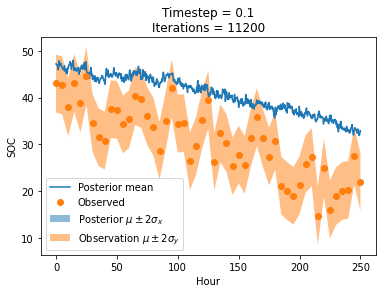

In [15]:
plot_post(x, obs_model_CON_noCO2, 7, niter, dt_flow, state_idx = 0)

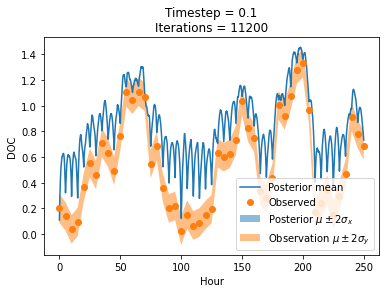

In [16]:
plot_post(x, obs_model_CON_noCO2, 7, niter, dt_flow, state_idx = 1)

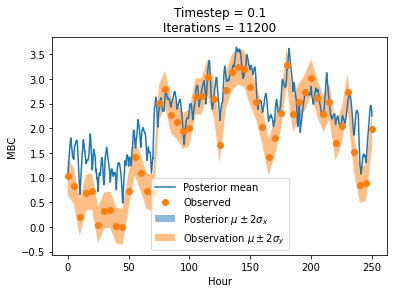

In [17]:
plot_post(x, obs_model_CON_noCO2, 7, niter, dt_flow, state_idx = 2)

In [26]:
def plot_elbo(elbo_hist, num_layers = 5, xmin=0, ymax=None, yscale='linear'):
    iters = torch.arange(xmin + 1, len(elbo_hist) + 1)
    plt.plot(iters, elbo_hist[xmin:])
    plt.ylim((None, ymax))
    plt.yscale(yscale)
    plt.ylabel('ELBO')
    plt.xlabel('Iteration')
    plt.title(f'ELBO history after {xmin} iterations')
    plt.savefig(f'ELBO_t_{t}_dt_{dt_flow}_layers_{num_layers}_iter{niter}.png', dpi = 300)

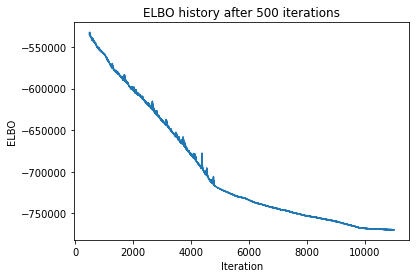

In [27]:
plot_elbo(elbo_hist_batch_1_dt_flow_0_1, num_layers = 7, xmin = 500)